# Portfolio Volatility, Correlations and sharpe Ratio

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Computed Beta for Gold (GC=F): 0.0599


[*********************100%***********************]  6 of 6 completed



Individual Asset Expected Returns:
FRSH: 0.1623
GC=F: 0.0500
GIB: 0.1154
GOOGL: 0.1322
IQV: 0.1715
ZM: 0.0458

Individual Asset Volatilities:
FRSH: 0.0385
GC=F: 0.0097
GIB: 0.0132
GOOGL: 0.0198
IQV: 0.0191
ZM: 0.0288

Individual Asset Sharpe Ratios:
FRSH: 3.0466
GC=F: 0.5164
GIB: 5.3228
GOOGL: 4.4057
IQV: 6.6417
ZM: 0.0291

Portfolio Metrics:
Portfolio Exp Return: 0.1422
Portfolio Beta: 1.1603
Portfolio Volatility: 0.0147
Portfolio Sharpe: 6.6198

Correlation between Portfolio and S&P 500: 0.8248


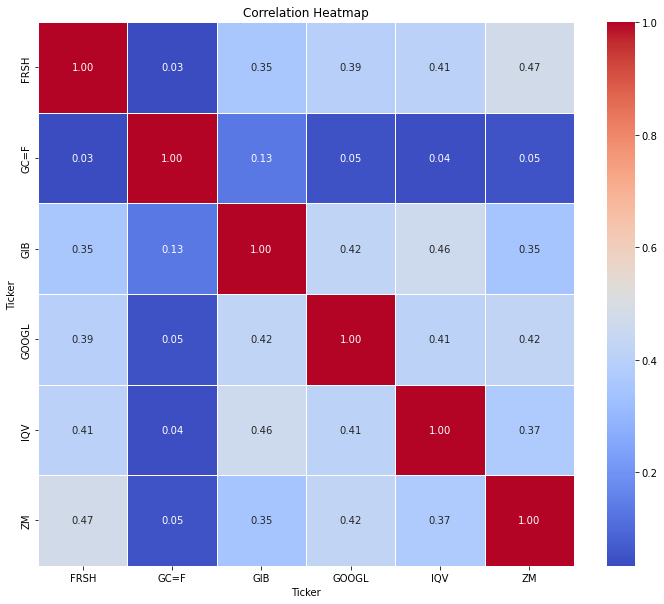

[*********************100%***********************]  6 of 6 completed


=== Risk Parity Allocation ===
Stock  Volatility  Risk Parity Weight  Capital Allocated  Latest Price  Shares to Buy
 FRSH      0.0385              0.0759           106.2659       14.8550           7.15
 GC=F      0.0097              0.3005           420.7477     3307.8999           0.13
  GIB      0.0132              0.2210           309.4377      104.5450           2.96
GOOGL      0.0198              0.1478           206.8683      177.2001           1.17
  IQV      0.0191              0.1534           214.7908      157.3900           1.36
   ZM      0.0288              0.1013           141.8897       77.3700           1.83

=== Risk Parity Portfolio Metrics ===
Portfolio Exp Return: 0.1033
Portfolio Beta: 0.6963
Portfolio Volatility: 0.0112
Portfolio Sharpe: 5.1999
Correlation between RP Portfolio and S&P 500: 0.8111


In [15]:
import numpy as np
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Define date range for returns
sim_start = '2021-01-01'
sim_finish = '2028-09-28'

# Download gold and market data for beta calc
gold_returns = yf.download('GC=F', start=sim_start, end=sim_finish, auto_adjust=False)['Adj Close'].pct_change()
market_returns = yf.download('^GSPC', start=sim_start, end=sim_finish, auto_adjust=False)['Adj Close'].pct_change()

# Align by date
returns_df = pd.concat([gold_returns, market_returns], axis=1).dropna()
returns_df.columns = ['GC=F', 'Market']

# Calculate beta for gold
cov = np.cov(returns_df['GC=F'], returns_df['Market'])[0, 1]
var_market = np.var(returns_df['Market'])
gold_beta = cov / var_market
print(f"\nComputed Beta for Gold (GC=F): {gold_beta:.4f}")



# Original lists
stocks = ['GOOGL','IQV','GIB','ZM','GC=F','FRSH']
capital = [177   ,630  ,418 ,77  ,0,98]
betas = np.array([1.04,1.51, 0.84, 0.01, gold_beta,1.4])

# Alphabetize stocks and reorder values accordingly
sorted_indices = np.argsort(stocks)
stocks = np.array(stocks)[sorted_indices]
capital = np.array(capital)[sorted_indices]
betas = betas[sorted_indices]

# Fixed financial variables
rf = 0.045
market_return = 0.1288
weights = capital / np.sum(capital)
exp_returns = rf + betas * (market_return - rf)

# Download historical stock data for all assets
data = yf.download(stocks.tolist(), start=sim_start, end=sim_finish, auto_adjust=False)['Adj Close'].pct_change()

# Compute volatilities and correlations
volatilities = np.std(data, axis=0)
correlations = data.corr()

# Portfolio calculations
betap = np.sum(weights * betas)
exp_returnp = np.sum(weights * exp_returns)

# Portfolio variance
variancep = 0
for i in range(len(stocks)):
    for j in range(len(stocks)):
        variancep += weights[i] * weights[j] * volatilities.iloc[i] * volatilities.iloc[j] * correlations.iloc[i, j]

volatilityp = np.sqrt(variancep)

# Print outputs
print("\nIndividual Asset Expected Returns:")
for i in range(len(stocks)):
    print(f"{stocks[i]}: {exp_returns[i]:.4f}")

print("\nIndividual Asset Volatilities:")
for i in range(len(stocks)):
    print(f"{stocks[i]}: {volatilities[i]:.4f}")

print("\nIndividual Asset Sharpe Ratios:")
for i in range(len(stocks)):
    sharpe_ratio = (exp_returns[i] - rf) / volatilities[i]
    print(f"{stocks[i]}: {sharpe_ratio:.4f}")

# Portfolio summary
sharpep = (exp_returnp - rf) / volatilityp
print("\nPortfolio Metrics:")
print(f"Portfolio Exp Return: {exp_returnp:.4f}")
print(f"Portfolio Beta: {betap:.4f}")
print(f"Portfolio Volatility: {volatilityp:.4f}")
print(f"Portfolio Sharpe: {sharpep:.4f}")


# Calculate weighted daily portfolio returns
portfolio_returns = data.dot(weights)

# Align with market returns and drop NaNs
aligned_df = pd.concat([portfolio_returns, returns_df['Market']], axis=1).dropna()
aligned_df.columns = ['Portfolio', 'Market']

# Calculate correlation
portfolio_market_correlation = aligned_df['Portfolio'].corr(aligned_df['Market'])
print(f"\nCorrelation between Portfolio and S&P 500: {portfolio_market_correlation:.4f}")



# Plot correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlations, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()




# === Risk Parity Share Allocation ===

# Step 1: Inverse volatility weights
inv_vol = 1 / volatilities
risk_parity_weights = inv_vol / inv_vol.sum()

# Step 2: Use same total capital
total_capital = np.sum(capital)
rp_capital_allocation = risk_parity_weights * total_capital

# Step 3: Get latest prices
latest_prices = yf.download(stocks.tolist(), period='1d', interval='1d', auto_adjust=False)['Adj Close'].iloc[0]

# Step 4: Calculate shares to buy (floor for full shares)
shares_to_buy = rp_capital_allocation / latest_prices

# Step 5: Output DataFrame
rp_allocation_df = pd.DataFrame({
    'Stock': stocks,
    'Volatility': volatilities.values,
    'Risk Parity Weight': risk_parity_weights.values,
    'Capital Allocated': rp_capital_allocation.values,
    'Latest Price': latest_prices.values,
    'Shares to Buy': shares_to_buy.values.round(2)
})

print("\n=== Risk Parity Allocation ===")
print(rp_allocation_df.round(4).to_string(index=False))






# === Risk Parity Portfolio Metrics ===

# Recalculate portfolio metrics using risk parity weights
rp_weights = risk_parity_weights.values

# Expected return and beta
rp_exp_return = np.sum(rp_weights * exp_returns)
rp_beta = np.sum(rp_weights * betas)

# Portfolio variance using RP weights
rp_variance = 0
for i in range(len(stocks)):
    for j in range(len(stocks)):
        rp_variance += (
            rp_weights[i] * rp_weights[j] *
            volatilities.iloc[i] * volatilities.iloc[j] *
            correlations.iloc[i, j]
        )
rp_volatility = np.sqrt(rp_variance)

# Sharpe ratio
rp_sharpe = (rp_exp_return - rf) / rp_volatility

# RP daily returns
rp_portfolio_returns = data.dot(rp_weights)

# Align RP returns with market returns
aligned_rp_df = pd.concat([rp_portfolio_returns, returns_df['Market']], axis=1).dropna()
aligned_rp_df.columns = ['RiskParityPortfolio', 'Market']

# Correlation with market
rp_market_corr = aligned_rp_df['RiskParityPortfolio'].corr(aligned_rp_df['Market'])

# Display
print("\n=== Risk Parity Portfolio Metrics ===")
print(f"Portfolio Exp Return: {rp_exp_return:.4f}")
print(f"Portfolio Beta: {rp_beta:.4f}")
print(f"Portfolio Volatility: {rp_volatility:.4f}")
print(f"Portfolio Sharpe: {rp_sharpe:.4f}")
print(f"Correlation between RP Portfolio and S&P 500: {rp_market_corr:.4f}")



# Stock Valuation based on comparing Mkt Cap to WACC discounted expected future Free cash flows 

In [1]:
import requests
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

api1 = 'YQVUCRXG19J8O9CY'
api2 = 'P0JGV8OFRPIUD7L6'

def FCFAnalysis(stock):
    
    print('')
    print('')

    api = api1
    Freq = 'Q'    #ANNUAL(A),Quarterly(Q) 
    risk_free_rate = 0.045
    margin = 0.2
    market_return = 0.1
    tax_rate = 0.21
    Forecast_period = 600



    url = f'https://www.alphavantage.co/query?function=CASH_FLOW&symbol={stock}&apikey={api}'
    r = requests.get(url)
    data1 = r.json()

    try:
        if Freq == 'A':
            reportfreq = "annualReports"
        else:
            reportfreq = "quarterlyReports"

        FCF_array = []
        fiscal_dates = []
        for i in range (0,len(data1[reportfreq])): 
            date = data1[reportfreq][i]['fiscalDateEnding']
            
            if i == 0:
                last_date = date
                
            fiscal_dates.append(date)
            
            
            if data1[reportfreq][i]['operatingCashflow'] != 'None':
                OCF = float(data1[reportfreq][i]['operatingCashflow'])
            else:
                OCF = 0
                #return print(f"!!!OCF missing for {stock}!!!")

            # Check for 'capitalExpenditures' key in each report
            if data1[reportfreq][i]['capitalExpenditures'] != 'None':
                CapEx = float(data1[reportfreq][i]['capitalExpenditures'])
            else:
                return print(f"!!!capEx missing for {stock}!!!")

            FCF = OCF - CapEx
            FCF_array.append(FCF)
            
            
    except KeyError:
        return print('VPN NEEDS TO BE CHANGED')



    FCF_array.reverse()
    fiscal_dates.reverse()

    fiscal_dates = pd.to_datetime(fiscal_dates) + pd.DateOffset(months=3)


    fcf_df = pd.DataFrame({'FCF': FCF_array}, index=pd.to_datetime(fiscal_dates))


    plt.figure(figsize=(12, 6))
    plt.plot(FCF_array, marker='o')




    # Generate x values corresponding to FCF data
    x = (np.arange(len(FCF_array)).reshape(-1, 1))/4



    # Example: linearly increasing weights (you can choose an exponential or other pattern too)
    weights = np.linspace(1, 20, len(FCF_array))  # More recent points get weight closer to 4

    # Fit the weighted linear regression model
    model = LinearRegression()
    model.fit(x, FCF_array, sample_weight=weights)
    
    # Forecast next 30 values
    x_forecast = (np.arange(len(FCF_array) + Forecast_period).reshape(-1, 1))/4
    linear_forecast = model.predict(x_forecast)

    print(f'Fiscal Date Ending {last_date}')
    
    # Plot the original data, linear trend, and forecast with sine wave
    plt.figure(figsize=(12, 6))
    plt.plot(x, FCF_array, label='Original Data')
    plt.plot(x_forecast[:len(FCF_array)+20], linear_forecast[:len(FCF_array)+20], '-', label='Forecast (Linear Trend)')
    plt.legend()
    plt.title('Free Cash Flow Forecast with Linear Trend')
    plt.xlabel('Period')
    plt.ylabel('FCF (USD)')
    plt.grid(True)
    plt.show()
    
    
    # Calculate Market cap
    url = f'https://www.alphavantage.co/query?function=OVERVIEW&symbol={stock}&apikey={api}'
    r = requests.get(url)
    data2 = r.json()


    PRICEDATA = yf.download(stock, start="1920-01-01", auto_adjust=False)
    beta  = float(data2['Beta'])
    last_price = PRICEDATA['Adj Close'].values[-1][0]
    market_cap = last_price*int(data2['SharesOutstanding'])
    
    
    
    
    

    
    # Fetch Balance Sheet Data
    url = f'https://www.alphavantage.co/query?function=BALANCE_SHEET&symbol={stock}&apikey={api}'   
    r = requests.get(url)
    data3 = r.json()
    
    
    
    # Retrieve Total Debt
    try:
        # Access the components
        short_term_debt = float(data3[reportfreq][0]['shortTermDebt']) if data3[reportfreq][0]['shortTermDebt'] != 'None' and float(data3[reportfreq][0]['shortTermDebt']) >= 0 else 0.0
        long_term_debt = float(data3[reportfreq][0]['longTermDebt']) if data3[reportfreq][0]['longTermDebt'] != 'None' and float(data3[reportfreq][0]['longTermDebt']) >= 0 else 0.0
        capital_lease_obligations = float(data3[reportfreq][0]['capitalLeaseObligations']) if data3[reportfreq][0]['capitalLeaseObligations'] != 'None' and float(data3[reportfreq][0]['capitalLeaseObligations']) >= 0 else 0.0
        
        if short_term_debt == capital_lease_obligations:
            
            total_debt = short_term_debt + long_term_debt
        else:
            total_debt = short_term_debt + long_term_debt + capital_lease_obligations
            
    except KeyError:
        return print("!!!Missing debt data in balance sheet!!!")

    print(f"short Debt: ${short_term_debt:,.2f}")
    print(f"long Debt: ${long_term_debt:,.2f}")
    print(f"capital oblig Debt: ${capital_lease_obligations:,.2f}")
    print(f"Total Debt: ${total_debt:,.2f}")

    # Calculate Cost of Equity using CAPM
    cost_of_equity = risk_free_rate + beta * (market_return - risk_free_rate)
    print(f"Cost of Equity (Re): {cost_of_equity * 100:.2f}%")

    
    url = f'https://www.alphavantage.co/query?function=INCOME_STATEMENT&symbol={stock}&apikey={api}'   
    r = requests.get(url)
    data4 = r.json()
    
    if data4[reportfreq][0]['interestExpense'] == 'None':
        interest_expense = 0
    else:   
        interest_expense = float(data4[reportfreq][0]['interestExpense'])
    
    # Approximate Cost of Debt
    cost_of_debt = interest_expense/total_debt
    print(cost_of_debt)

    # Calculate WACC
    equity_weight = market_cap / (market_cap + total_debt)
    debt_weight = total_debt / (market_cap + total_debt)
    wacc = (equity_weight * cost_of_equity) + (debt_weight * cost_of_debt * (1 - tax_rate))
    #waccbruh = 0.0949
    #wacc = waccbruh
    print(f"WACC for {stock}: {wacc * 100:.2f}%")
    
    
    


    forecasted_cashflows = linear_forecast[-Forecast_period:]
    t = np.arange(1, Forecast_period+1)  # t goes from 1 to 31
    discount_factors = (1 + wacc) ** (t/4)

    # Discount the values
    discounted = forecasted_cashflows / discount_factors
    pv = np.sum(discounted)/1000000000000


    

    # Handle duplicate dates by averaging values
    fcf_df = fcf_df.groupby(fcf_df.index).mean()

    # Interpolate the FCF data to match the daily frequency of the stock price data
    fcf_daily = fcf_df.resample('D').interpolate(method='time')

    # Normalize both datasets
    scaler = MinMaxScaler()

    # Ensure the indices are aligned
    common_index = PRICEDATA.index.intersection(fcf_daily.index)

    # Normalize stock price data
    price_normalized = pd.DataFrame(scaler.fit_transform(PRICEDATA.loc[common_index]['Close'].values.reshape(-1, 1)), 
                                    index=common_index, columns=['Close'])

    # Normalize FCF data
    fcf_normalized = pd.DataFrame(scaler.fit_transform(fcf_daily.loc[common_index]['FCF'].values.reshape(-1, 1)), 
                                  index=common_index, columns=['FCF'])

    # Plot both datasets on the same graph
    plt.figure(figsize=(12, 6))

    plt.plot(price_normalized, label='Stock Price')
    plt.plot(fcf_normalized, label='Free Cash Flow')

    # Add legend, title, and labels
    plt.legend()
    plt.title('Normalized Free Cash Flow and Stock Price Data')
    plt.xlabel('Date')
    plt.ylabel('Normalized Value')
    plt.grid(True)

    # Show the plot
    plt.show()



    # Print the discounted values
    print('')
    print(f'Fiscal Date Ending {last_date}')
    print(f"PV of future cash flows for {stock} with i = {risk_free_rate*100}%:")
    print(pv)
    print(f"with margin of safety of {int(margin*100)}%:")
    print(pv*(1 - margin))
    print(f"Current Market Capitalization:")
    print(market_cap/1000000000000)
    print("Market Cap => Safety")
    result = round(((pv * (1 - margin)) / (market_cap / 1000000000000) - 1) * 100, 2)
    print(f'Today Price: {last_price}')
    print(f'Fair Price: {last_price*(result/100 + 1)}')
    # Colorize output based on value
    if result < 0:
        print(f"\033[91m{result}%\033[0m")  # Red for negative
    else:
        print(f"\033[94m{result}%\033[0m")  # Blue for positive
        
    print('')
    print('')
    


    
    
    
    
    
def FCFAnalysisRecurrent(tickers):
    
    for ticker in tickers:
        
        FCFAnalysis(ticker)

# List of all listed US stocks available on Revolut

In [ ]:
bymarketcap = ['UNVR', 'GGAL', 'AAPL', 'NVDA', 'MSFT', 'GOOG', 'GOOGL', 'AMZN', 'META', 'DEN', 'BRK.B', 'LLY', 'AVGO', 'TSM', 'TSLA', 'WMT', 'JPM', 'V', 'XOM', 'UNH', 'PBR', 'ORCL', 'MA', 'FSR', 'HD', 'NVO', 'PG', 'JNJ', 'COST', 'ABBV', 'NFLX', 'BAC', 'ITUB', 'KO', 'SAP', 'ASML', 'CRM', 'CVX', 'MRK', 'VALE', 'TM', 'TMUS', 'NVS', 'ACN', 'AMD', 'BABA', 'AZN', 'PEP', 'LIN', 'TMO', 'MCD', 'CSCO', 'ADBE', 'WFC', 'IBM', 'GE', 'ABT', 'SHEL', 'ABEV', 'TMPO', 'DHR', 'AXP', 'MS', 'CAT', 'QCOM', 'NOW', 'PM', 'ISRG', 'VZ', 'TXN', 'RY', 'DIS', 'NEE', 'PDD', 'AMGN', 'INTU', 'RTX', 'GS', 'UBER', 'PFE', 'SPGI', 'CMCSA', 'HSBC', 'BLK', 'LOW', 'T', 'TTE', 'AMAT', 'BBD', 'HDB', 'UNP', 'PGR', 'BKNG', 'LMT', 'HON', 'BHP', 'SYK', 'SNY', 'ETN', 'MUFG', 'TJX', 'SCHW', 'BSX', 'ANET', 'VRTX', 'NKE', 'MU', 'COP', 'PANW', 'CB', 'C', 'ADP', 'BUD', 'MDT', 'UPS', 'FISV', 'PLD', 'ADI', 'SONY', 'DE', 'RIO', 'MMC', 'SBUX', 'REGN', 'BSBR', 'GILD', 'BMY', 'HCA', 'SHOP', 'IBN', 'AMT', 'MELI', 'CP', 'SO', 'CHK', 'ELV', 'TD', 'SHW', 'INTC', 'INFY', 'PLTR', 'ICE', 'MDLZ', 'BA', 'LRCX', 'CI', 'DUK', 'BN', 'ENB', 'TT', 'RACE', 'VIV', 'MCO', 'DELL', 'SCCO', 'ZTS', 'APO', 'CTAS', 'ABNB', 'SMFG', 'WM', 'EQIX', 'GD', 'MO', 'CEG', 'BP', 'PYPL', 'PH', 'CME', 'CL', 'WELL', 'CMG', 'APH', 'GSK', 'MSI', 'TDG', 'SNPS', 'AON', 'NOC', 'ITW', 'DEO', 'USB', 'SPOT', 'CRWD', 'TRI', 'CVS', 'CNQ', 'TEVA', 'PNC', 'MAR', 'ECL', 'ATVI', 'MMM', 'APD', 'CARR', 'TGT', 'EOG', 'CNI', 'CDNS', 'BDX', 'ORLY', 'FCX', 'MRVL', 'NU', 'BMO', 'EQNR', 'FDX', 'BNS', 'CSX', 'NEM', 'MCK', 'JD', 'WDAY', 'RSG', 'AFL', 'WMB', 'CRH', 'DHI', 'AJG', 'EMR', 'ADSK', 'IBKR', 'DASH', 'SBS', 'FTNT', 'VMW', 'COF', 'TRV', 'PSA', 'ROP', 'MET', 'SLB', 'NXPI', 'CM', 'HLT', 'TTD', 'TFC', 'PCAR', 'SPG', 'NSC', 'OKE', 'SE', 'O', 'URI', 'BK', 'IMO', 'PSX', 'KMI', 'GM', 'GWW', 'COIN', 'SRE', 'FANG', 'MFG', 'DLR', 'HMC', 'AZO', 'MFC', 'AEP', 'PCG', 'NTES', 'MPC', 'MNST', 'CPRT', 'JCI', 'ALL', 'RCL', 'AMP', 'PAYX', 'LEN', 'E', 'AIG', 'D', 'KDP', 'TRP', 'SU', 'TEAM', 'ROST', 'FIS', 'KMB', 'CCI', 'APP', 'FICO', 'OXY', 'MSCI', 'LHX', 'WCN', 'CHTR', 'PWR', 'CMI', 'SQ', 'BCS', 'PRU', 'TAK', 'HLN', 'TEL', 'CPNG', 'VST', 'PEG', 'MPWR', 'FAST', 'F', 'VLO', 'STZ', 'MSTR', 'KHC', 'AEM', 'DDOG', 'SGEN', 'IQV', 'NDAQ', 'HWM', 'HES', 'ODFL', 'TIMB', 'OTIS', 'EW', 'TCOM', 'VRT', 'NICE', 'GEHC', 'MCHP', 'LNG', 'ALC', 'CTVA', 'BRFS', 'EXC', 'IT', 'KR', 'ACGL', 'IR', 'SNOW', 'GLW', 'A', 'CVNA', 'AME', 'GIS', 'CTSH', 'CBRE', 'EA', 'VRSK', 'ALNY', 'LVS', 'YUM', 'IDXX', 'HSY', 'NUE', 'DFS', 'GGB', 'DOW', 'SYY', 'ED', 'STLA', 'IRM', 'GOLD', 'EXR', 'BKR', 'DAL', 'HPQ', 'VEEV', 'RKT', 'LULU', 'HIG', 'XEL', 'TRGP', 'ERJ', 'DD', 'MLM', 'DB', 'ESLT', 'RMD', 'FNV', 'EFX', 'OWL', 'VICI', 'WIT', 'VMC', 'CIG', 'PBA', 'ARGX', 'WAB', 'AXON', 'BIDU', 'SLF', 'EIX', 'MTB', 'XYL', 'CNC', 'NTR', 'CSGP', 'AVB', 'EL', 'GRMN', 'HUM', 'FMX', 'TSCO', 'EBAY', 'WEC', 'HEI', 'WDS', 'CVE', 'NET', 'ROK', 'PHM', 'FTS', 'BCE', 'PPG', 'NVR', 'PHG', 'BRO', 'FITB', 'CHT', 'ON', 'ORAN', 'CDW', 'MTD', 'DXCM', 'ZS', 'ETR', 'EQR', 'ANSS', 'RJF', 'TW', 'K', 'IOT', 'KEYS', 'BIIB', 'SMCI', 'AWK', 'HUBS', 'CCL', 'LI', 'TTWO', 'CAH', 'VTR', 'FTV', 'ADM', 'BEKE', 'STT', 'HPE', 'DVN', 'DOV', 'DTE', 'SBAC', 'BNTX', 'GIB', 'LYV', 'TECK', 'GPN', 'NTAP', 'RBLX', 'TROW', 'BR', 'CHD', 'ERIE', 'FE', 'TYL', 'HAL', 'BGNE', 'FWONK', 'DECK', 'ICLR', 'HUBB', 'TU', 'UAL', 'TPL', 'ROL', 'PPL', 'WY', 'TPG', 'HOOD', 'AEE', 'STX', 'WRB', 'ES', 'ILMN', 'GDDY', 'UGP', 'WDC', 'WSO', 'BF.A', 'BF.B', 'BAM', 'QSR', 'LDOS', 'PINS', 'BLDR', 'CHKP', 'GFL', 'HBAN', 'GFS', 'ATO', 'PTC', 'CINF', 'SYF', 'CBOE', 'RF', 'CSL', 'ZM', 'EQT', 'ZBH', 'COO', 'MKC', 'LII', 'FSLR', 'TSN', 'CMS', 'RCI', 'WST', 'SHG', 'BAH', 'EME', 'STLD', 'TDY', 'PKX', 'TRU', 'PFG', 'INVH', 'MT', 'MRNA', 'EXPE', 'RYAAY', 'WAT', 'BBY', 'MKL', 'TER', 'BALL', 'ZTO', 'OMC', 'MDB', 'CLX', 'GPC', 'PKG', 'CNP', 'ICL', 'UMC', 'NTRS', 'ZBRA', 'DRI', 'WBD', 'APTV', 'CFG', 'AER', 'HOLX', 'SSNC', 'BAX', 'FOXA', 'MAS', 'PSTG', 'DKNG', 'CG', 'LUV', 'TS', 'VRSN', 'RYAN', 'MANH', 'WSM', 'LH', 'MAA', 'JBHT', 'L', 'FDS', 'WLK', 'J', 'IHG', 'NRG', 'DKS', 'DG', 'HRL', 'AVY', 'SNAP', 'ULTA', 'RPM', 'SNA', 'TSEM', 'TOST', 'FNF', 'SUI', 'MOH', 'EC', 'NMR', 'TXT', 'YUMC', 'AVTR', 'WMG', 'NTNX', 'GEN', 'NVMI', 'DGX', 'RPRX', 'KIM', 'PODD', 'OC', 'ALGN', 'BURL', 'UTHR', 'SWK', 'KEY', 'GFI', 'DT', 'RS', 'IP', 'AMCR', 'AKAM', 'TOL', 'TFII', 'LNT', 'IEX', 'NI', 'SWKS', 'THC', 'GWRE', 'UHS', 'ENTG', 'SID', 'H', 'PCVX', 'JHX', 'NWSA', 'USFD', 'UI', 'GMAB', 'COHR', 'BAP', 'CF', 'NTRA', 'AZPN', 'BSY', 'TRMB', 'RBA', 'MRO', 'FIX', 'LOGI', 'CE', 'DPZ', 'GRAB', 'UDR', 'MORN', 'RNR', 'NDSN', 'EQH', 'DOCU', 'FTAI', 'DLTR', 'Z', 'ZG', 'GGG', 'CASY', 'CAG', 'ACM', 'CPB', 'BAK', 'MNDY', 'JBL', 'RGA', 'POOL', 'BXP', 'GLPI', 'EVRG', 'VTRS', 'CNHI', 'AMH', 'CW', 'LAMR', 'CLH', 'AFRM', 'FLEX', 'AGR', 'EDR', 'CNA', 'JEF', 'ARCC', 'DVA', 'JKHY', 'ALLE', 'BMRN', 'UHAL', 'UHAL.B', 'EXAS', 'REG', 'XPO', 'WPC', 'KGC', 'TTEK', 'PFGC', 'SJM', 'CHRW', 'JNPR', 'CPT', 'FUTU', 'INCY', 'RL', 'AU', 'EWBC', 'EMN', 'HTHT', 'OKTA', 'BCH', 'CYBR', 'BG', 'FFIV', 'JLL', 'MGA', 'NVT', 'MGM', 'BLD', 'HST', 'DUOL', 'AES', 'ENPH', 'TXRH', 'RTO', 'ITT', 'WMS', 'SWN', 'CHWY', 'SRPT', 'FMS', 'HLI', 'YPF', 'IPG', 'NBIX', 'CACI', 'UNM', 'CCK', 'FND', 'RRX', 'FSV', 'BJ', 'SAIA', 'SFM', 'ROKU', 'KMX', 'BWXT', 'LECO', 'EPAM', 'PSN', 'AFG', 'EDU', 'TWLO', 'LBRDA', 'TFX', 'TECH', 'COKE', 'PR', 'CUBE', 'ATR', 'ALB', 'FBIN', 'LW', 'MMYT', 'WTRG', 'MEDP', 'WYNN', 'KNSL', 'ACI', 'BEN', 'FTI', 'EVR', 'SCI', 'CTLT', 'TAP', 'NLY', 'MKTX', 'NIO', 'SQM', 'WING', 'SOFI', 'ERF', 'AA', 'PPC', 'WFG', 'ALLY', 'OVV', 'TPR', 'PAG', 'SF', 'NCLH', 'ARMK', 'SNX', 'DOX', 'MBLY', 'ONTO', 'LKQ', 'HII', 'AIZ', 'CRL', 'EXP', 'HAS', 'MHK', 'CHDN', 'RIVN', 'MTZ', 'GNRC', 'RGLD', 'XPEV', 'XP', 'QRVO', 'MTCH', 'BSAC', 'TME', 'GMED', 'GL', 'MUSA', 'WWD', 'EHC', 'CZR', 'OLED', 'GLOB', 'QGEN', 'SKX', 'BIO', 'STN', 'FRT', 'PCTY', 'SEIC', 'PAYC', 'WIX', 'GME', 'AYI', 'BRKR', 'AOS', 'PRI', 'CIEN', 'FLR', 'WAL', 'ORI', 'CNM', 'KBR', 'SIRI', 'APG', 'WBA', 'APA', 'FHN', 'CHE', 'HSIC', 'CR', 'DSGX', 'NYT', 'OTEX', 'WBS', 'DCI', 'CX', 'GPK', 'NNN', 'AIT', 'EGP', 'WEX', 'PAAS', 'FYBR', 'GTLB', 'AAON', 'WCC', 'TPX', 'U', 'ALSN', 'INGR', 'IMGN', 'CMA', 'DBX', 'TTC', 'AAL', 'BRX', 'X', 'HRB', 'BRBR', 'FOUR', 'ENSG', 'DTM', 'DINO', 'RVMD', 'RBC', 'KNX', 'LAD', 'IVZ', 'ESTC', 'BILI', 'MOS', 'S', 'AR', 'AGNC', 'LNW', 'CROX', 'ITCI', 'OGE', 'EXEL', 'RGEN', 'VOYA', 'FCN', 'MLI', 'UFPI', 'PNFP', 'INFA', 'ALTR', 'PEN', 'LNTH', 'DOCS', 'BERY', 'CHRD', 'BWA', 'SSD', 'ANF', 'KNTK', 'KT', 'AXTA', 'CRS', 'CFR', 'LEGN', 'CBSH', 'CELH', 'ASND', 'ATI', 'ALV', 'FMC', 'SMAR', 'ASTS', 'GIL', 'MASI', 'SSB', 'WTFC', 'HQY', 'AEL', 'BFAM', 'VIPS', 'VFC', 'CIGI', 'COLD', 'AGCO', 'SPXC', 'ZION', 'GXO', 'AMKR', 'MIDD', 'HMY', 'RLI', 'PARAA', 'SUM', 'MTH', 'LEVI', 'TMHC', 'LPX', 'LSCC', 'SAIC', 'FR', 'BOKF', 'BPOP', 'APPF', 'CFLT', 'NSIT', 'RRC', 'IBP', 'PATH', 'SNV', 'ARW', 'STEP', 'SPSC', 'DLB', 'JAZZ', 'KEX', 'OSK', 'TREX', 'BBWI', 'CGNX', 'AXS', 'CCCS', 'PB', 'G', 'TX', 'MKSI', 'RHI', 'SATS', 'GNTX', 'ESAB', 'FAF', 'WTS', 'PLNT', 'LUMN', 'HCP', 'MSA', 'ENLC', 'FRPT', 'CLS', 'CWAN', 'MTG', 'POST', 'AN', 'COTY', 'CRUS', 'VRNS', 'LSTR', 'HR', 'NVEI', 'JHG', 'RH', 'RHP', 'SITE', 'WH', 'CLF', 'EXLS', 'CWST', 'CSWI', 'MAT', 'MTN', 'CYTK', 'R', 'CMC', 'SQSP', 'W', 'MTDR', 'LFUS', 'ELAN', 'NOVT', 'ZWS', 'FRHC', 'AZEK', 'GLBE', 'CHH', 'REYN', 'DDS', 'CBT', 'PEGA', 'KBH', 'IONS', 'TRNO', 'BTG', 'ONB', 'CRDO', 'PKI', 'MDU', 'BILL', 'AWI', 'CVLT', 'VMI', 'LCID', 'COOP', 'CAE', 'PI', 'LEA', 'ESI', 'TKR', 'BMI', 'ELF', 'DAR', 'NOV', 'LAZ', 'INSP', 'RCM', 'CADE', 'SIGI', 'EPRT', 'BEPC', 'BYD', 'BECN', 'ETSY', 'WHR', 'RNA', 'KD', 'OLLI', 'KRG', 'AMG', 'DOOO', 'DY', 'BIPC', 'NFG', 'CACC', 'SKY', 'FSK', 'LYFT', 'EXPO', 'OMF', 'ACT', 'LNC', 'ALK', 'CHX', 'SRCL', 'PVH', 'RITM', 'MMSI', 'BMA', 'SLGN', 'PFSI', 'NXST', 'THG', 'IDA', 'BC', 'MARA', 'STVN', 'FG', 'BCPC', 'OLN', 'BCC', 'AQN', 'ST', 'UGI', 'FSS', 'VNT', 'USM', 'OPCH', 'MMS', 'SEE', 'GBCI', 'BROS', 'GTLS', 'VVV', 'CNS', 'CWEN', 'RKLB', 'PIPR', 'CRVL', 'CNX', 'SWX', 'LTH', 'MC', 'UMBF', 'RDN', 'HOMB', 'ACIW', 'CRNX', 'FNB', 'MSGS', 'FIVE', 'SON', 'MGY', 'CORT', 'KRYS', 'VIRT', 'HXL', 'SMG', 'KRC', 'SLG', 'UBSI', 'DNB', 'TENB', 'OZK', 'NYCB', 'BOOT', 'SLM', 'FCFS', 'RDNT', 'YOU', 'XRAY', 'POR', 'MUR', 'AL', 'QTWO', 'CPRI', 'COLM', 'SNDR', 'SM', 'BBIO', 'BDC', 'BCO', 'CLVT', 'GPI', 'LANC', 'CUZ', 'FLO', 'ACHC', 'RYN', 'WTM', 'VLY', 'MHO', 'AVT', 'FELE', 'HOG', 'GATX', 'UPST', 'TAL', 'WHD', 'ORA', 'MSM', 'TIGO', 'RXO', 'ABG', 'ITRI', 'SHAK', 'SFBS', 'NJR', 'LSI', 'TNET', 'ALKS', 'ACA', 'ALGM', 'HL', 'PII', 'AVNT', 'CRC', 'BOX', 'MATX', 'PECO', 'AGO', 'LITE', 'SMR', 'QLYS', 'OGN', 'SHC', 'HWC', 'WK', 'IRT', 'M', 'ABCB', 'VRRM', 'PRMW', 'PAM', 'SEM', 'ACLLY', 'SIG', 'RMBS', 'BLKB', 'EEFT', 'ICUI', 'SBRA', 'ITGR', 'TPH', 'FUL', 'BKH', 'FIZZ', 'ASH', 'ASGN', 'SSL', 'CPA', 'OGS', 'GDS', 'NCNO', 'TMDX', 'SGRY', 'CRSP', 'CCOI', 'AEIS', 'NNI', 'EAT', 'IGT', 'ENS', 'HUN', 'KMPR', 'GBDC', 'AEO', 'JWN', 'BVN', 'SITM', 'WU', 'SG', 'JOBY', 'FTDR', 'IBOC', 'WEN', 'DOCN', 'VCTR', 'ATHM', 'ALIT', 'CLBT', 'OSCR', 'DNLI', 'PBF', 'ASO', 'ROAD', 'HGV', 'HHC', 'HAE', 'LOPE', 'UA', 'UAA', 'LPL', 'ZI', 'IDCC', 'IPAR', 'HIW', 'INTA', 'GOLF', 'SKYW', 'EGO', 'SCPL', 'CNO', 'DXC', 'FLNC', 'SKT', 'AX', 'IIPR', 'APAM', 'SR', 'SLAB', 'BANF', 'PLXS', 'GMS', 'KTOS', 'IRDM', 'NOG', 'GBTG', 'EBC', 'MCY', 'ALE', 'HCM', 'VAL', 'EPR', 'SPR', 'CVCO', 'SANM', 'TFSL', 'KFY', 'TGLS', 'BL', 'TCBI', 'POWI', 'BRC', 'HGTY', 'APLE', 'UNF', 'ALKT', 'PBH', 'MRUS', 'GVA', 'AXNX', 'DORM', 'GSHD', 'PRCT', 'SLVM', 'FOLD', 'SHOO', 'CNK', 'NHI', 'STR', 'MWA', 'SAM', 'AUB', 'JOE', 'PCH', 'ENV', 'STNE', 'NWE', 'AGYS', 'ABM', 'PRGO', 'INST', 'ASB', 'URBN', 'HP', 'IAG', 'FBP', 'NSA', 'FRSH', 'APLS', 'WDFC', 'STNG', 'XENE', 'FORM', 'PRIM', 'FROG', 'MGEE', 'HAYW', 'FIBK', 'MIR', 'CRK', 'IPGP', 'GFF', 'SXT', 'CATY', 'SMPL', 'LSPD', 'PAY', 'DFH', 'SMTC', 'NSP', 'FULT', 'OTTR', 'NPO', 'JJSF', 'NWL', 'TNL', 'HCC', 'RUN', 'CARG', 'TDW', 'AI', 'YETI', 'ESE', 'ICFI', 'PATK', 'CCS', 'NMIH', 'DEI', 'ATKR', 'AWR', 'CBU', 'AMED', 'PAYO', 'CNXC', 'OUT', 'GEF', 'CEIX', 'SBSW', 'CWT', 'REZI', 'LCII', 'NEOG', 'JBT', 'MLCO', 'FHB', 'PTEN', 'BTU', 'RNG', 'RYTM', 'BRZE', 'MAN', 'TDS', 'WSFS', 'CWK', 'MP', 'GNW', 'AG', 'ACLS', 'PTCT', 'TEX', 'MPW', 'RIOT', 'AVA', 'KYMR', 'BHF', 'APE', 'DIOD', 'BHC', 'DV', 'WAFD', 'NOMD', 'CC', 'SEB', 'COMP', 'RELY', 'SFNC', 'TRN', 'KWR', 'ABR', 'FA', 'PENN', 'BBAR', 'CAR', 'CRGY', 'TBBK', 'PSMT', 'SYNA', 'CDE', 'PRGS', 'ERO', 'PLTK', 'DBRG', 'ASAN', 'LRN', 'JBLU', 'MANU', 'TGNA', 'SNEX', 'VAC', 'BKU', 'FCPT', 'ATGE', 'HUBG', 'TWST', 'QDEL', 'CPK', 'CVBF', 'MEOH', 'AMR', 'WLY', 'UE', 'ZLAB', 'MGRC', 'BOH', 'PAGS', 'AMRX', 'ALRM', 'GPOR', 'MQ', 'VCYT', 'PLUS', 'QS', 'HBI', 'GH', 'GDRX', 'INDB', 'AGIO', 'PPBI', 'NARI', 'HNI', 'VSTO', 'MTX', 'CALX', 'PYCR', 'ARCH', 'SPB', 'AY', 'PFS', 'HTLF', 'PLMR', 'ACAD', 'VC', 'NMRK', 'BATRA', 'CPRX', 'IBTX', 'EE', 'RPD', 'VSH', 'FFBC', 'DLO', 'AMPH', 'GT', 'UTZ', 'ARCB', 'MBC', 'CRI', 'KLIC', 'LAUR', 'BANC', 'DRVN', 'AMBA', 'OSIS', 'CRTO', 'EPAC', 'ADUS', 'AAP', 'B', 'NABL', 'ENR', 'AZZ', 'WERN', 'FL', 'AIN', 'YELP', 'KSS', 'TNDM', 'BE', 'TRUP', 'WB', 'NFE', 'SWTX', 'BANR', 'KROS', 'FBK', 'ENVA', 'FIVN', 'APPN', 'VZIO', 'FRME', 'AVPT', 'ZD', 'BKE', 'TR', 'AIR', 'LOB', 'PAR', 'PTON', 'CSTM', 'MTRN', 'FLYW', 'CAKE', 'SGML', 'THS', 'STRA', 'AKRO', 'PTVE', 'VSCO', 'NBTB', 'TRIP', 'NTLA', 'RNST', 'PRVA', 'EVTC', 'GEO', 'VET', 'MCW', 'JAMF', 'MRVI', 'CCU', 'WOR', 'CENT', 'TFIN', 'SHO', 'TTMI', 'NUVA', 'HTH', 'MSGE', 'VIAV', 'ROCK', 'MBIN', 'MRCY', 'WNS', 'OI', 'CNMD', 'MYRG', 'VCEL', 'PRG', 'WOLF', 'PINC', 'GLPG', 'CABO', 'RXRX', 'LMAT', 'ENVX', 'HRMY', 'KMT', 'SEMR', 'KOS', 'VVX', 'HI', 'ADNT', 'EFSC', 'WRBY', 'CMPR', 'EVCM', 'PLUG', 'DNUT', 'DFIN', 'EXPI', 'CWH', 'STC', 'BEAM', 'SJW', 'ROG', 'LGND', 'GNL', 'TSLX', 'CNXN', 'SAH', 'SYBT', 'DCBO', 'HURN', 'YY', 'NUV', 'OMCL', 'NHC', 'SIMO', 'HEES', 'WSBC', 'RVLV', 'CLDX', 'BCYC', 'NVCR', 'ARVN', 'TXG', 'VICR', 'CXM', 'CERT', 'CLBK', 'LEG', 'FBNC', 'KAR', 'PZZA', 'WMK', 'PD', 'FCF', 'EPC', 'TNC', 'CHCO', 'TALO', 'WGO', 'MLKN', 'NEO', 'NWBI', 'VECO', 'APOG', 'GTY', 'NAVI', 'IMCR', 'LZB', 'AAT', 'CMRE', 'FOXF', 'LKFN', 'RCKT', 'GO', 'SCL', 'STER', 'RCUS', 'TDOC', 'SNDX', 'AMRC', 'RAMP', 'UCTT', 'CHEF', 'HE', 'SFL', 'CODI', 'NBHC', 'ANDE', 'VRE', 'COCO', 'GETY', 'HLIO', 'NVAX', 'GBX', 'INFN', 'DAN', 'JBGS', 'NAPA', 'MLNK', 'SPT', 'HOPE', 'VRTS', 'DAVA', 'BCRX', 'AMC', 'NWN', 'SONO', 'LTC', 'ULCC', 'CDRE', 'AMN', 'HELE', 'IART', 'WOOF', 'NTCT', 'NSSC', 'MTTR', 'NVEE', 'STAA', 'PEB', 'XNCR', 'PGNY', 'BB', 'SRCE', 'STBA', 'XHR', 'HMN', 'PLAB', 'JBI', 'ZUO', 'GOOS', 'TIXT', 'VBTX', 'UMH', 'SCS', 'TCBK', 'CUBI', 'BUSE', 'SASR', 'CTS', 'CRCT', 'MMI', 'BLMN', 'PLAY', 'AFYA', 'CSGS', 'TLRY', 'DVAX', 'TWKS', 'VSAT', 'VRNT', 'LC', 'FDP', 'ATRC', 'MCRI', 'KRO', 'SAVA', 'WABC', 'KURA', 'OLPX', 'RES', 'PDM', 'WWW', 'UNIT', 'RDFN', 'TVTX', 'TWO', 'MGPI', 'UPWK', 'INMD', 'TV', 'ALEX', 'XRX', 'IMTX', 'GIC', 'CET', 'DNOW', 'MRTN', 'LMND', 'DAWN', 'BRDG', 'OPEN', 'COMM', 'COGT', 'SDGR', 'CIM', 'SBH', 'THRM', 'MFA', 'PBI', 'NTST', 'UNFI', 'USPH', 'ANGI', 'IQ', 'CDNA', 'LNN', 'NGVT', 'OXM', 'SSRM', 'PX', 'NMFC', 'INVA', 'UDMY', 'SAFT', 'DQ', 'UVV', 'ARI', 'AGL', 'EIG', 'LZ', 'RC', 'IMKTA', 'IE', 'BHLB', 'COUR', 'GABC', 'ALGT', 'DCOM', 'ALX', 'JKS', 'GDYN', 'MOMO', 'KALU', 'XPEL', 'MSEX', 'AGRO', 'BRP', 'CAL', 'KRNT', 'TGI', 'TRS', 'LOMA', 'FBRT', 'EVRI', 'TIGR', 'SBGI', 'NXRT', 'ACHR', 'ENFN', 'CBRL', 'UXIN', 'DGII', 'FIGS', 'ECPG', 'OCFC', 'IMAX', 'AMPL', 'DK', 'FWRD', 'MD', 'ABB', 'RLAY', 'HIMX', 'PGRU', 'OMI', 'ATEN', 'KFRC', 'BCSF', 'ATSG', 'AVNS', 'ATUS', 'CARS', 'ODP', 'VTLE', 'VIR', 'SBSI', 'XMTR', 'LFG', 'OPK', 'FWRG', 'ARQT', 'RWT', 'FSLY', 'PARR', 'CNOB', 'ACDC', 'HTZ', 'ARR', 'SEDG', 'IGMS', 'AMSF', 'BFS', 'ZIP', 'GES', 'MDRX', 'VTOL', 'FIP', 'BRKL', 'MEG', 'PRO', 'BMBL', 'PLRX', 'HTLD', 'PTLO', 'CSTL', 'MATV', 'CMTG', 'BASE', 'TELL', 'PFC', 'SITC', 'JACK', 'AVO', 'MBUU', 'DLX', 'SEAT', 'CBL', 'AAC', 'ABCL', 'SHLS', 'NOAH', 'PRAA', 'MNRO', 'CSIQ', 'TTGT', 'CYH', 'PRA', 'PUMP', 'PCRX', 'GCI', 'ASIX', 'MNTK', 'ATEC', 'ARKO', 'ICPT', 'FVRR', 'EMBC', 'NBR', 'HUYA', 'HFWA', 'HCSG', 'EYE', 'RSKD', 'CCO', 'SUPV', 'MUX', 'SHEN', 'PUBM', 'GPRE', 'LXRX', 'TH', 'SPTN', 'AXL', 'VTS', 'SCHL', 'CGC', 'INDI', 'RYI', 'NOVA', 'RGR', 'DH', 'BALY', 'HLF', 'HPP', 'IRWD', 'BLDP', 'WRLD', 'MATW', 'CRSR', 'ADPT', 'BGS', 'SLP', 'USNA', 'LPRO', 'CTKB', 'FNKO', 'LXU', 'SNCY', 'MCB', 'CDMO', 'CLNE', 'WLDN', 'CNDT', 'FFWM', 'CVAC', 'MYTE', 'ATEX', 'ROOT', 'JMIA', 'FLGT', 'GTN', 'ALLO', 'RXT', 'CHPT', 'AMPS', 'ARCT', 'CMP', 'LAC', 'DAO', 'RVNC', 'RGNX', 'CLFD', 'PACB', 'FUBO', 'HCAT', 'OFLX', 'NYMT', 'ADTN', 'DIN', 'LESL', 'OTLY', 'QTRX', 'ALEC', 'LX', 'LAND', 'OABI', 'IVR', 'VERV', 'NRC', 'SAGE', 'FNA', 'BIGC', 'OPFI', 'ALLT', 'SENEA', 'SHYF', 'CCCC', 'CCRN', 'CTRA', 'GHRS', 'EWCZ', 'WOW', 'LAZR', 'GRPN', 'WALD', 'BYND', 'CAJ', 'ZIMV', 'PERI', 'MEI', 'CYRX', 'SFIX', 'EHAB', 'FATE', 'AMCX', 'ITOS', 'SNBR', 'APPS', 'REAL', 'AMLX', 'IPI', 'MTLS', 'DSGN', 'NUS', 'FORR', 'EB', 'ASLE', 'ACCD', 'EDIT', 'ENTA', 'BARK', 'FF', 'TTEC', 'NKTR', 'QRTEA', 'CDXS', 'IRBT', 'MVIS', 'ONL', 'QBTS', 'RMAX', 'TBI', 'MODV', 'ZNTL', 'SPCE', 'GOSS', 'BLNK', 'ORGN', 'TPIC', 'NVRO', 'GPRO', 'SKIN', 'CDLX', 'FCNCA', 'NKLA', 'SGMO', 'BZUN', 'RILY', 'FCEL', 'MX', 'NRDY', 'VTYX', 'CHGG', 'SAVE', 'EXFY', 'BKKT', 'FREY', 'INO', 'DOUG', 'CURI', 'SKIL', 'VERU', 'CRNC', 'GRWG', 'IMAB', 'ME', 'SSSS', 'WRK', 'AMK', 'SBNY', 'SST', 'INT', 'STEM', 'GOEV', 'MAXN', 'PETS', 'FLT', 'HRT', 'XGN', 'FRG', 'FGEN', 'PEAK', 'ABC', 'RE', 'WKHS', 'TXMD', 'SRC', 'CUTR', 'BKI', 'HYZN', 'PNM', 'BNL', 'ELMSQ', 'SIX', 'NXGN', 'FREQ', 'MBT', 'LTHM', 'GET', 'RRR', 'STAR', 'MGI', 'DISH', 'RAD', 'CHS']



Fiscal Date Ending 2025-06-30


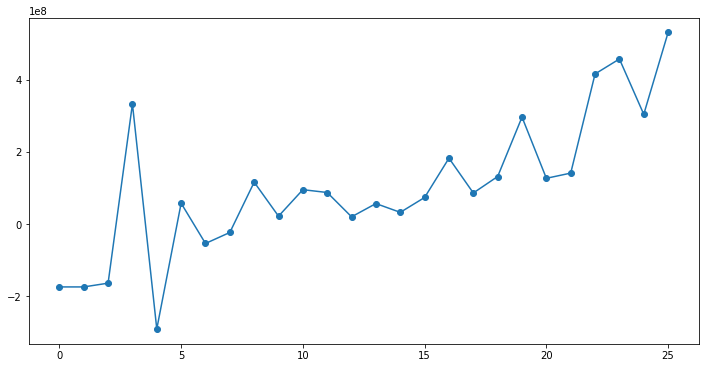

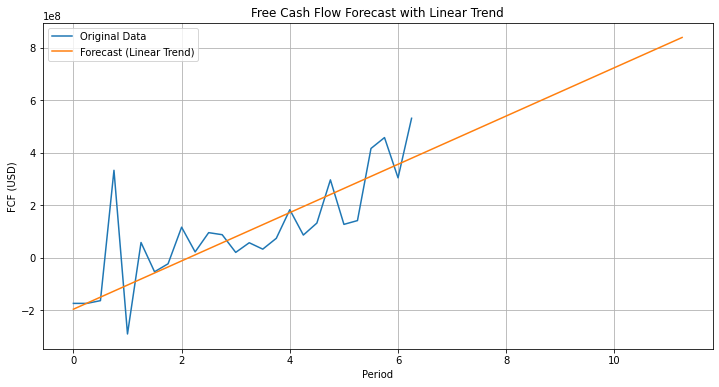

[*********************100%***********************]  1 of 1 completed


short Debt: $45,465,000.00
long Debt: $0.00
capital oblig Debt: $237,812,000.00
Total Debt: $283,277,000.00
Cost of Equity (Re): 18.76%
0.0
WACC for PLTR: 18.74%


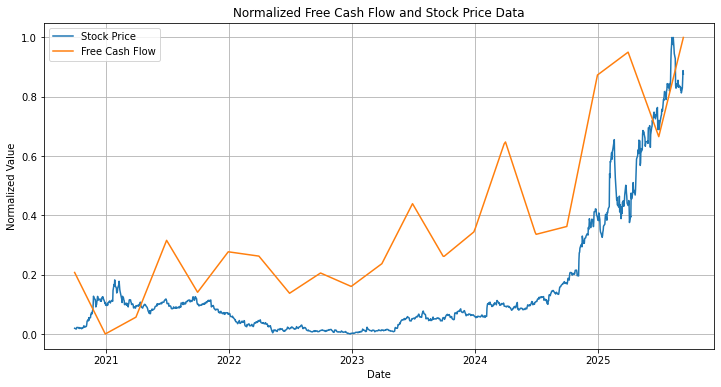


Fiscal Date Ending 2025-06-30
PV of future cash flows for PLTR with i = 4.5%:
0.02108603968402914
with margin of safety of 20%:
0.016868831747223312
Current Market Capitalization:
0.3744114349047852
Market Cap => Safety
Today Price: 164.6300048828125
Fair Price: 7.4248132202148485
-95.49%




Fiscal Date Ending 2025-06-30


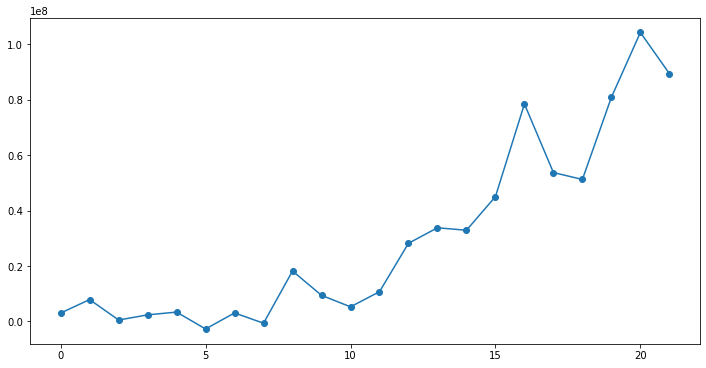

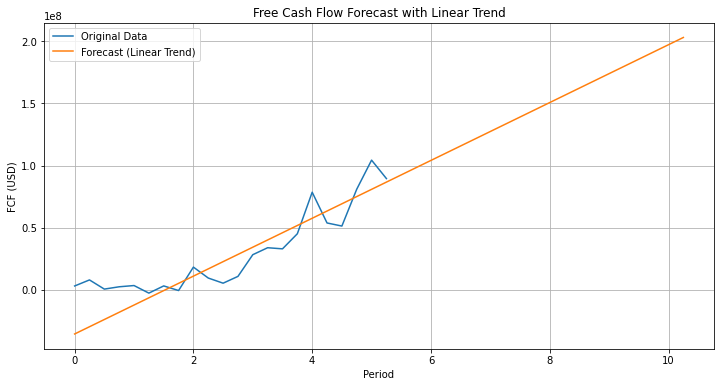

[*********************100%***********************]  1 of 1 completed


short Debt: $2,962,000.00
long Debt: $0.00
capital oblig Debt: $93,843,000.00
Total Debt: $96,805,000.00
Cost of Equity (Re): 9.15%
0.0
WACC for DUOL: 9.08%


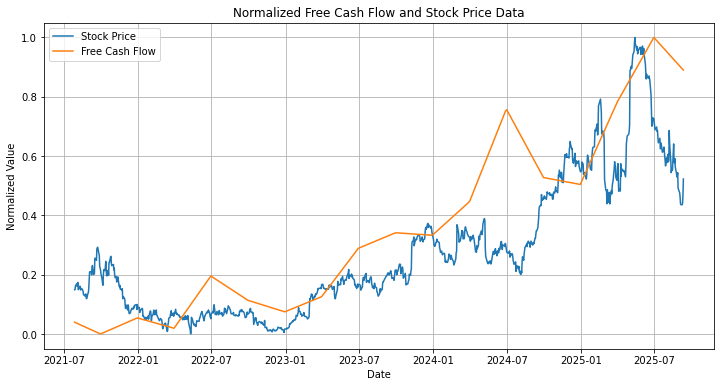


Fiscal Date Ending 2025-06-30
PV of future cash flows for DUOL with i = 4.5%:
0.01627176893539494
with margin of safety of 20%:
0.013017415148315954
Current Market Capitalization:
0.0124116759692688
Market Cap => Safety
Today Price: 312.67999267578125
Fair Price: 327.9387763183594
4.88%




Fiscal Date Ending 2025-06-30


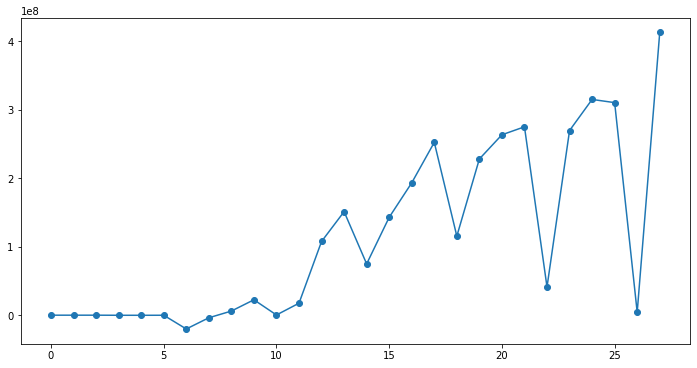

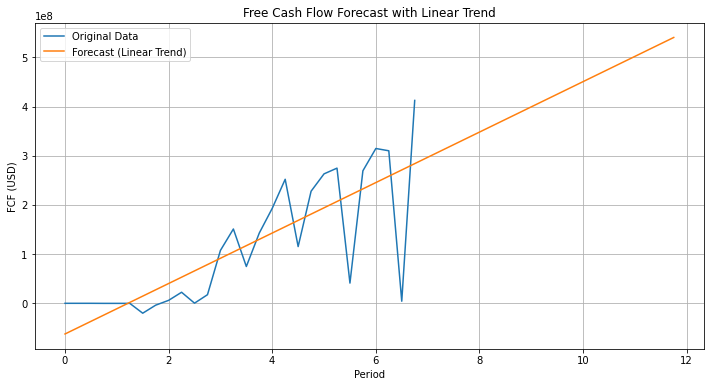

[*********************100%***********************]  1 of 1 completed


short Debt: $0.00
long Debt: $3,241,619,000.00
capital oblig Debt: $406,056,000.00
Total Debt: $3,647,675,000.00
Cost of Equity (Re): 10.83%
0.011510345631121193
WACC for OWL: 8.55%


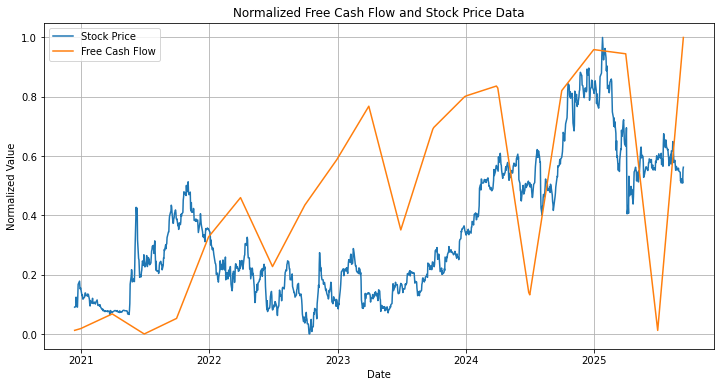


Fiscal Date Ending 2025-06-30
PV of future cash flows for OWL with i = 4.5%:
0.0442074333951632
with margin of safety of 20%:
0.03536594671613056
Current Market Capitalization:
0.012207975
Market Cap => Safety
Today Price: 18.75
Fair Price: 54.318749999999994
189.7%




Fiscal Date Ending 2025-07-31


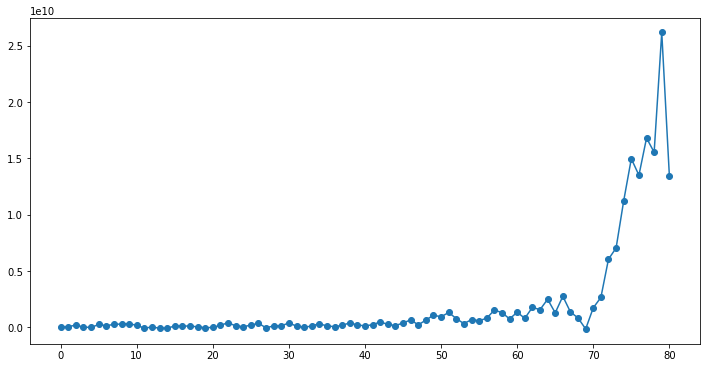

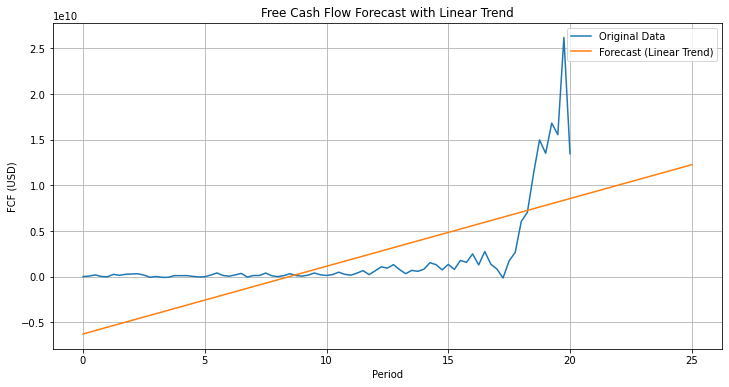

[*********************100%***********************]  1 of 1 completed


short Debt: $301,000,000.00
long Debt: $8,466,000,000.00
capital oblig Debt: $2,132,000,000.00
Total Debt: $10,899,000,000.00
Cost of Equity (Re): 16.06%
0.005688595283971007
WACC for NVDA: 16.02%


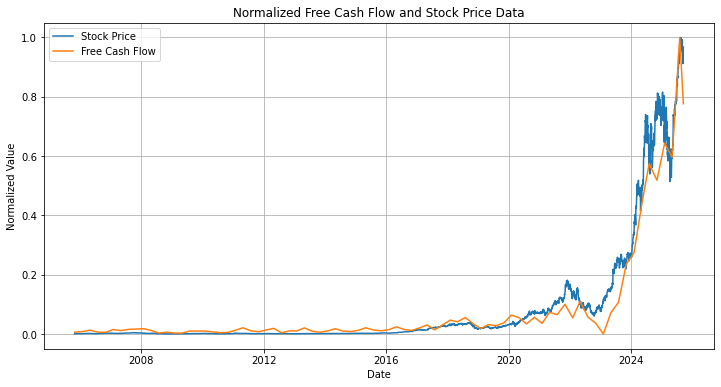


Fiscal Date Ending 2025-07-31
PV of future cash flows for NVDA with i = 4.5%:
0.3602579453516279
with margin of safety of 20%:
0.28820635628130237
Current Market Capitalization:
4.31696668786908
Market Cap => Safety
Today Price: 177.30999755859375
Fair Price: 11.844307836914076
-93.32%




Fiscal Date Ending 2025-06-30


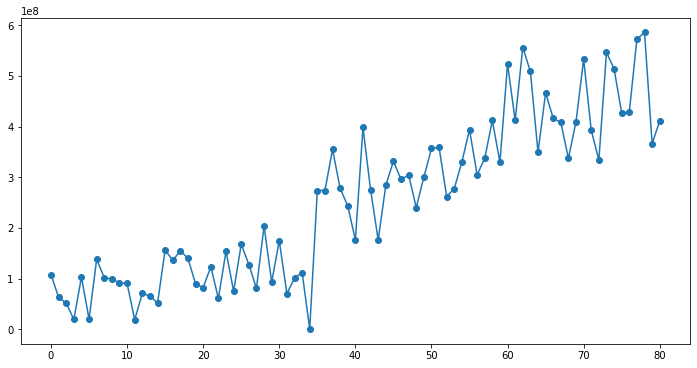

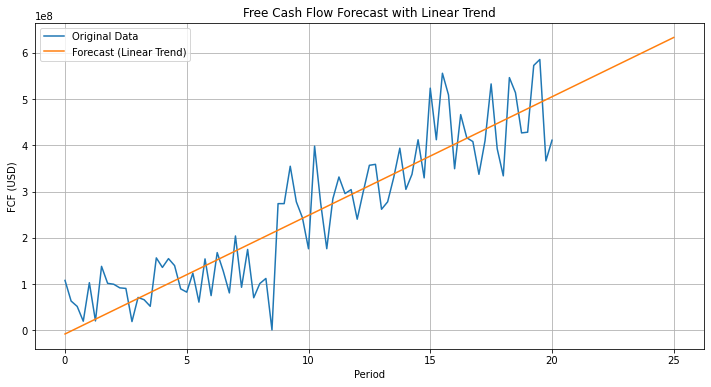

[*********************100%***********************]  1 of 1 completed


short Debt: $167,535,000.00
long Debt: $3,574,761,000.00
capital oblig Debt: $668,932,000.00
Total Debt: $4,411,228,000.00
Cost of Equity (Re): 7.76%
0.007622820674877835
WACC for GIB: 6.38%


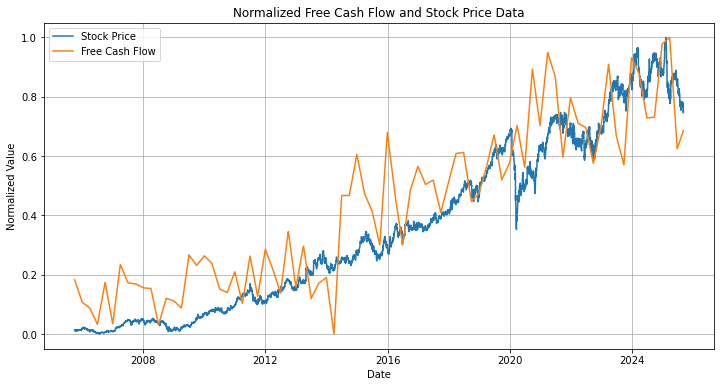


Fiscal Date Ending 2025-06-30
PV of future cash flows for GIB with i = 4.5%:
0.05914125097389254
with margin of safety of 20%:
0.04731300077911404
Current Market Capitalization:
0.018593296107330324
Market Cap => Safety
Today Price: 93.52999877929688
Fair Price: 237.99643489379883
154.46%




Fiscal Date Ending 2025-06-30


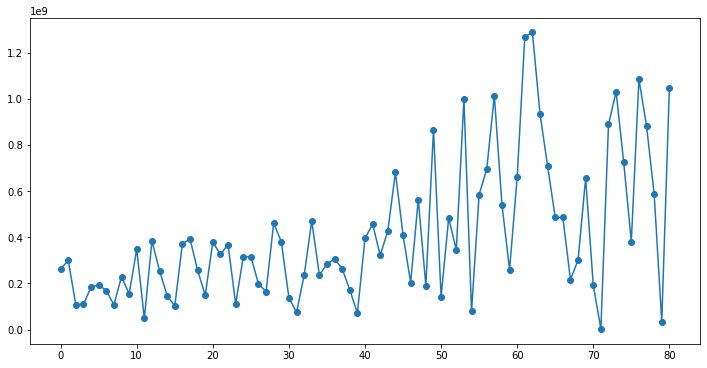

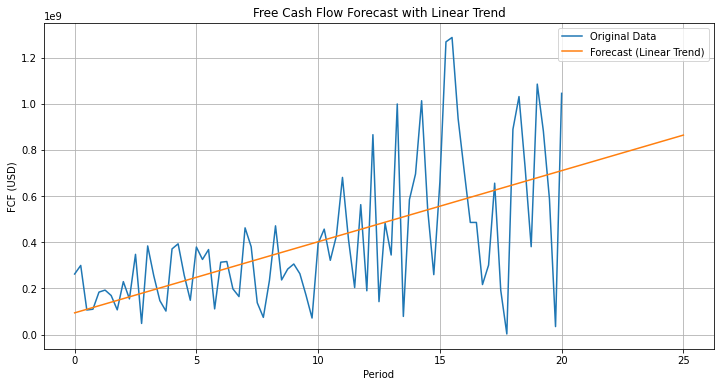

[*********************100%***********************]  1 of 1 completed


short Debt: $1,810,000,000.00
long Debt: $17,531,000,000.00
capital oblig Debt: $0.00
Total Debt: $19,341,000,000.00
Cost of Equity (Re): 6.13%
0.00785895248435965
WACC for BDX: 4.69%


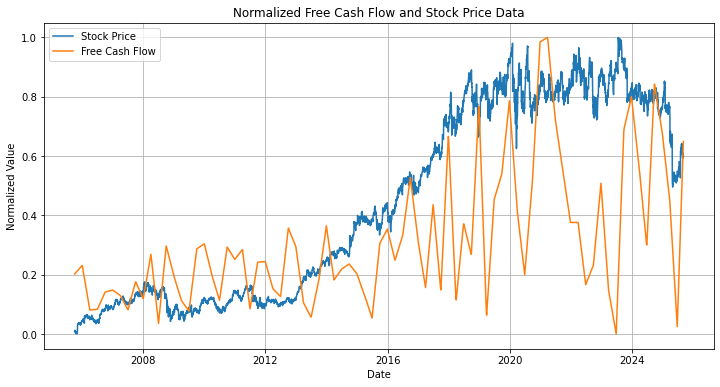


Fiscal Date Ending 2025-06-30
PV of future cash flows for BDX with i = 4.5%:
0.11975446728241262
with margin of safety of 20%:
0.0958035738259301
Current Market Capitalization:
0.054467728460113524
Market Cap => Safety
Today Price: 190.02999877929688
Fair Price: 334.2437648529053
75.89%




Fiscal Date Ending 2025-05-31


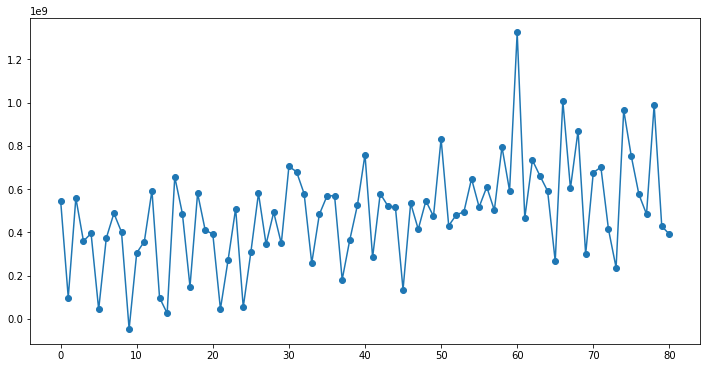

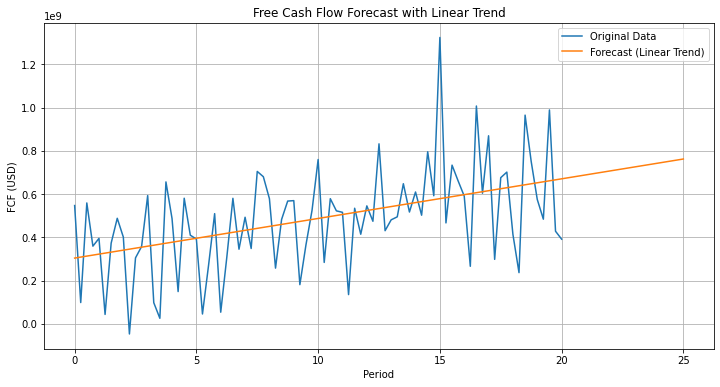

[*********************100%***********************]  1 of 1 completed


KeyError: 'Beta'

In [2]:
FCFAnalysisRecurrent(['PLTR','DUOL','OWL','NVDA','GIB','BDX', 'GIS', 'ZM','IQV','GOOGL'])

## INSURANCE

ICCH  - Very good cash flows, Market Cap => Safety: 1130.42%
        Small market cap though and already large jump up 2024

NODK - Potentially successful but difficult to say Market Cap => Safety
       271.44%. Small market cap
       
UFCS - Reversed the trend and now has good cash flows and price has not
       yet reflected this. Small market cap
       
TIPT - Perfect cash flows other than the fact that it has slightly            declined in recent year Market Cap => Safety 2143.1%
       Could be very successful
       
AMSF - Declining cash flows, I think this company will go bust. This
       has not gone unoticed though as price has been declining but 
       could go further down Market Cap => Safety: -206.65%
       
EIG - Declining cash flows, this could be a company to short. also the 
      decline has not yet been reflected in price!! Market Cap =>Safety
      -137.51% market cap is 1B
      
SAFT - This company will surely go bust. This would be one of my              favorites to short market cap 1B Market Cap => Safety -197.31%

LMND - It appears this company has never made money and im surprised
       it has not gone bust already. the FCF are negative but becoming        less so. Unsure
       
STC - This is a real estate company but it has had a serious decline in 
      FCF recently and has not been refelcted in price
      
NMIH - Did have great FCF until the last 2 years. the trend is weird          but still a potential Market Cap => Safety 707.41%

MCY  - Had great cash flows up until 2023 but they have made a recovery
       and debatable if the price has reflected the recovery fully
       Market Cap => Safety 549.14%
       
CRVL - Brilliant cash flows but unfortunatley is fairly priced
       slightly over
       
SIGI - This company should absolutely be bought. great cash flows and 
       has declined has had a recent dip!!!!!!! Market Cap => Safety
       459.39%
       
ESNT - Another company with brilliant FCF trend, slight dip recently          and the price has gone up ut still some value Market Cap =>            Safety 535.89%

RLI - Great FCF trend. Market Cap => Safety 127.66%. stable price

CNA - Arguably the most perfect cash flows. This company makes money
      Market Cap => Safety 573.63%. Drops signific during crash tho
      
FNF - Market Cap => Safety 1240.82% with FCF trend that has taken off
      in the last few years. price has increased but not enough. BUY
      
PGF - Ok to good cash flows. not sure though. Market Cap => Safety
      720.86%
      
CINF - FCF trend goof but variance increasing. room for profit but
       not a clear buy like other companies
       
WRB - Brilliant FCF trend. Market Cap => Safety 427.43%. Probably buy

ERIE - This company looks like bullshit, the cash flows are not                increasing yet the rpice has skyrocketed. Disparity

HIG - Great FCF trend. Market Cap => Safety 389.96%

ALL - Market Cap => Safety 219.68% but has risen serioiusly in the last
      year. Could be a buy
      
## ENERGY

ENB - Market Cap => Safety 627.52%. Good cash flows. potential buy.           price still recovering.

PBA - Market Cap => Safety 193.48%. The trend is not captured as the
      the cash flows have gotten far better in recent years
      
VVV - This company appears to be failing and has not been refelcted in       price.

RIG - Market Cap => Safety -2108.63% SURELY THIS COMPANY WILL FAIL

TDW - Market Cap => Safety 300.3%. I like this stock its recovered fcf

OII - Failing company, I believe short

## INDUSTRIALS

PH - Perfect, perfect FCF. Accurately priced however. Buy after a dip

TDG - Same as PH

WCN - Market Cap => Safety 70.76% great FCF

IRM - Bullshit FCFs. This company does not make moeny SHORT SHORT SHORT

HEI - Perfect FCF but almost fairly priced. buy after a dip

ROL - Same as above

IEX - Same as above

NDSN - Same as above

GGG - Same as above

UHAL - THIS IS THE STRONGEST SHORT IVE EVER SEEN

MIDD - Market Cap => Safety 176.51%. Good FCF that recovered after a          dip but the price did not!!! buy

CSWI - The perfcet company had it not been accurately priced. Buy after        dip

GATX - Horrific FCF. This company does not make money.

SPR - Failing company. Short

VSEC - large decrease in FCF not reflected

ULH - Same as above

GNK - Potential, cheap stock so 3 wouldnt hurt


## TECH

UBER - Has potential Market Cap => Safety 331.34%

INTC - State of the FCF. short if it didnt invent stuff

TEL - Great FCF but fairly priced

TEAM - Huge opportunity for a buy FCF great and stock dipped in last
       while. Need to investigate Market Cap => Safety 686.52%
       
SNOW - I cannot tell if this company is brilliant or not

HPQ - Negative trend on FCF. short

GIB - Potential to buy, but the FCF has fallen off in recent years

PTSG - Potential buy Market Cap => Safety 197.4%

SWKS - Good FCF trend, dip in the last year. P buy Market Cap => Safety
       262.53%
       
TWLO - Massive spike in FCF recently that has not been refelcted in
       price
       
PAYC - Great FCF but price has been declining alot in last year

MTCH - Market Cap => Safety 222.66%. Good FCF same as above

QLYS - Good FCF, big dip recently Market Cap => Safety 176.77%

BL - Ok FCF, large increase has not been reflected in the price yet

# Real Estate

MAA - Average FCF, Market Cap => Safety 217.2%

EGP - BS FCF

HHH - BS FCF

GTY - SAB

# Consumer Disc

MELI - Looks really good share is 2000 dollars though

CNK - Recent surge in fcf and has not been reflected

FRSH - Not sure why this isnt doing well



# Unsorted

AEE - strong BS short, small mktcp

AVGO - Insanely good fcf but fairly priced

AWK - BS SHORT

BANF - Market Cap => SafetY 176.36%, SOLID FCF

PDD - Market Cap => Safety 4418.37%, Huge inc in FCF

VRTX - Huge decrease in FCF yet hasnt been reflected in price
        This is a healthcare stock though
        
LRCX - Market Cap => Safety 117.13%, VG FCF But not perfect

VIV - Great fcf hasnt been reflected in price for some reason

PH - Great FCF fairly priced

CME - same as above

APH - Same as above

RSG  - Same as above

NTES - This company looks like it should skyrocket but its chinese

WCN - Good FCF but fairly priced

AME - SAB

GIS - Good FCF and undervalued

IRM - Bs fcf short

HEI - Good fcf fairly priced

DBX - Great trend but unsure of future












        














Fiscal Date Ending 2025-03-31


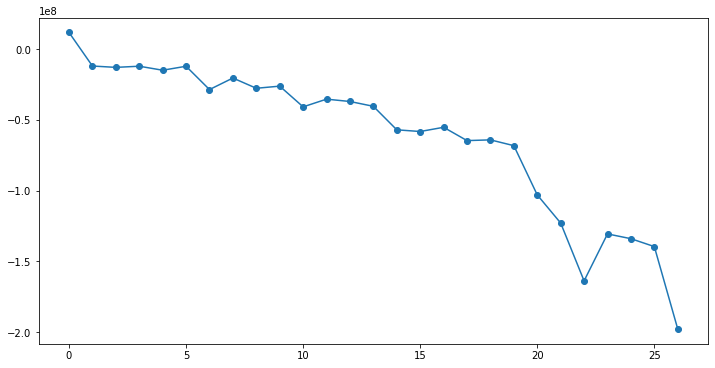

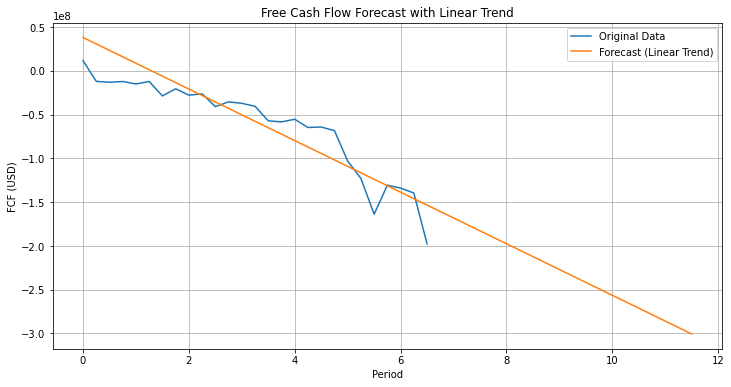

[*********************100%***********************]  1 of 1 completed


short Debt: $12,979,000.00
long Debt: $0.00
capital oblig Debt: $134,342,000.00
Total Debt: $147,321,000.00
Cost of Equity (Re): 10.53%
0.0
WACC for RVMD: 10.31%


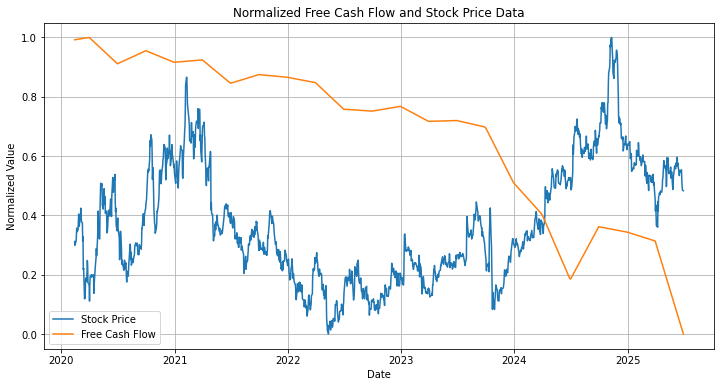


Fiscal Date Ending 2025-03-31
PV of future cash flows for RVMD with i = 4.5%:
-0.018394378115675635
with margin of safety of 20%:
-0.014715502492540508
Current Market Capitalization:
0.007134064257888794
Market Cap => Safety
Today Price: 38.29999923706055
Fair Price: -79.00140842628478
-306.27%




Fiscal Date Ending 2025-03-31


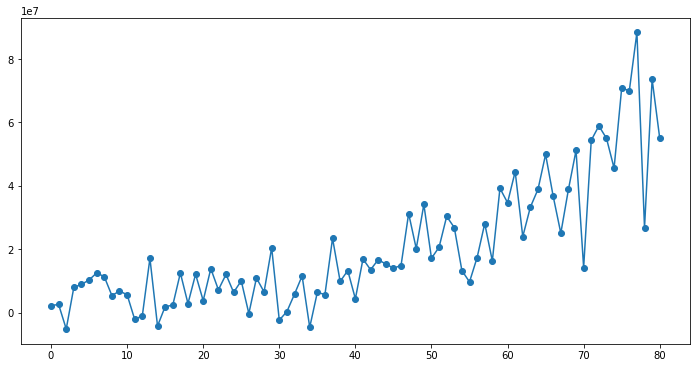

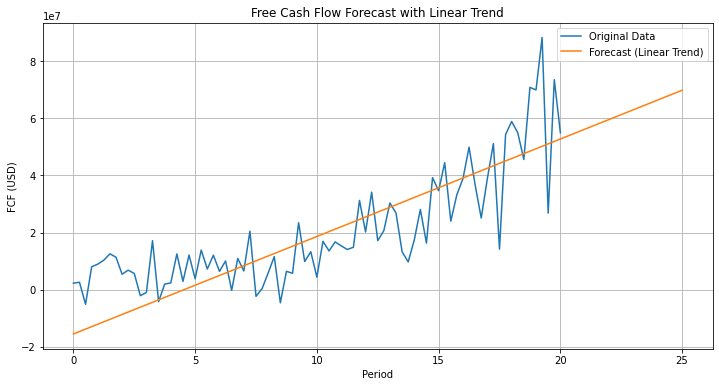

[*********************100%***********************]  1 of 1 completed


short Debt: $16,800,000.00
long Debt: $918,400,000.00
capital oblig Debt: $108,800,000.00
Total Debt: $1,044,000,000.00
Cost of Equity (Re): 13.67%
0.012260536398467433
WACC for RBC: 12.69%


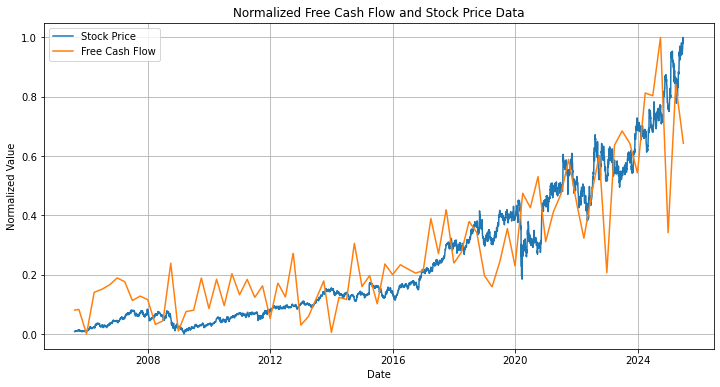


Fiscal Date Ending 2025-03-31
PV of future cash flows for RBC with i = 4.5%:
0.002699455577156189
with margin of safety of 20%:
0.0021595644617249513
Current Market Capitalization:
0.012506199725354003
Market Cap => Safety
Today Price: 397.3299865722656
Fair Price: 68.61888868103026
-82.73%




Fiscal Date Ending 2025-03-31


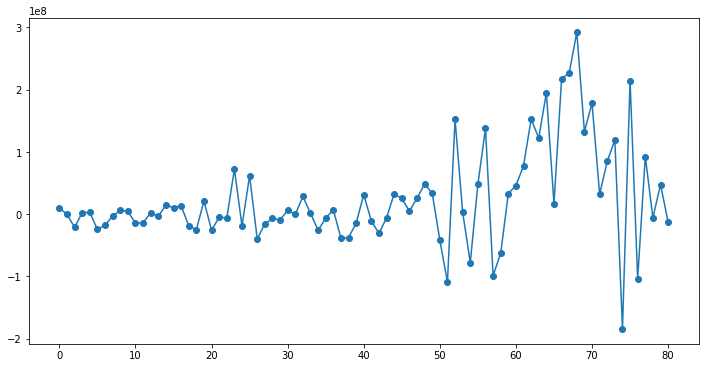

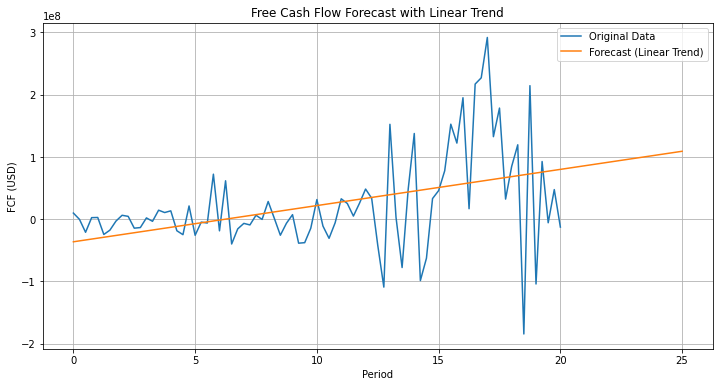

[*********************100%***********************]  1 of 1 completed


short Debt: $387,131,000.00
long Debt: $1,692,548,000.00
capital oblig Debt: $1,086,966,000.00
Total Debt: $3,166,645,000.00
Cost of Equity (Re): 11.07%
0.012695771076328417
WACC for KNX: 8.00%


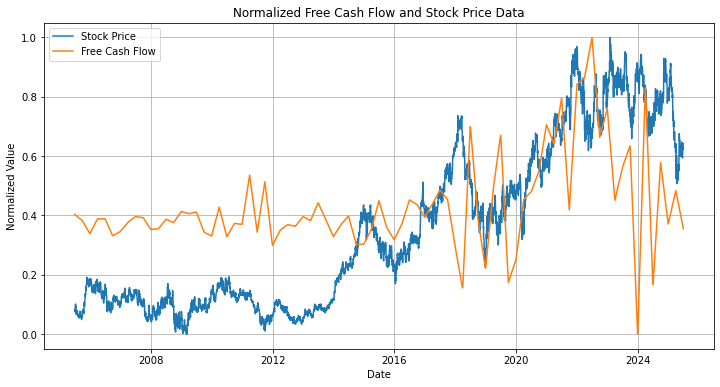


Fiscal Date Ending 2025-03-31
PV of future cash flows for KNX with i = 4.5%:
0.008040626605569118
with margin of safety of 20%:
0.006432501284455295
Current Market Capitalization:
0.007237152975273132
Market Cap => Safety
Today Price: 44.65999984741211
Fair Price: 39.693807864379885
-11.12%




Fiscal Date Ending 2025-03-31


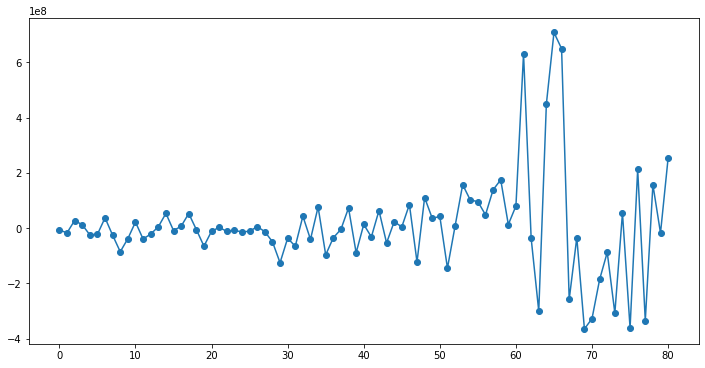

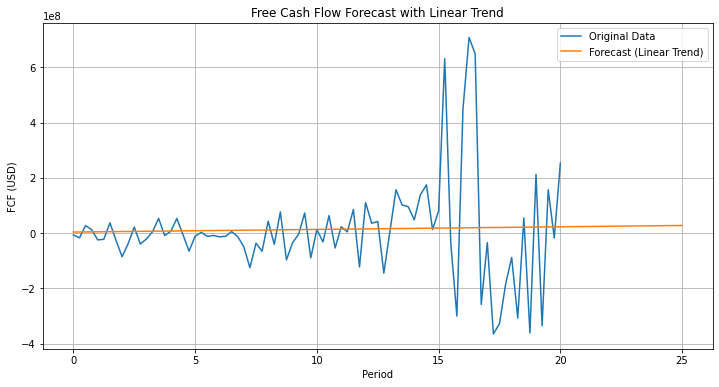

[*********************100%***********************]  1 of 1 completed


short Debt: $5,042,900,000.00
long Debt: $8,261,800,000.00
capital oblig Debt: $596,900,000.00
Total Debt: $13,901,600,000.00
Cost of Equity (Re): 12.52%
0.013487656097139897
WACC for LAD: 5.25%


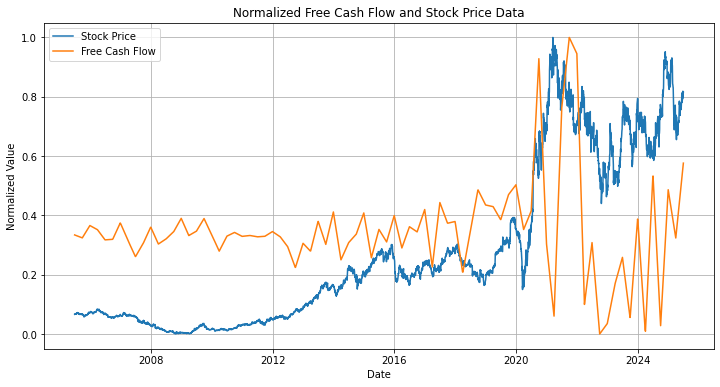


Fiscal Date Ending 2025-03-31
PV of future cash flows for LAD with i = 4.5%:
0.003226287050036633
with margin of safety of 20%:
0.0025810296400293063
Current Market Capitalization:
0.00801091715
Market Cap => Safety
Today Price: 307.75
Fair Price: 99.15705000000001
-67.78%




Fiscal Date Ending 2025-03-31


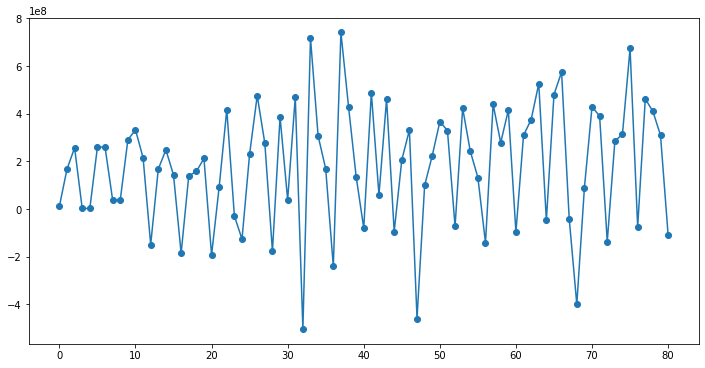

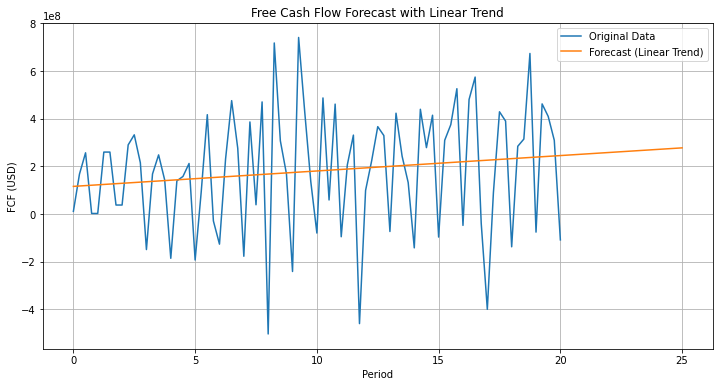

[*********************100%***********************]  1 of 1 completed


short Debt: $0.00
long Debt: $964,800,000.00
capital oblig Debt: $0.00
Total Debt: $964,800,000.00
Cost of Equity (Re): 12.39%
0.013577943615257049
WACC for IVZ: 11.29%


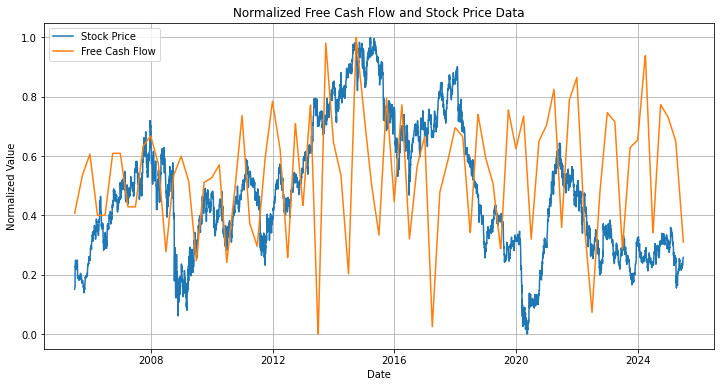


Fiscal Date Ending 2025-03-31
PV of future cash flows for IVZ with i = 4.5%:
0.011326927721011652
with margin of safety of 20%:
0.009061542176809321
Current Market Capitalization:
0.008915315554145813
Market Cap => Safety
Today Price: 19.920000076293945
Fair Price: 20.246688077545166
1.64%




Fiscal Date Ending 2025-04-30


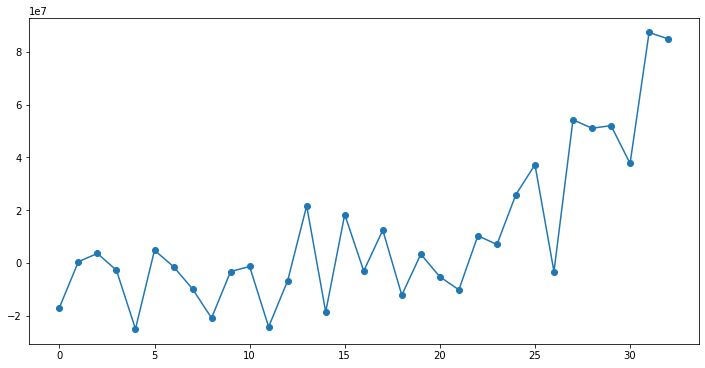

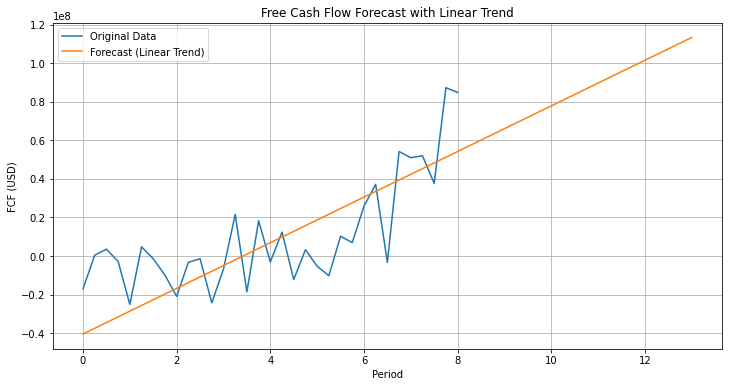

[*********************100%***********************]  1 of 1 completed


short Debt: $17,856,000.00
long Debt: $569,729,000.00
capital oblig Debt: $25,285,000.00
Total Debt: $612,870,000.00
Cost of Equity (Re): 10.39%
0.009535464290958931
WACC for ESTC: 9.79%


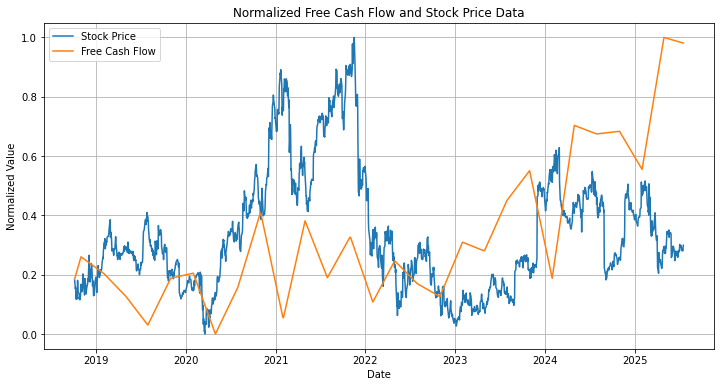


Fiscal Date Ending 2025-04-30
PV of future cash flows for ESTC with i = 4.5%:
0.00772257998195976
with margin of safety of 20%:
0.006178063985567809
Current Market Capitalization:
0.009159382746620178
Market Cap => Safety
Today Price: 86.79000091552734
Fair Price: 58.5398556175232
-32.55%




Fiscal Date Ending 2025-03-31


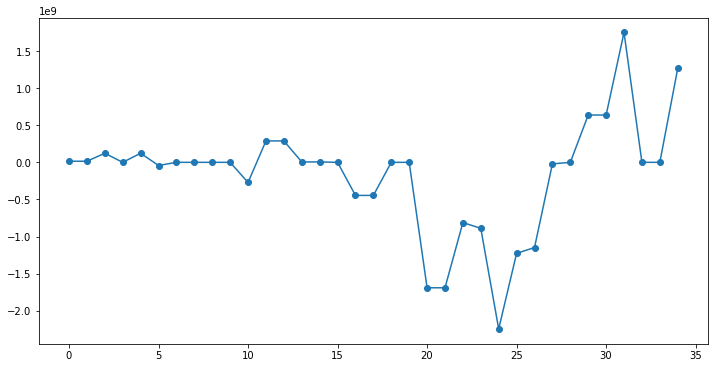

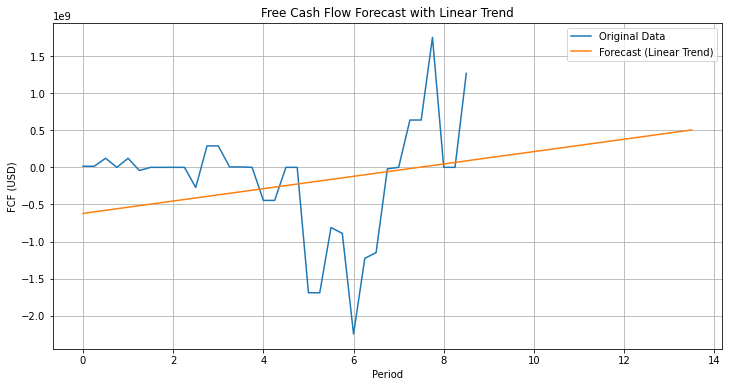

[*********************100%***********************]  1 of 1 completed


KeyError: 'Beta'

In [29]:
FCFAnalysisRecurrent( ['RVMD', 'RBC', 'KNX', 'LAD', 'IVZ', 'ESTC', 'BILI', 'MOS', 'S', 'AR', 'AGNC', 'LNW', 'CROX', 'ITCI', 'OGE', 'EXEL', 'RGEN', 'VOYA', 'FCN', 'MLI', 'UFPI', 'PNFP', 'INFA', 'ALTR', 'PEN', 'LNTH', 'DOCS', 'BERY', 'CHRD', 'BWA', 'SSD', 'ANF', 'KNTK', 'KT', 'AXTA', 'CRS', 'CFR', 'LEGN', 'CBSH', 'CELH', 'ASND', 'ATI', 'ALV', 'FMC', 'SMAR', 'ASTS', 'GIL', 'MASI', 'SSB', 'WTFC', 'HQY', 'AEL', 'BFAM', 'VIPS', 'VFC', 'CIGI', 'COLD', 'AGCO', 'SPXC', 'ZION', 'GXO', 'AMKR', 'MIDD', 'HMY', 'RLI', 'PARAA', 'SUM', 'MTH', 'LEVI', 'TMHC', 'LPX', 'LSCC', 'SAIC', 'FR', 'BOKF', 'BPOP', 'APPF', 'CFLT', 'NSIT', 'RRC', 'IBP', 'PATH', 'SNV', 'ARW', 'STEP', 'SPSC', 'DLB', 'JAZZ', 'KEX', 'OSK', 'TREX', 'BBWI', 'CGNX', 'AXS', 'CCCS', 'PB', 'G', 'TX', 'MKSI', 'RHI', 'SATS', 'GNTX', 'ESAB', 'FAF', 'WTS', 'PLNT', 'LUMN', 'HCP', 'MSA', 'ENLC', 'FRPT', 'CLS', 'CWAN', 'MTG', 'POST', 'AN', 'COTY', 'CRUS', 'VRNS', 'LSTR', 'HR', 'NVEI', 'JHG', 'RH', 'RHP', 'SITE', 'WH', 'CLF', 'EXLS', 'CWST', 'CSWI', 'MAT', 'MTN', 'CYTK', 'R', 'CMC', 'SQSP', 'W', 'MTDR', 'LFUS', 'ELAN', 'NOVT', 'ZWS', 'FRHC', 'AZEK', 'GLBE', 'CHH', 'REYN', 'DDS', 'CBT', 'PEGA', 'KBH', 'IONS', 'TRNO', 'BTG', 'ONB', 'CRDO', 'PKI', 'MDU', 'BILL', 'AWI', 'CVLT', 'VMI', 'LCID', 'COOP', 'CAE', 'PI', 'LEA', 'ESI', 'TKR', 'BMI', 'ELF', 'DAR', 'NOV', 'LAZ', 'INSP', 'RCM', 'CADE', 'SIGI', 'EPRT', 'BEPC', 'BYD', 'BECN', 'ETSY', 'WHR', 'RNA', 'KD', 'OLLI', 'KRG', 'AMG', 'DOOO', 'DY', 'BIPC', 'NFG', 'CACC', 'SKY', 'FSK', 'LYFT', 'EXPO', 'OMF', 'ACT', 'LNC', 'ALK', 'CHX', 'SRCL', 'PVH', 'RITM', 'MMSI', 'BMA', 'SLGN', 'PFSI', 'NXST', 'THG', 'IDA', 'BC', 'MARA', 'STVN', 'FG', 'BCPC', 'OLN', 'BCC', 'AQN', 'ST', 'UGI', 'FSS', 'VNT', 'USM', 'OPCH', 'MMS', 'SEE', 'GBCI', 'BROS', 'GTLS', 'VVV', 'CNS', 'CWEN', 'RKLB', 'PIPR', 'CRVL', 'CNX', 'SWX', 'LTH', 'MC', 'UMBF', 'RDN', 'HOMB', 'ACIW', 'CRNX', 'FNB', 'MSGS', 'FIVE', 'SON', 'MGY', 'CORT', 'KRYS', 'VIRT', 'HXL', 'SMG', 'KRC', 'SLG', 'UBSI', 'DNB', 'TENB', 'OZK', 'NYCB', 'BOOT', 'SLM', 'FCFS', 'RDNT', 'YOU', 'XRAY', 'POR', 'MUR', 'AL', 'QTWO', 'CPRI', 'COLM', 'SNDR', 'SM', 'BBIO', 'BDC', 'BCO', 'CLVT', 'GPI', 'LANC', 'CUZ', 'FLO', 'ACHC', 'RYN', 'WTM', 'VLY', 'MHO', 'AVT', 'FELE', 'HOG', 'GATX', 'UPST', 'TAL', 'WHD', 'ORA', 'MSM', 'TIGO', 'RXO', 'ABG', 'ITRI', 'SHAK', 'SFBS', 'NJR', 'LSI', 'TNET', 'ALKS', 'ACA', 'ALGM', 'HL', 'PII', 'AVNT', 'CRC', 'BOX', 'MATX', 'PECO', 'AGO', 'LITE', 'SMR', 'QLYS', 'OGN', 'SHC', 'HWC', 'WK', 'IRT', 'M', 'ABCB', 'VRRM', 'PRMW', 'PAM', 'SEM', 'ACLLY', 'SIG', 'RMBS', 'BLKB', 'EEFT', 'ICUI', 'SBRA', 'ITGR', 'TPH', 'FUL', 'BKH', 'FIZZ', 'ASH', 'ASGN', 'SSL', 'CPA', 'OGS', 'GDS', 'NCNO', 'TMDX', 'SGRY', 'CRSP', 'CCOI', 'AEIS', 'NNI', 'EAT', 'IGT', 'ENS', 'HUN', 'KMPR', 'GBDC', 'AEO', 'JWN', 'BVN', 'SITM', 'WU', 'SG', 'JOBY', 'FTDR', 'IBOC', 'WEN', 'DOCN', 'VCTR', 'ATHM', 'ALIT', 'CLBT', 'OSCR', 'DNLI', 'PBF', 'ASO', 'ROAD', 'HGV', 'HHC', 'HAE', 'LOPE', 'UA', 'UAA', 'LPL', 'ZI', 'IDCC', 'IPAR', 'HIW', 'INTA', 'GOLF', 'SKYW', 'EGO', 'SCPL', 'CNO', 'DXC', 'FLNC', 'SKT', 'AX', 'IIPR', 'APAM', 'SR', 'SLAB', 'BANF', 'PLXS', 'GMS', 'KTOS', 'IRDM', 'NOG', 'GBTG', 'EBC', 'MCY', 'ALE', 'HCM', 'VAL', 'EPR', 'SPR', 'CVCO', 'SANM', 'TFSL', 'KFY', 'TGLS', 'BL', 'TCBI', 'POWI', 'BRC', 'HGTY', 'APLE', 'UNF', 'ALKT', 'PBH', 'MRUS', 'GVA', 'AXNX', 'DORM', 'GSHD', 'PRCT', 'SLVM', 'FOLD', 'SHOO', 'CNK', 'NHI', 'STR', 'MWA', 'SAM', 'AUB', 'JOE', 'PCH', 'ENV', 'STNE', 'NWE', 'AGYS', 'ABM', 'PRGO', 'INST', 'ASB', 'URBN', 'HP', 'IAG', 'FBP', 'NSA', 'FRSH', 'APLS', 'WDFC', 'STNG', 'XENE', 'FORM', 'PRIM', 'FROG', 'MGEE', 'HAYW', 'FIBK', 'MIR', 'CRK', 'IPGP', 'GFF', 'SXT', 'CATY', 'SMPL', 'LSPD', 'PAY', 'DFH', 'SMTC', 'NSP', 'FULT', 'OTTR', 'NPO', 'JJSF', 'NWL', 'TNL', 'HCC', 'RUN', 'CARG', 'TDW', 'AI', 'YETI', 'ESE', 'ICFI', 'PATK', 'CCS', 'NMIH', 'DEI', 'ATKR', 'AWR', 'CBU', 'AMED', 'PAYO', 'CNXC', 'OUT', 'GEF', 'CEIX', 'SBSW', 'CWT', 'REZI', 'LCII', 'NEOG', 'JBT', 'MLCO', 'FHB', 'PTEN', 'BTU', 'RNG', 'RYTM', 'BRZE', 'MAN', 'TDS', 'WSFS', 'CWK', 'MP', 'GNW', 'AG', 'ACLS', 'PTCT', 'TEX', 'MPW', 'RIOT', 'AVA', 'KYMR', 'BHF', 'APE', 'DIOD', 'BHC', 'DV', 'WAFD', 'NOMD', 'CC', 'SEB', 'COMP', 'RELY', 'SFNC', 'TRN', 'KWR', 'ABR', 'FA', 'PENN', 'BBAR', 'CAR', 'CRGY', 'TBBK', 'PSMT', 'SYNA', 'CDE', 'PRGS', 'ERO', 'PLTK', 'DBRG', 'ASAN', 'LRN', 'JBLU', 'MANU', 'TGNA', 'SNEX', 'VAC', 'BKU', 'FCPT', 'ATGE', 'HUBG', 'TWST', 'QDEL', 'CPK', 'CVBF', 'MEOH', 'AMR', 'WLY', 'UE', 'ZLAB', 'MGRC', 'BOH', 'PAGS', 'AMRX', 'ALRM', 'GPOR', 'MQ', 'VCYT', 'PLUS', 'QS', 'HBI', 'GH', 'GDRX', 'INDB', 'AGIO', 'PPBI', 'NARI', 'HNI', 'VSTO', 'MTX', 'CALX', 'PYCR', 'ARCH', 'SPB', 'AY', 'PFS', 'HTLF', 'PLMR', 'ACAD', 'VC', 'NMRK', 'BATRA', 'CPRX', 'IBTX', 'EE', 'RPD', 'VSH', 'FFBC', 'DLO', 'AMPH', 'GT', 'UTZ', 'ARCB', 'MBC', 'CRI', 'KLIC', 'LAUR', 'BANC', 'DRVN', 'AMBA', 'OSIS', 'CRTO', 'EPAC', 'ADUS', 'AAP', 'B', 'NABL', 'ENR', 'AZZ', 'WERN', 'FL', 'AIN', 'YELP', 'KSS', 'TNDM', 'BE', 'TRUP', 'WB', 'NFE', 'SWTX', 'BANR', 'KROS', 'FBK', 'ENVA', 'FIVN', 'APPN', 'VZIO', 'FRME', 'AVPT', 'ZD', 'BKE', 'TR', 'AIR', 'LOB', 'PAR', 'PTON', 'CSTM', 'MTRN', 'FLYW', 'CAKE', 'SGML', 'THS', 'STRA', 'AKRO', 'PTVE', 'VSCO', 'NBTB', 'TRIP', 'NTLA', 'RNST', 'PRVA', 'EVTC', 'GEO', 'VET', 'MCW', 'JAMF', 'MRVI', 'CCU', 'WOR', 'CENT', 'TFIN', 'SHO', 'TTMI', 'NUVA', 'HTH', 'MSGE', 'VIAV', 'ROCK', 'MBIN', 'MRCY', 'WNS', 'OI', 'CNMD', 'MYRG', 'VCEL', 'PRG', 'WOLF', 'PINC', 'GLPG', 'CABO', 'RXRX', 'LMAT', 'ENVX', 'HRMY', 'KMT', 'SEMR', 'KOS', 'VVX', 'HI', 'ADNT', 'EFSC', 'WRBY', 'CMPR', 'EVCM', 'PLUG', 'DNUT', 'DFIN', 'EXPI', 'CWH', 'STC', 'BEAM', 'SJW', 'ROG', 'LGND', 'GNL', 'TSLX', 'CNXN', 'SAH', 'SYBT', 'DCBO', 'HURN', 'YY', 'NUV', 'OMCL', 'NHC', 'SIMO', 'HEES', 'WSBC', 'RVLV', 'CLDX', 'BCYC', 'NVCR', 'ARVN', 'TXG', 'VICR', 'CXM', 'CERT', 'CLBK', 'LEG', 'FBNC', 'KAR', 'PZZA', 'WMK', 'PD', 'FCF', 'EPC', 'TNC', 'CHCO', 'TALO', 'WGO', 'MLKN', 'NEO', 'NWBI', 'VECO', 'APOG', 'GTY', 'NAVI', 'IMCR', 'LZB', 'AAT', 'CMRE', 'FOXF', 'LKFN', 'RCKT', 'GO', 'SCL', 'STER', 'RCUS', 'TDOC', 'SNDX', 'AMRC', 'RAMP', 'UCTT', 'CHEF', 'HE', 'SFL', 'CODI', 'NBHC', 'ANDE', 'VRE', 'COCO', 'GETY', 'HLIO', 'NVAX', 'GBX', 'INFN', 'DAN', 'JBGS', 'NAPA', 'MLNK', 'SPT', 'HOPE', 'VRTS', 'DAVA', 'BCRX', 'AMC', 'NWN', 'SONO', 'LTC', 'ULCC', 'CDRE', 'AMN', 'HELE', 'IART', 'WOOF', 'NTCT', 'NSSC', 'MTTR', 'NVEE', 'STAA', 'PEB', 'XNCR', 'PGNY', 'BB', 'SRCE', 'STBA', 'XHR', 'HMN', 'PLAB', 'JBI', 'ZUO', 'GOOS', 'TIXT', 'VBTX', 'UMH', 'SCS', 'TCBK', 'CUBI', 'BUSE', 'SASR', 'CTS', 'CRCT', 'MMI', 'BLMN', 'PLAY', 'AFYA', 'CSGS', 'TLRY', 'DVAX', 'TWKS', 'VSAT', 'VRNT', 'LC', 'FDP', 'ATRC', 'MCRI', 'KRO', 'SAVA', 'WABC', 'KURA', 'OLPX', 'RES', 'PDM', 'WWW', 'UNIT', 'RDFN', 'TVTX', 'TWO', 'MGPI', 'UPWK', 'INMD', 'TV', 'ALEX', 'XRX', 'IMTX', 'GIC', 'CET', 'DNOW', 'MRTN', 'LMND', 'DAWN', 'BRDG', 'OPEN', 'COMM', 'COGT', 'SDGR', 'CIM', 'SBH', 'THRM', 'MFA', 'PBI', 'NTST', 'UNFI', 'USPH', 'ANGI', 'IQ', 'CDNA', 'LNN', 'NGVT', 'OXM', 'SSRM', 'PX', 'NMFC', 'INVA', 'UDMY', 'SAFT', 'DQ', 'UVV', 'ARI', 'AGL', 'EIG', 'LZ', 'RC', 'IMKTA', 'IE', 'BHLB', 'COUR', 'GABC', 'ALGT', 'DCOM', 'ALX', 'JKS', 'GDYN', 'MOMO', 'KALU', 'XPEL', 'MSEX', 'AGRO', 'BRP', 'CAL', 'KRNT', 'TGI', 'TRS', 'LOMA', 'FBRT', 'EVRI', 'TIGR', 'SBGI', 'NXRT', 'ACHR', 'ENFN', 'CBRL', 'UXIN', 'DGII', 'FIGS', 'ECPG', 'OCFC', 'IMAX', 'AMPL', 'DK', 'FWRD', 'MD', 'ABB', 'RLAY', 'HIMX', 'PGRU', 'OMI', 'ATEN', 'KFRC', 'BCSF', 'ATSG', 'AVNS', 'ATUS', 'CARS', 'ODP', 'VTLE', 'VIR', 'SBSI', 'XMTR', 'LFG', 'OPK', 'FWRG', 'ARQT', 'RWT', 'FSLY', 'PARR', 'CNOB', 'ACDC', 'HTZ', 'ARR', 'SEDG', 'IGMS', 'AMSF', 'BFS', 'ZIP', 'GES', 'MDRX', 'VTOL', 'FIP', 'BRKL', 'MEG', 'PRO', 'BMBL', 'PLRX', 'HTLD', 'PTLO', 'CSTL', 'MATV', 'CMTG', 'BASE', 'TELL', 'PFC', 'SITC', 'JACK', 'AVO', 'MBUU', 'DLX', 'SEAT', 'CBL', 'AAC', 'ABCL', 'SHLS', 'NOAH', 'PRAA', 'MNRO', 'CSIQ', 'TTGT', 'CYH', 'PRA', 'PUMP', 'PCRX', 'GCI', 'ASIX', 'MNTK', 'ATEC', 'ARKO', 'ICPT', 'FVRR', 'EMBC', 'NBR', 'HUYA', 'HFWA', 'HCSG', 'EYE', 'RSKD', 'CCO', 'SUPV', 'MUX', 'SHEN', 'PUBM', 'GPRE', 'LXRX', 'TH', 'SPTN', 'AXL', 'VTS', 'SCHL', 'CGC', 'INDI', 'RYI', 'NOVA', 'RGR', 'DH', 'BALY', 'HLF', 'HPP', 'IRWD', 'BLDP', 'WRLD', 'MATW', 'CRSR', 'ADPT', 'BGS', 'SLP', 'USNA', 'LPRO', 'CTKB', 'FNKO', 'LXU', 'SNCY', 'MCB', 'CDMO', 'CLNE', 'WLDN', 'CNDT', 'FFWM', 'CVAC', 'MYTE', 'ATEX', 'ROOT', 'JMIA', 'FLGT', 'GTN', 'ALLO', 'RXT', 'CHPT', 'AMPS', 'ARCT', 'CMP', 'LAC', 'DAO', 'RVNC', 'RGNX', 'CLFD', 'PACB', 'FUBO', 'HCAT', 'OFLX', 'NYMT', 'ADTN', 'DIN', 'LESL', 'OTLY', 'QTRX', 'ALEC', 'LX', 'LAND', 'OABI', 'IVR', 'VERV', 'NRC', 'SAGE', 'FNA', 'BIGC', 'OPFI', 'ALLT', 'SENEA', 'SHYF', 'CCCC', 'CCRN', 'CTRA', 'GHRS', 'EWCZ', 'WOW', 'LAZR', 'GRPN', 'WALD', 'BYND', 'CAJ', 'ZIMV', 'PERI', 'MEI', 'CYRX', 'SFIX', 'EHAB', 'FATE', 'AMCX', 'ITOS', 'SNBR', 'APPS', 'REAL', 'AMLX', 'IPI', 'MTLS', 'DSGN', 'NUS', 'FORR', 'EB', 'ASLE', 'ACCD', 'EDIT', 'ENTA', 'BARK', 'FF', 'TTEC', 'NKTR', 'QRTEA', 'CDXS', 'IRBT', 'MVIS', 'ONL', 'QBTS', 'RMAX', 'TBI', 'MODV', 'ZNTL', 'SPCE', 'GOSS', 'BLNK', 'ORGN', 'TPIC', 'NVRO', 'GPRO', 'SKIN', 'CDLX', 'FCNCA', 'NKLA', 'SGMO', 'BZUN', 'RILY', 'FCEL', 'MX', 'NRDY', 'VTYX', 'CHGG', 'SAVE', 'EXFY', 'BKKT', 'FREY', 'INO', 'DOUG', 'CURI', 'SKIL', 'VERU', 'CRNC', 'GRWG', 'IMAB', 'ME', 'SSSS', 'WRK', 'AMK', 'SBNY', 'SST', 'INT', 'STEM', 'GOEV', 'MAXN', 'PETS', 'FLT', 'HRT', 'XGN', 'FRG', 'FGEN', 'PEAK', 'ABC', 'RE', 'WKHS', 'TXMD', 'SRC', 'CUTR', 'BKI', 'HYZN', 'PNM', 'BNL', 'ELMSQ', 'SIX', 'NXGN', 'FREQ', 'MBT', 'LTHM', 'GET', 'RRR', 'STAR', 'MGI', 'DISH', 'RAD', 'CHS'])




Fiscal Date Ending 2025-06-30


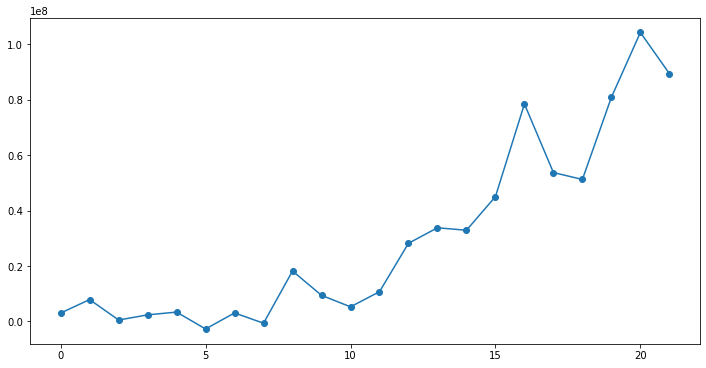

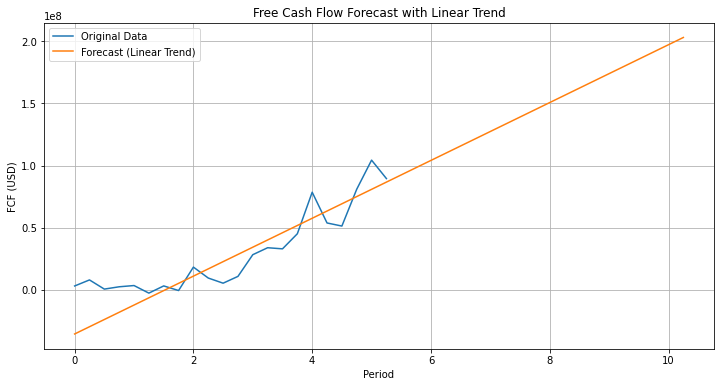

[*********************100%***********************]  1 of 1 completed


short Debt: $2,962,000.00
long Debt: $0.00
capital oblig Debt: $93,843,000.00
Total Debt: $96,805,000.00
Cost of Equity (Re): 9.19%
0.0
WACC for DUOL: 9.12%


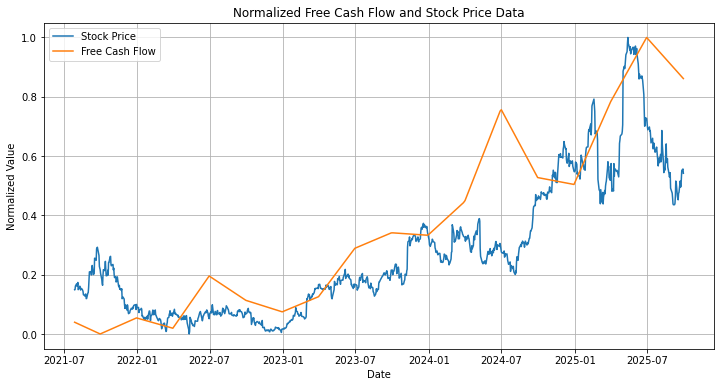


Fiscal Date Ending 2025-06-30
PV of future cash flows for DUOL with i = 4.5%:
0.016164906128679105
with margin of safety of 20%:
0.012931924902943285
Current Market Capitalization:
0.0119667009634552
Market Cap => Safety
Today Price: 301.4700012207031
Fair Price: 325.7986303192139
8.07%




Fiscal Date Ending 2025-06-30


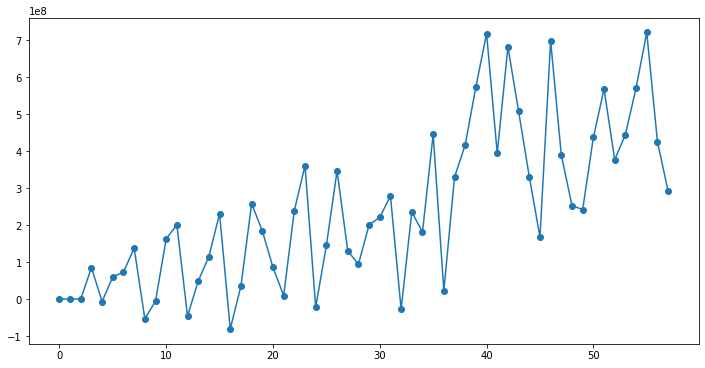

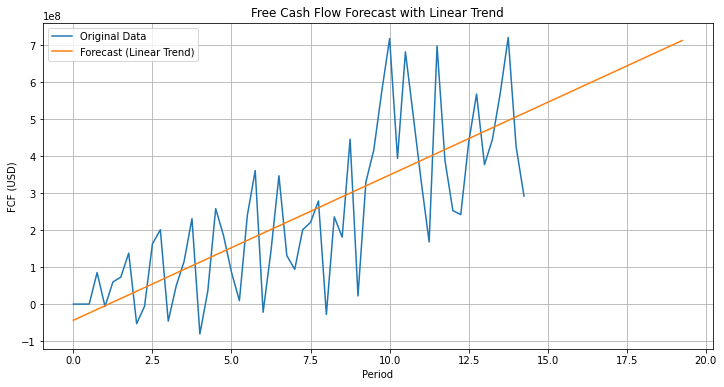

[*********************100%***********************]  1 of 1 completed


short Debt: $1,313,000,000.00
long Debt: $14,177,000,000.00
capital oblig Debt: $210,000,000.00
Total Debt: $15,700,000,000.00
Cost of Equity (Re): 11.79%
0.011592356687898089
WACC for IQV: 8.55%


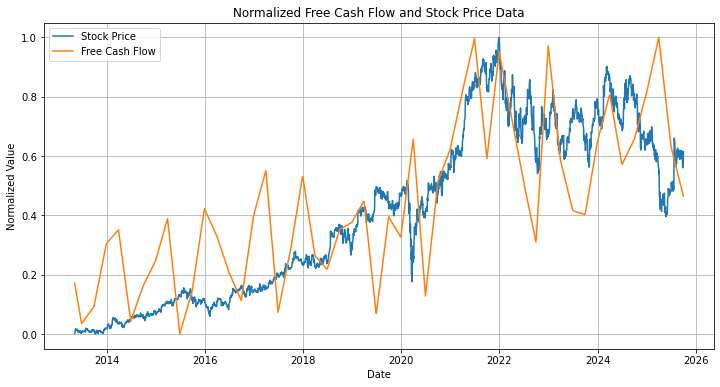


Fiscal Date Ending 2025-06-30
PV of future cash flows for IQV with i = 4.5%:
0.048245104123265894
with margin of safety of 20%:
0.03859608329861272
Current Market Capitalization:
0.03706
Market Cap => Safety
Today Price: 218.0
Fair Price: 227.0252
4.14%




Fiscal Date Ending 2025-07-31


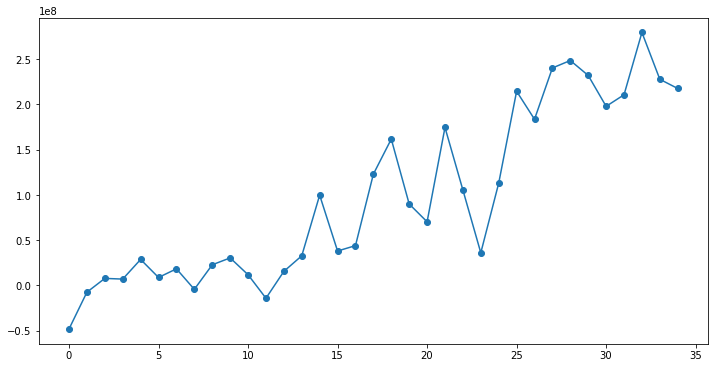

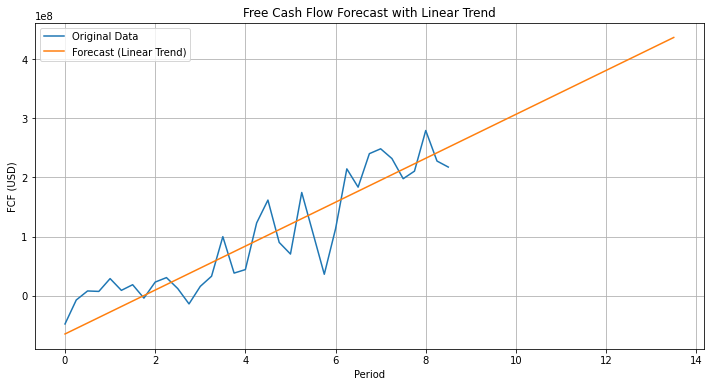

[*********************100%***********************]  1 of 1 completed


short Debt: $21,185,000.00
long Debt: $0.00
capital oblig Debt: $126,942,000.00
Total Debt: $148,127,000.00
Cost of Equity (Re): 10.10%
0.005589797943656457
WACC for DOCU: 10.01%


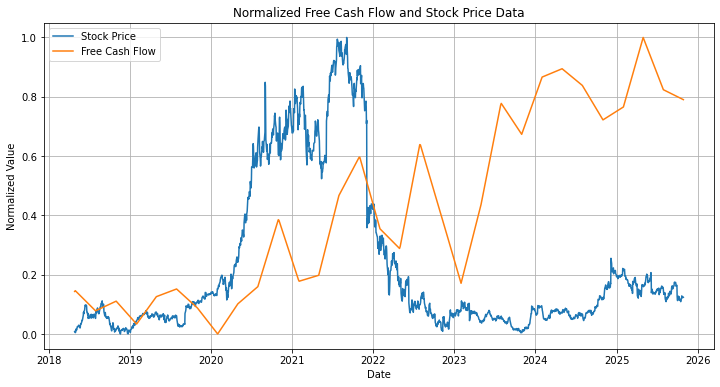


Fiscal Date Ending 2025-07-31
PV of future cash flows for DOCU with i = 4.5%:
0.026772657380955557
with margin of safety of 20%:
0.021418125904764447
Current Market Capitalization:
0.014316594250976563
Market Cap => Safety
Today Price: 71.19000244140625
Fair Price: 106.50024365234376
49.6%




Fiscal Date Ending 2025-09-30


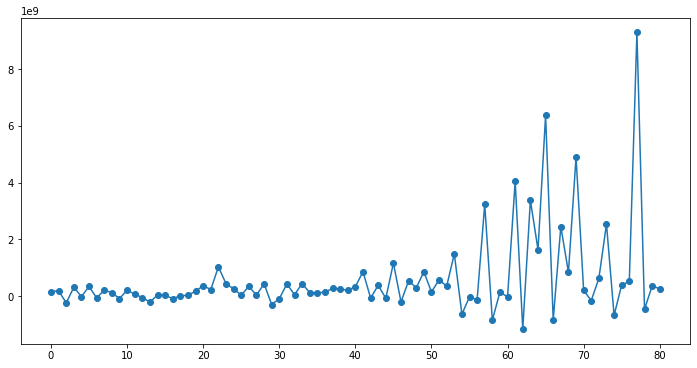

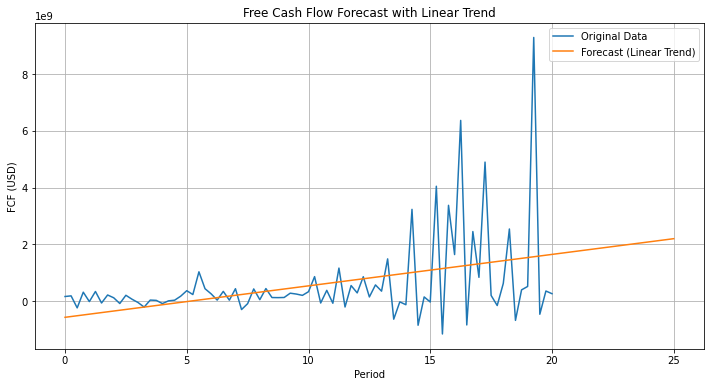

[*********************100%***********************]  1 of 1 completed


short Debt: $0.00
long Debt: $0.00
capital oblig Debt: $0.00
Total Debt: $0.00
Cost of Equity (Re): 11.52%


ZeroDivisionError: float division by zero

In [2]:
FCFAnalysisRecurrent(['DUOL', 'IQV', 'DOCU','ASML','INTC','ORCL','FRSH','STZ','CRWD','DUOL','APH','WCN','AME','PH','CME'])



Fiscal Date Ending 2025-06-30


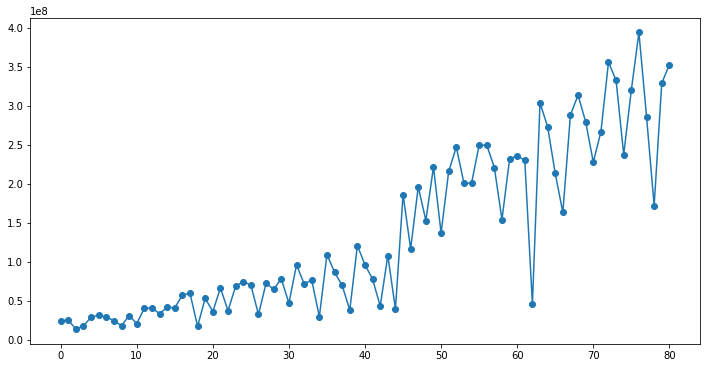

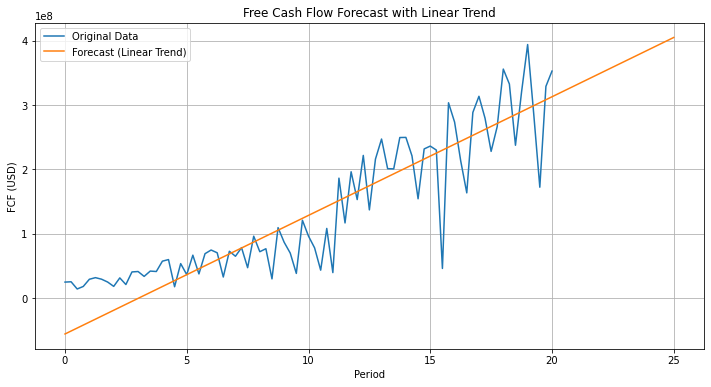

[*********************100%***********************]  1 of 1 completed


short Debt: $50,521,000.00
long Debt: $8,337,178,000.00
capital oblig Debt: $320,877,000.00
Total Debt: $8,708,576,000.00
Cost of Equity (Re): 7.83%
0.009261961886765414
WACC for WCN: 6.68%


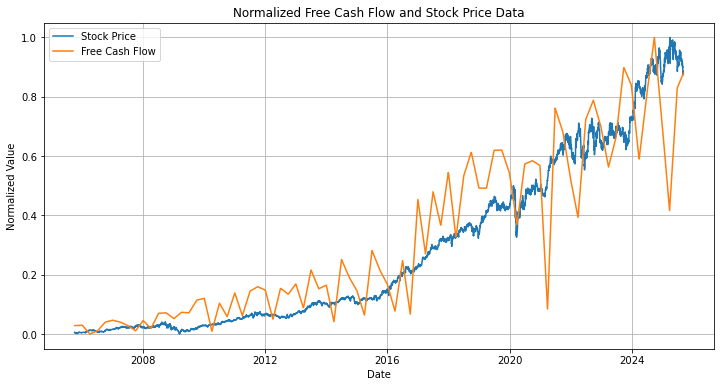


Fiscal Date Ending 2025-06-30
PV of future cash flows for WCN with i = 4.5%:
0.036815221287497646
with margin of safety of 20%:
0.029452177029998118
Current Market Capitalization:
0.04527006386315918
Market Cap => Safety
Today Price: 176.07000732421875
Fair Price: 114.55114676513674
-34.94%




Fiscal Date Ending 2025-06-30


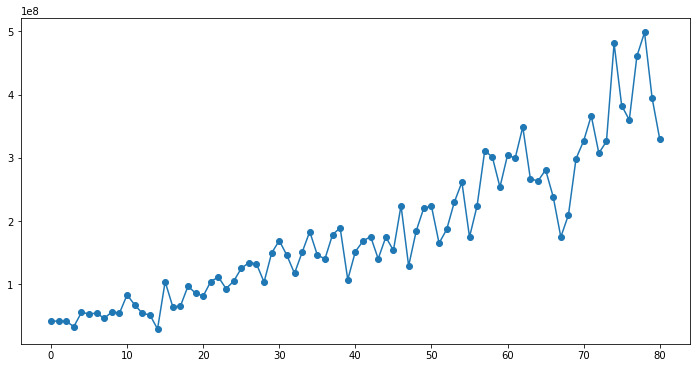

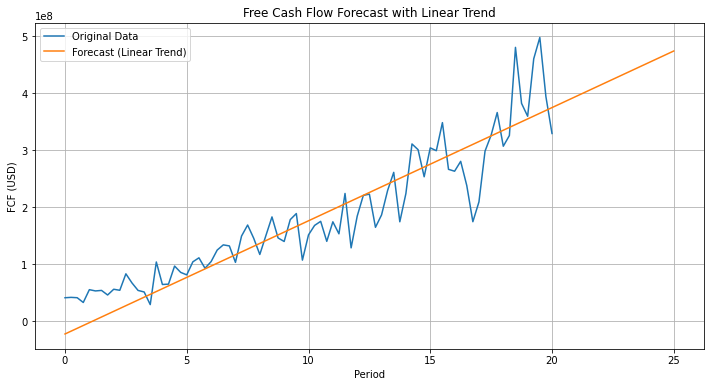

[*********************100%***********************]  1 of 1 completed


short Debt: $407,651,000.00
long Debt: $1,534,347,000.00
capital oblig Debt: $0.00
Total Debt: $1,941,998,000.00
Cost of Equity (Re): 10.55%
0.008680235510026273
WACC for AME: 10.13%


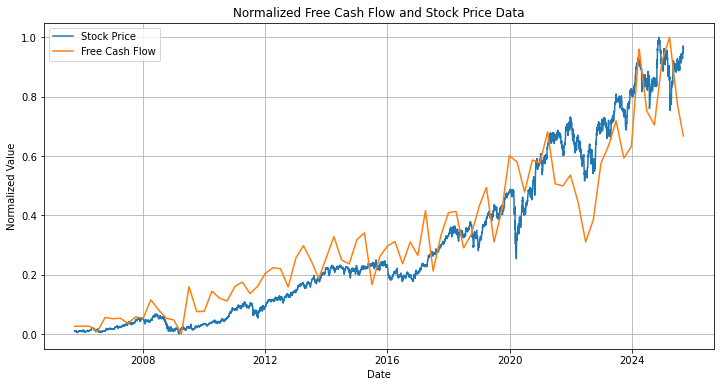


Fiscal Date Ending 2025-06-30
PV of future cash flows for AME with i = 4.5%:
0.023895318041667432
with margin of safety of 20%:
0.019116254433333948
Current Market Capitalization:
0.04386509152844238
Market Cap => Safety
Today Price: 189.92999267578125
Fair Price: 82.77149080810547
-56.42%




Fiscal Date Ending 2025-06-30


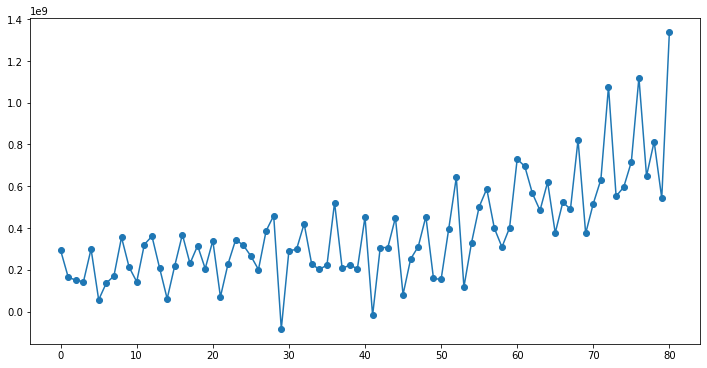

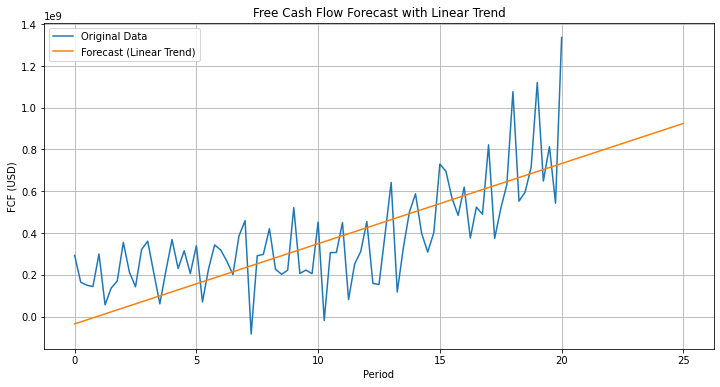

[*********************100%***********************]  1 of 1 completed


short Debt: $1,791,000,000.00
long Debt: $7,494,000,000.00
capital oblig Debt: $0.00
Total Debt: $9,285,000,000.00
Cost of Equity (Re): 11.91%
0.010662358642972537
WACC for PH: 10.94%


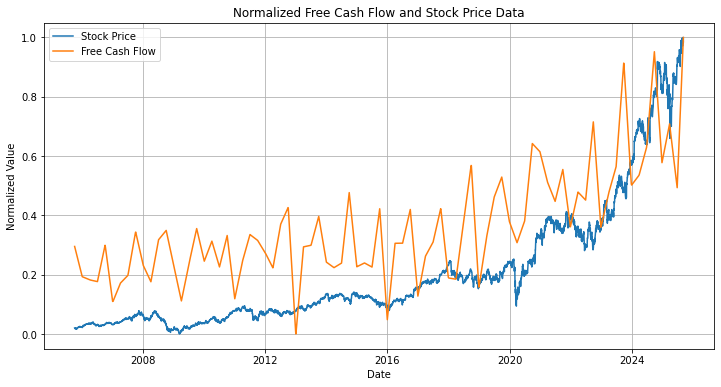


Fiscal Date Ending 2025-06-30
PV of future cash flows for PH with i = 4.5%:
0.042123108272966045
with margin of safety of 20%:
0.03369848661837284
Current Market Capitalization:
0.09612377167138672
Market Cap => Safety
Today Price: 758.780029296875
Fair Price: 266.0282782714844
-64.94%




Fiscal Date Ending 2025-06-30


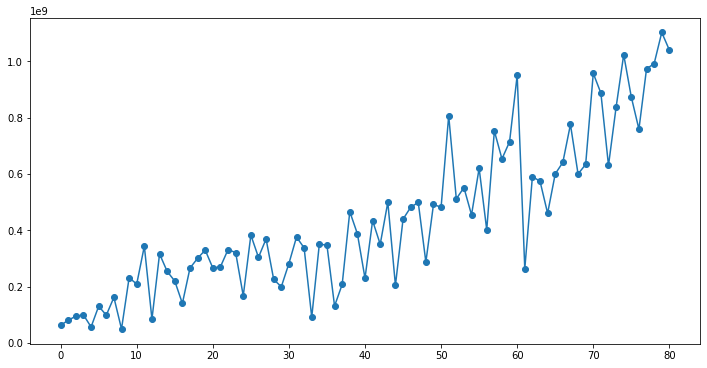

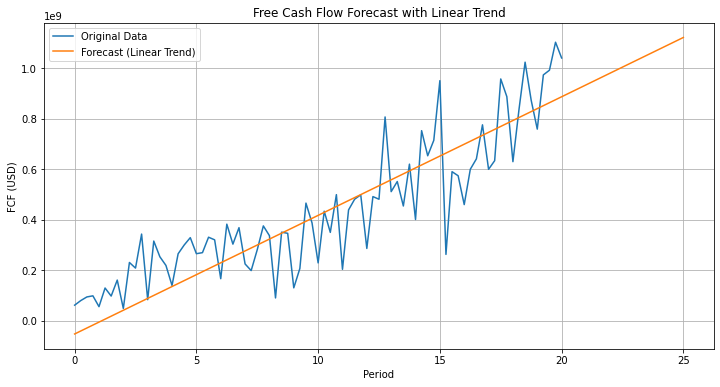

[*********************100%***********************]  1 of 1 completed


short Debt: $0.00
long Debt: $3,420,400,000.00
capital oblig Debt: $0.00
Total Debt: $3,420,400,000.00
Cost of Equity (Re): 6.94%
0.012863992515495264
WACC for CME: 6.73%


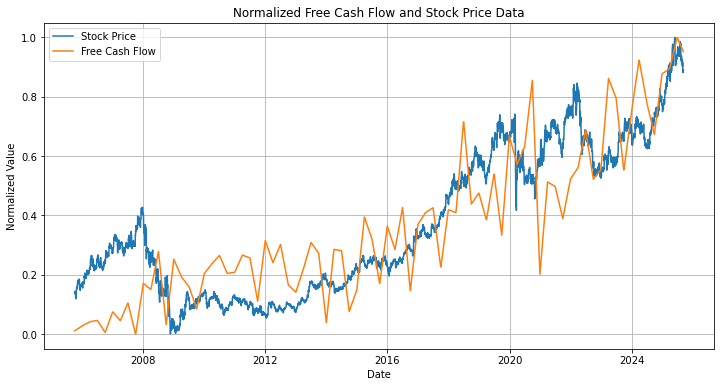


Fiscal Date Ending 2025-06-30
PV of future cash flows for CME with i = 4.5%:
0.09822478489599737
with margin of safety of 20%:
0.0785798279167979
Current Market Capitalization:
0.0945268827008667
Market Cap => Safety
Today Price: 262.29998779296875
Fair Price: 218.0499798522949
-16.87%




Fiscal Date Ending 2025-06-30


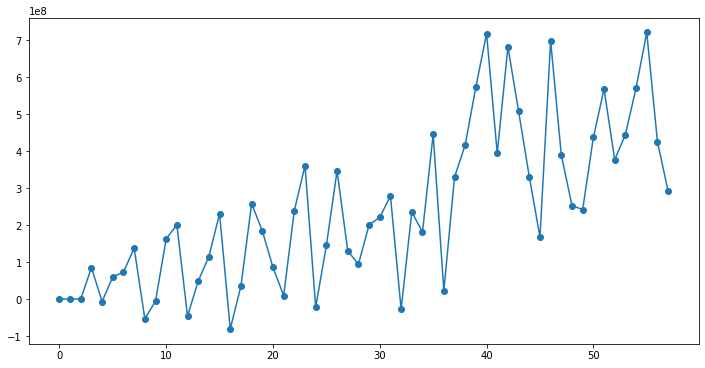

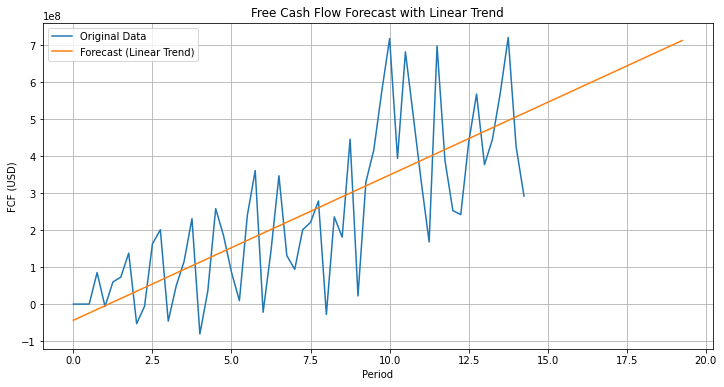

[*********************100%***********************]  1 of 1 completed


short Debt: $1,313,000,000.00
long Debt: $14,177,000,000.00
capital oblig Debt: $210,000,000.00
Total Debt: $15,700,000,000.00
Cost of Equity (Re): 11.78%
0.011592356687898089
WACC for IQV: 8.19%


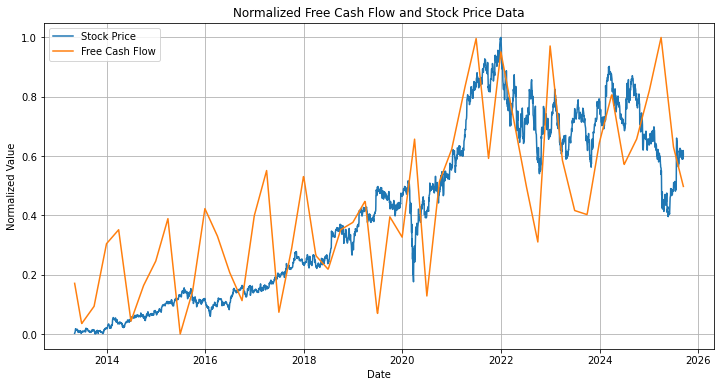


Fiscal Date Ending 2025-06-30
PV of future cash flows for IQV with i = 4.5%:
0.05131534460131001
with margin of safety of 20%:
0.04105227568104801
Current Market Capitalization:
0.03182740020751953
Market Cap => Safety
Today Price: 187.22000122070312
Fair Price: 241.4763575744629
28.98%




Fiscal Date Ending 2025-06-30


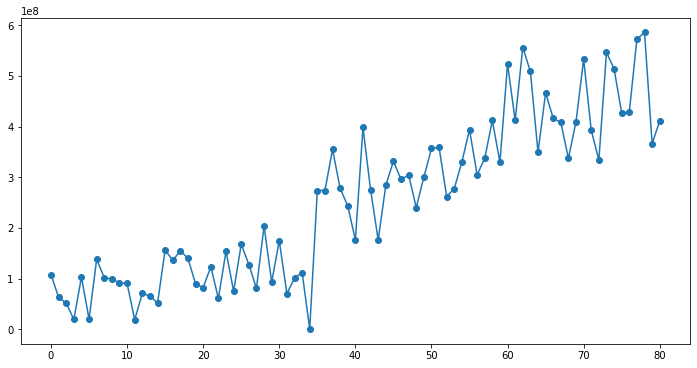

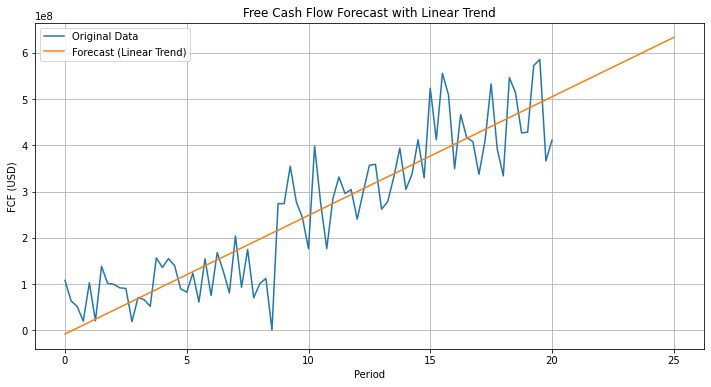

[*********************100%***********************]  1 of 1 completed


short Debt: $167,535,000.00
long Debt: $3,574,761,000.00
capital oblig Debt: $668,932,000.00
Total Debt: $4,411,228,000.00
Cost of Equity (Re): 7.76%
0.007622820674877835
WACC for GIB: 6.38%


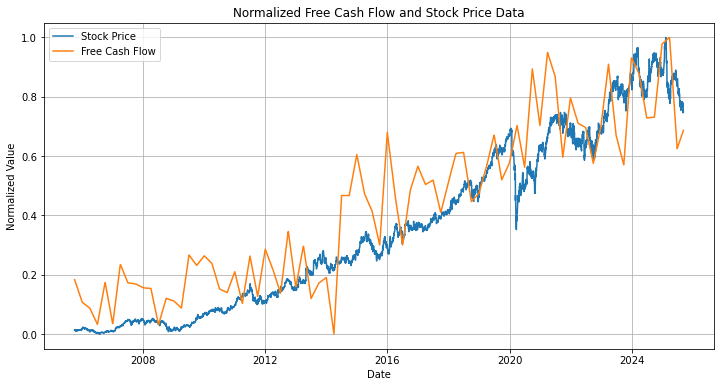


Fiscal Date Ending 2025-06-30
PV of future cash flows for GIB with i = 4.5%:
0.05917381160669743
with margin of safety of 20%:
0.04733904928535795
Current Market Capitalization:
0.01855154933933258
Market Cap => Safety
Today Price: 93.31999969482422
Fair Price: 238.13397522125246
155.18%




Fiscal Date Ending 2025-06-30


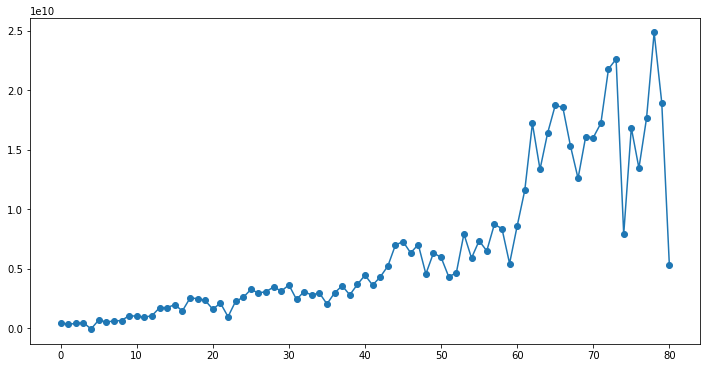

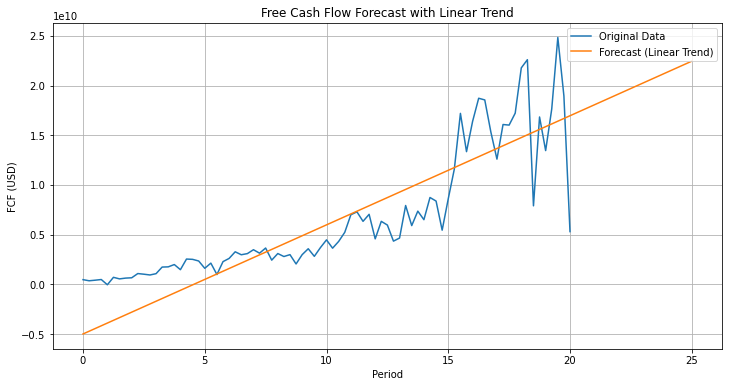

[*********************100%***********************]  1 of 1 completed


KeyError: 'Beta'

In [5]:
FCFAnalysisRecurrent(['WCN','AME','PH','CME','IQV','GIB','GOOGL','DUOL'])



Fiscal Date Ending 2025-06-30


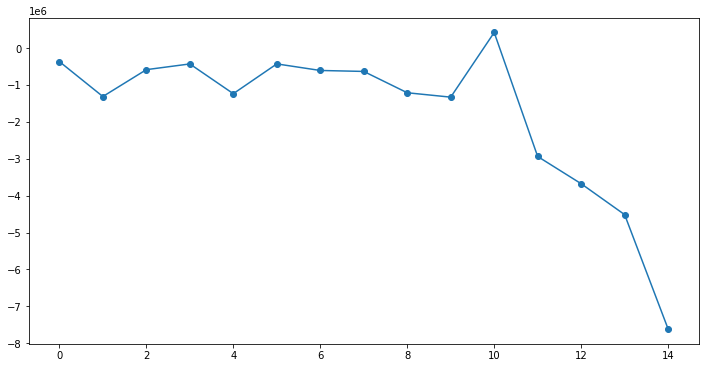

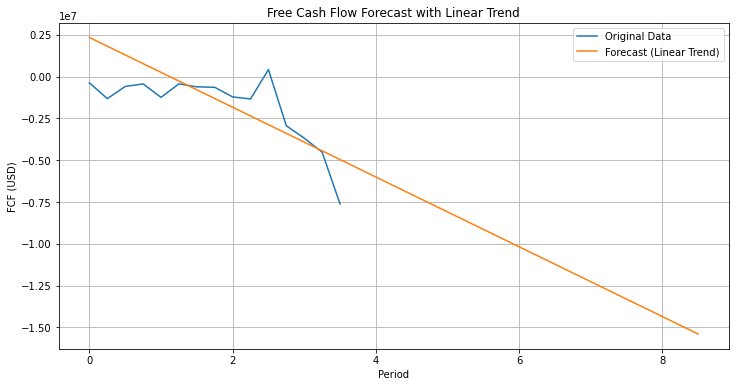

[*********************100%***********************]  1 of 1 completed


ValueError: could not convert string to float: 'None'

In [8]:

FCFAnalysisRecurrent(['RR','GOOGL','DUOL','GIB','IQV','QLYS','ZM'])




Fiscal Date Ending 2025-06-30


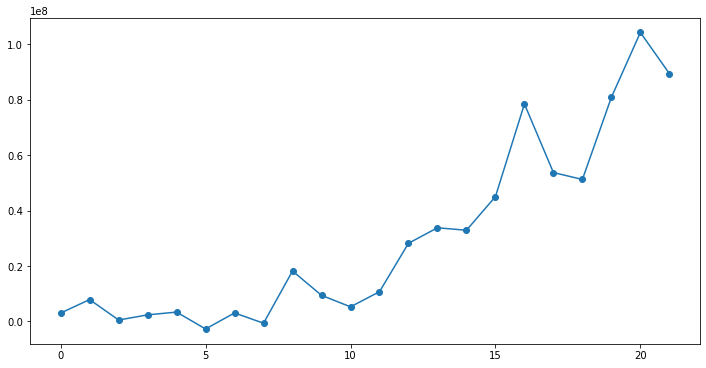

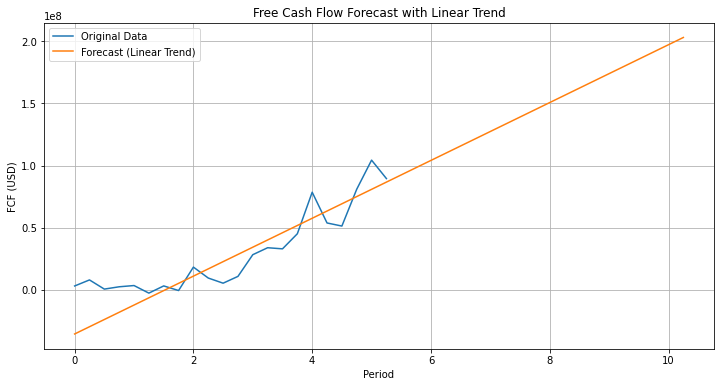

[*********************100%***********************]  1 of 1 completed


short Debt: $2,962,000.00
long Debt: $0.00
capital oblig Debt: $93,843,000.00
Total Debt: $96,805,000.00
Cost of Equity (Re): 9.19%
0.0
WACC for DUOL: 9.12%


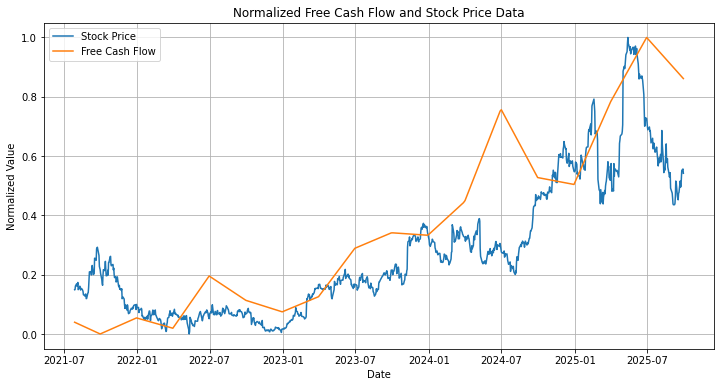


Fiscal Date Ending 2025-06-30
PV of future cash flows for DUOL with i = 4.5%:
0.016150575143622736
with margin of safety of 20%:
0.01292046011489819
Current Market Capitalization:
0.0128066367288208
Market Cap => Safety
Today Price: 322.6300048828125
Fair Price: 325.5014119262695
0.89%




Fiscal Date Ending 2025-06-30


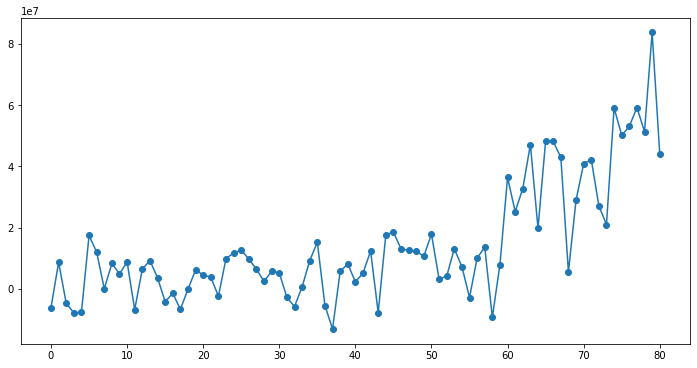

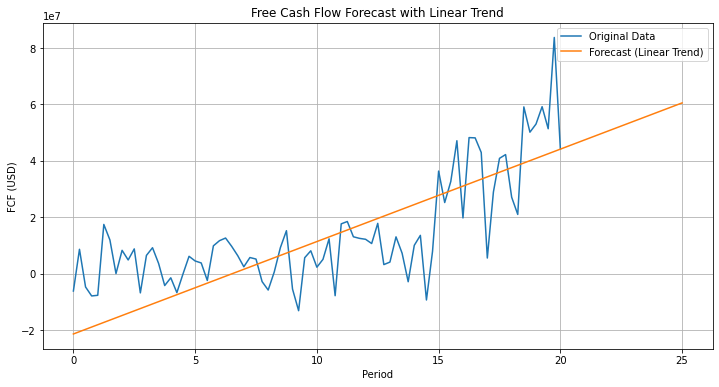

[*********************100%***********************]  1 of 1 completed


short Debt: $5,251,000.00
long Debt: $0.00
capital oblig Debt: $13,409,000.00
Total Debt: $18,660,000.00
Cost of Equity (Re): 13.32%
0.0
WACC for ONTO: 13.29%


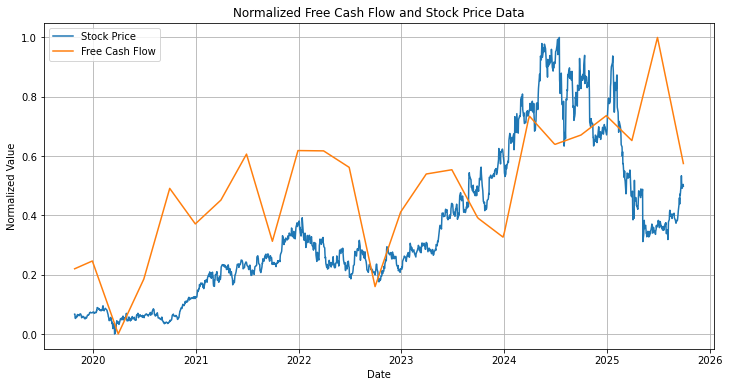


Fiscal Date Ending 2025-06-30
PV of future cash flows for ONTO with i = 4.5%:
0.0022358909771254877
with margin of safety of 20%:
0.0017887127817003902
Current Market Capitalization:
0.007042307685003662
Market Cap => Safety
Today Price: 143.7100067138672
Fair Price: 36.502341705322266
-74.6%




Fiscal Date Ending 2025-07-31


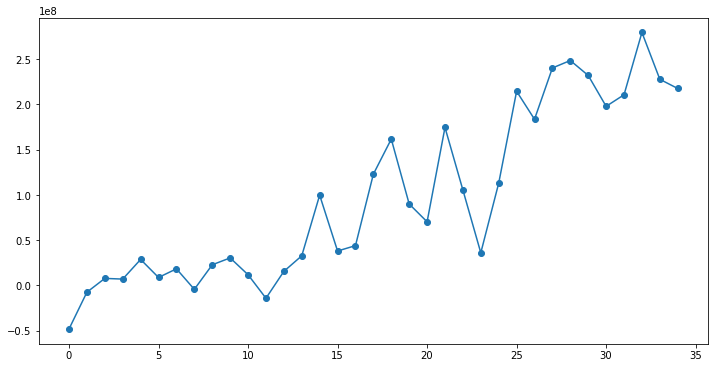

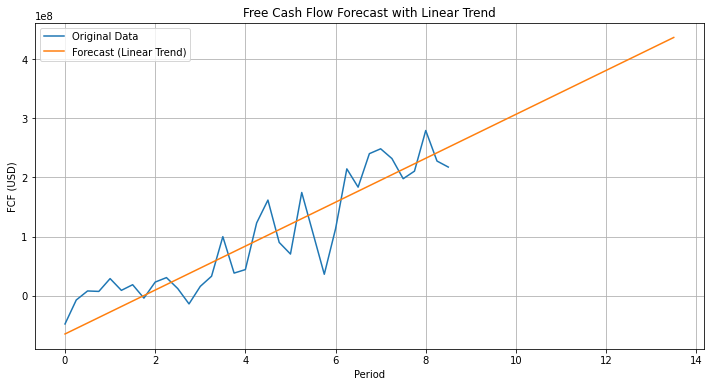

[*********************100%***********************]  1 of 1 completed


short Debt: $21,185,000.00
long Debt: $0.00
capital oblig Debt: $126,942,000.00
Total Debt: $148,127,000.00
Cost of Equity (Re): 10.10%
0.005589797943656457
WACC for DOCU: 10.00%


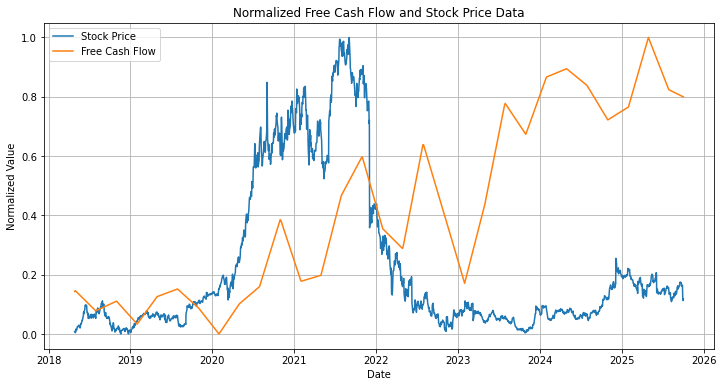


Fiscal Date Ending 2025-07-31
PV of future cash flows for DOCU with i = 4.5%:
0.026781114506573715
with margin of safety of 20%:
0.021424891605258973
Current Market Capitalization:
0.014022982595092773
Market Cap => Safety
Today Price: 69.7300033569336
Fair Price: 106.53349912872315
52.78%




Fiscal Date Ending 2025-06-30


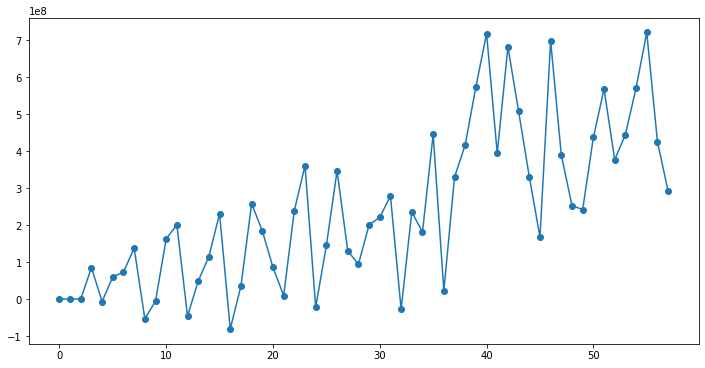

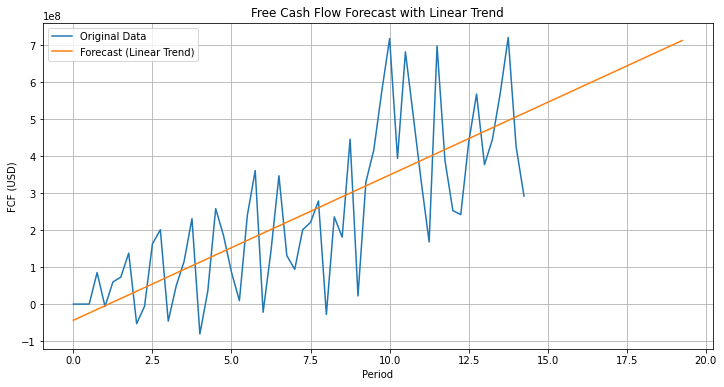

[*********************100%***********************]  1 of 1 completed


short Debt: $1,313,000,000.00
long Debt: $14,177,000,000.00
capital oblig Debt: $210,000,000.00
Total Debt: $15,700,000,000.00
Cost of Equity (Re): 11.79%
0.011592356687898089
WACC for IQV: 8.43%


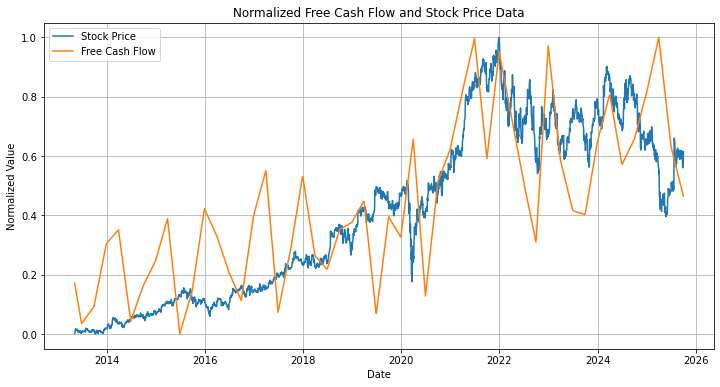


Fiscal Date Ending 2025-06-30
PV of future cash flows for IQV with i = 4.5%:
0.04925612285580044
with margin of safety of 20%:
0.039404898284640354
Current Market Capitalization:
0.035127100830078126
Market Cap => Safety
Today Price: 206.6300048828125
Fair Price: 231.79753947753903
12.18%




Fiscal Date Ending 2025-06-30


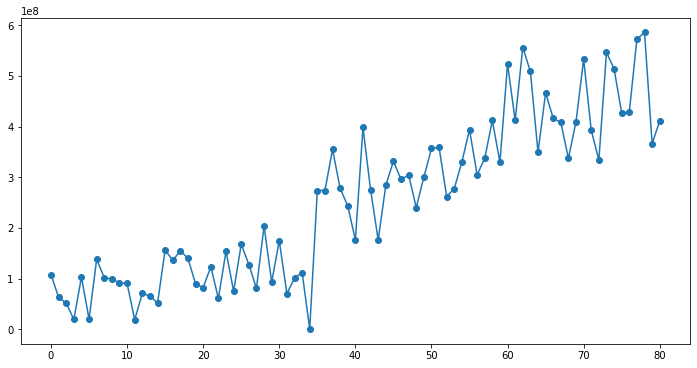

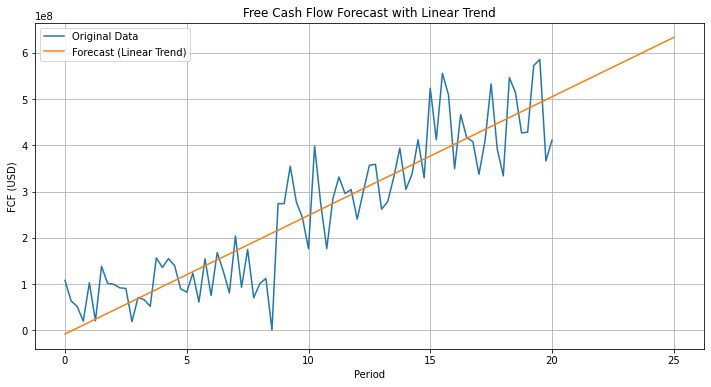

[*********************100%***********************]  1 of 1 completed


short Debt: $167,535,000.00
long Debt: $3,574,761,000.00
capital oblig Debt: $668,932,000.00
Total Debt: $4,411,228,000.00
Cost of Equity (Re): 7.47%
0.007622820674877835
WACC for GIB: 6.13%


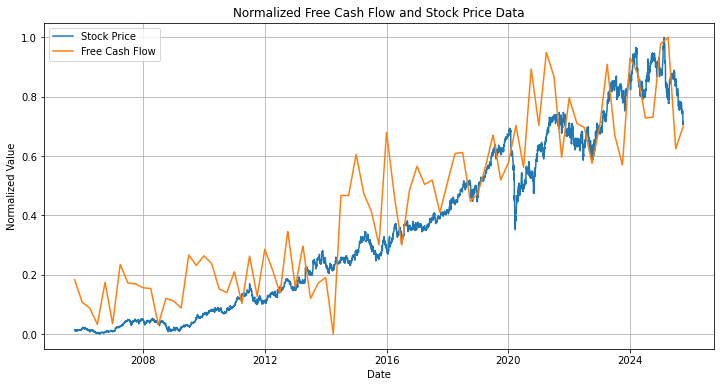


Fiscal Date Ending 2025-06-30
PV of future cash flows for GIB with i = 4.5%:
0.06261831155360226
with margin of safety of 20%:
0.05009464924288181
Current Market Capitalization:
0.018219562053337097
Market Cap => Safety
Today Price: 91.6500015258789
Fair Price: 251.99167919540403
174.95%




Fiscal Date Ending 2025-06-30


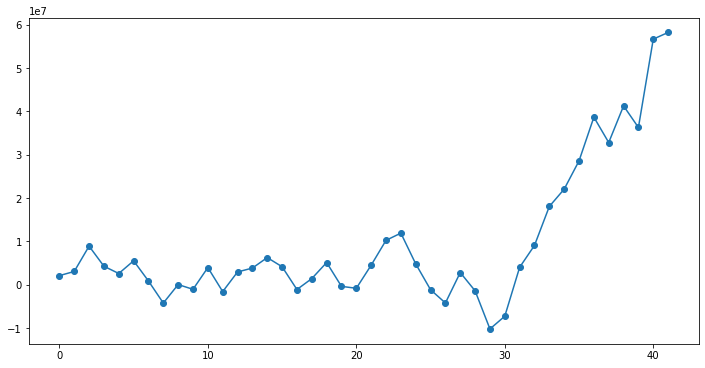

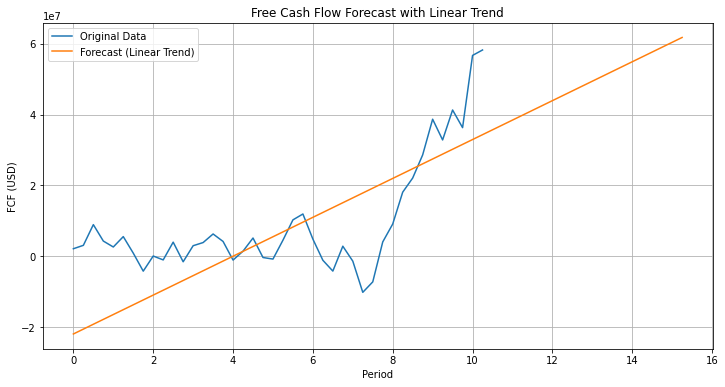

[*********************100%***********************]  1 of 1 completed


short Debt: $18,416,000.00
long Debt: $0.00
capital oblig Debt: $36,023,000.00
Total Debt: $54,439,000.00
Cost of Equity (Re): 9.51%
0.0
WACC for FRSH: 9.32%


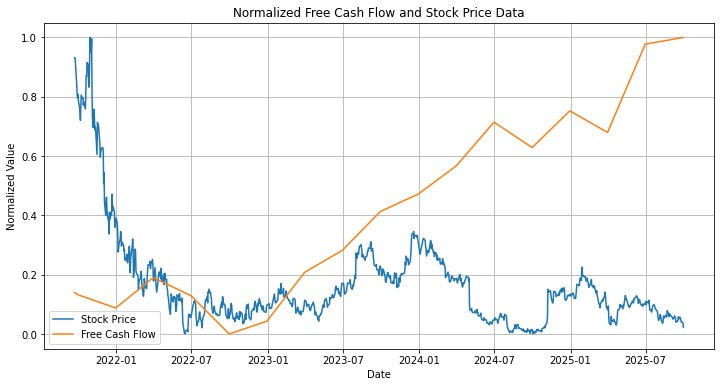


Fiscal Date Ending 2025-06-30
PV of future cash flows for FRSH with i = 4.5%:
0.004289401945036004
with margin of safety of 20%:
0.0034315215560288036
Current Market Capitalization:
0.002693401487388611
Market Cap => Safety
Today Price: 11.319999694824219
Fair Price: 14.421679611206056
27.4%




Fiscal Date Ending 2025-07-31


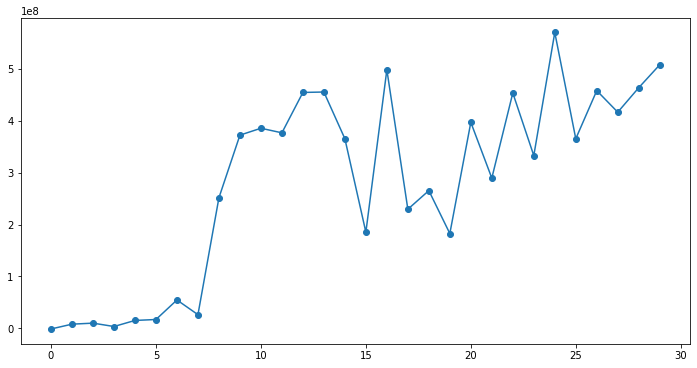

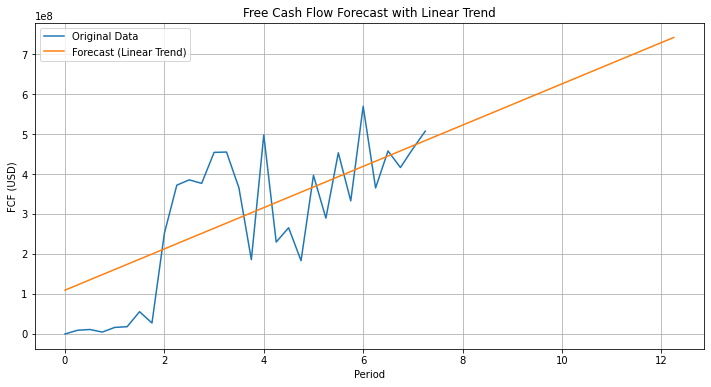

[*********************100%***********************]  1 of 1 completed


KeyError: 'Beta'

In [3]:

FCFAnalysisRecurrent(['DUOL','ONTO', 'DOCU', 'IQV','GIB', 'FRSH', 'ZM', 'DUOL',  'QLYS','V', 'MEDP'])




Fiscal Date Ending 2025-06-30


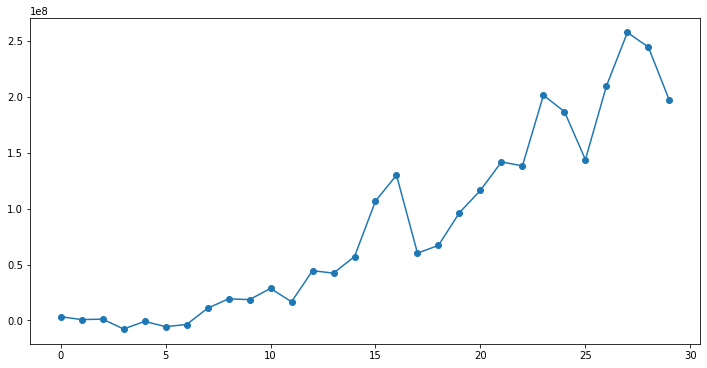

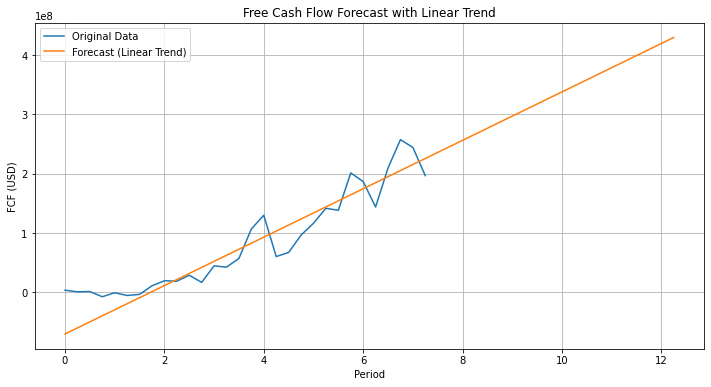

[*********************100%***********************]  1 of 1 completed


short Debt: $39,955,000.00
long Debt: $981,357,000.00
capital oblig Debt: $283,070,000.00
Total Debt: $1,304,382,000.00
Cost of Equity (Re): 10.58%
0.00235743823511824
WACC for DDOG: 10.28%


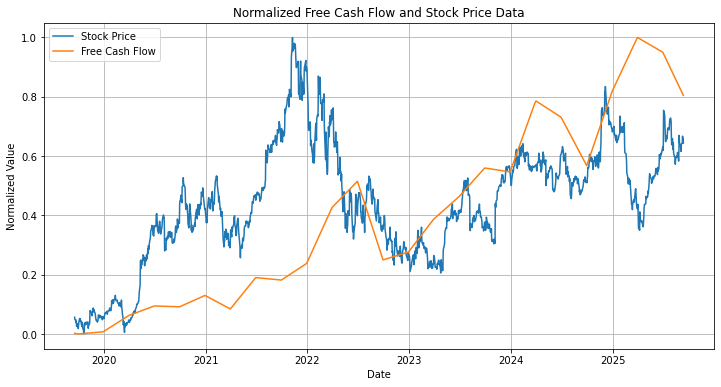


Fiscal Date Ending 2025-06-30
PV of future cash flows for DDOG with i = 4.5%:
0.02617938538016893
with margin of safety of 20%:
0.020943508304135147
Current Market Capitalization:
0.0441264915
Market Cap => Safety
Today Price: 136.5
Fair Price: 64.7829
-52.54%




Fiscal Date Ending 2025-06-30


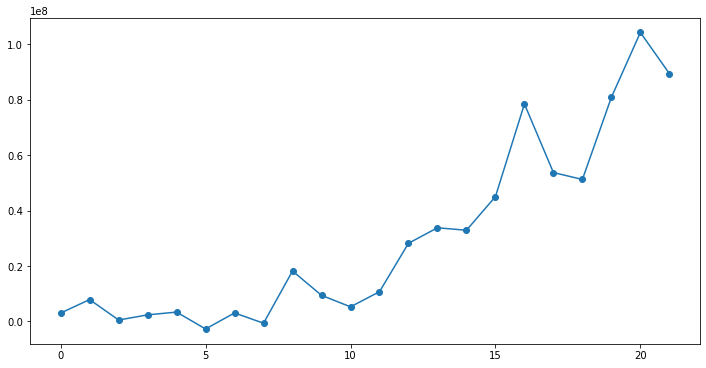

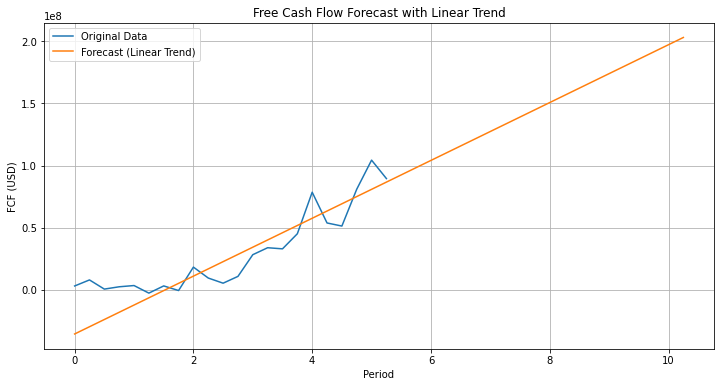

[*********************100%***********************]  1 of 1 completed


short Debt: $2,962,000.00
long Debt: $0.00
capital oblig Debt: $93,843,000.00
Total Debt: $96,805,000.00
Cost of Equity (Re): 9.15%
0.0
WACC for DUOL: 9.08%


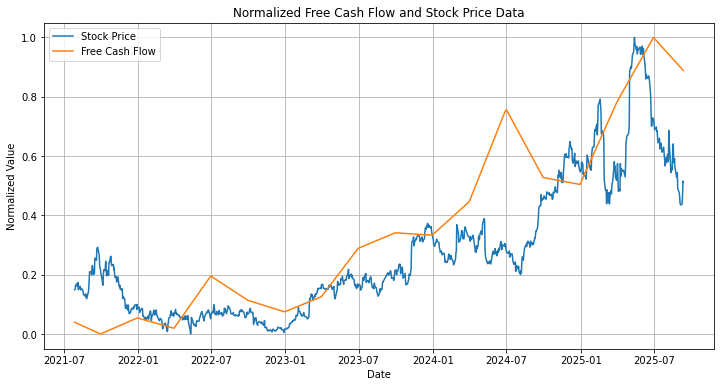


Fiscal Date Ending 2025-06-30
PV of future cash flows for DUOL with i = 4.5%:
0.01627505771521463
with margin of safety of 20%:
0.013020046172171704
Current Market Capitalization:
0.012222333640365601
Market Cap => Safety
Today Price: 307.9100036621094
Fair Price: 328.0165269012451
6.53%




Fiscal Date Ending 2025-06-30


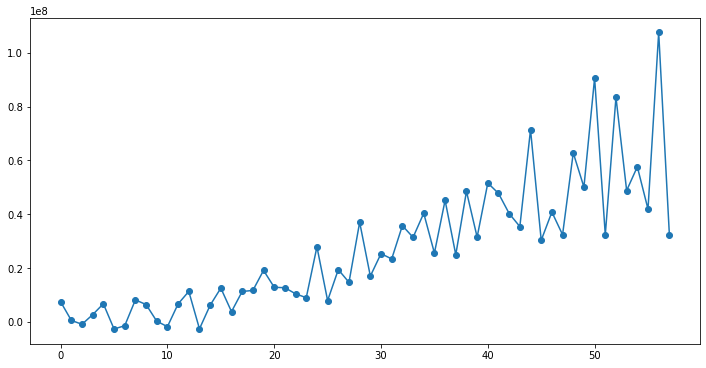

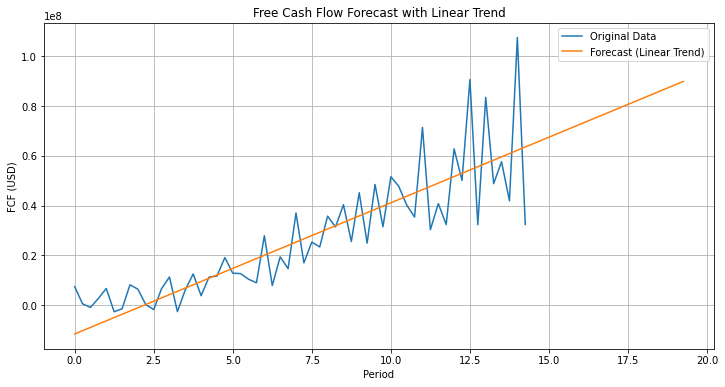

[*********************100%***********************]  1 of 1 completed


short Debt: $7,099,000.00
long Debt: $0.00
capital oblig Debt: $55,347,000.00
Total Debt: $62,446,000.00
Cost of Equity (Re): 8.06%
0.0
WACC for QLYS: 7.96%


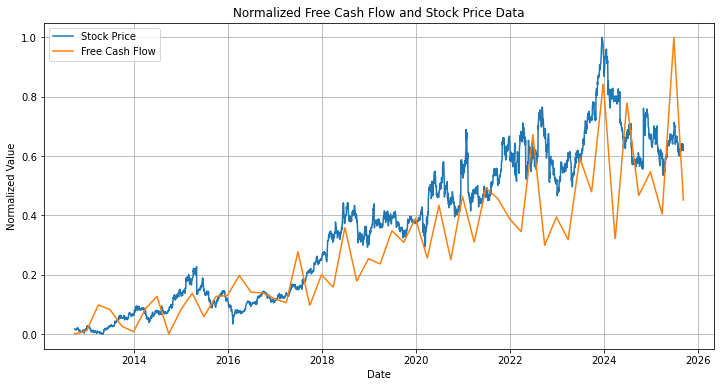


Fiscal Date Ending 2025-06-30
PV of future cash flows for QLYS with i = 4.5%:
0.006886409401929861
with margin of safety of 20%:
0.00550912752154389
Current Market Capitalization:
0.004817359056343079
Market Cap => Safety
Today Price: 133.4600067138672
Fair Price: 152.6248636779785
14.36%






KeyboardInterrupt: 

In [10]:
FCFAnalysisRecurrent(['DDOG','DUOL','QLYS','UBER','AVGO','VRSN','HRL', 'DOCU', 'LECO'])



Fiscal Date Ending 2025-06-30


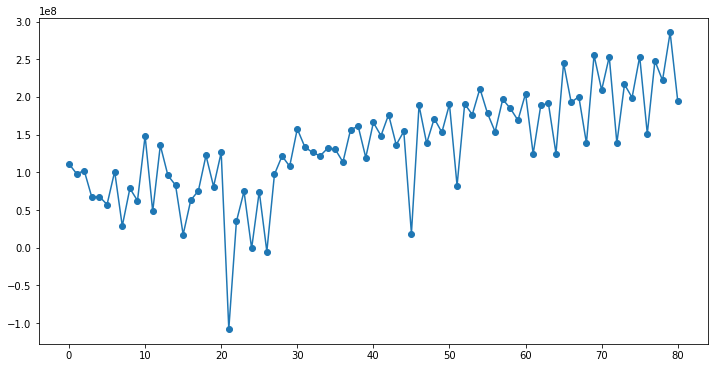

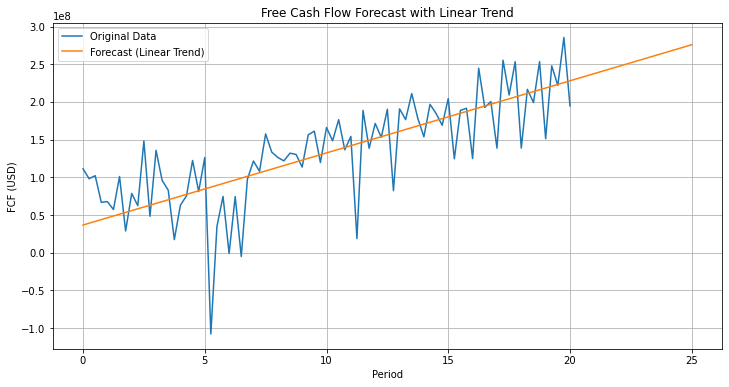

[*********************100%***********************]  1 of 1 completed


short Debt: $4,700,000.00
long Debt: $1,786,900,000.00
capital oblig Debt: $4,700,000.00
Total Debt: $1,791,600,000.00
Cost of Equity (Re): 8.87%
0.010549229738780978
WACC for VRSN: 8.37%


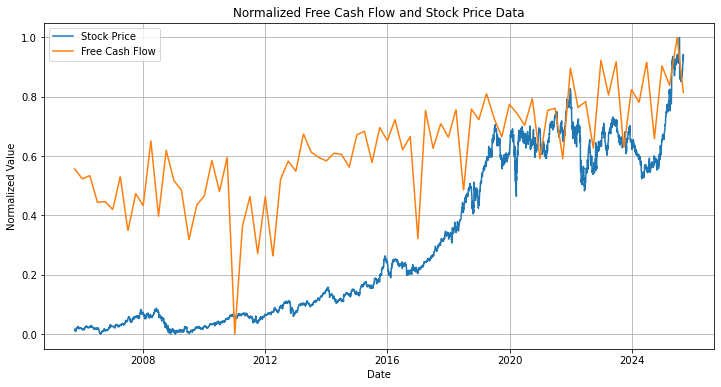


Fiscal Date Ending 2025-06-30
PV of future cash flows for VRSN with i = 4.5%:
0.017163205477469266
with margin of safety of 20%:
0.013730564381975414
Current Market Capitalization:
0.026670136653778077
Market Cap => Safety
Today Price: 285.5199890136719
Fair Price: 146.98569034423826
-48.52%




Fiscal Date Ending 2025-07-31


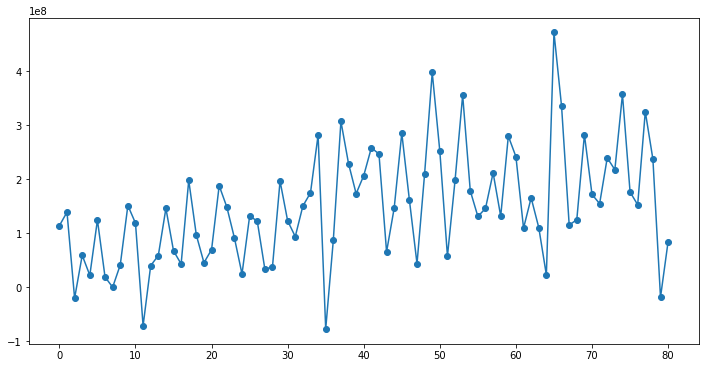

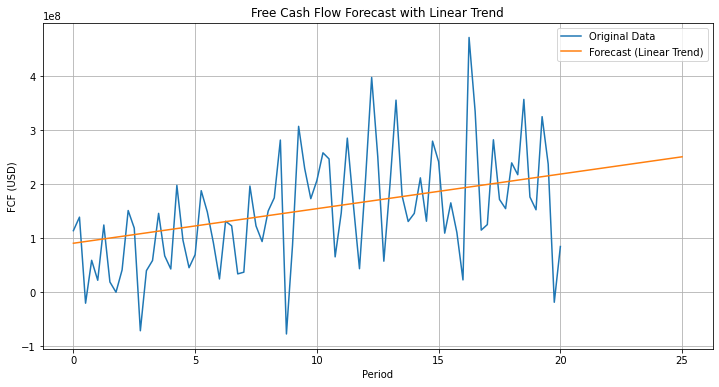

[*********************100%***********************]  1 of 1 completed


short Debt: $6,740,000.00
long Debt: $2,850,165,000.00
capital oblig Debt: $0.00
Total Debt: $2,856,905,000.00
Cost of Equity (Re): 6.19%
0.006811917092097917
WACC for HRL: 5.22%


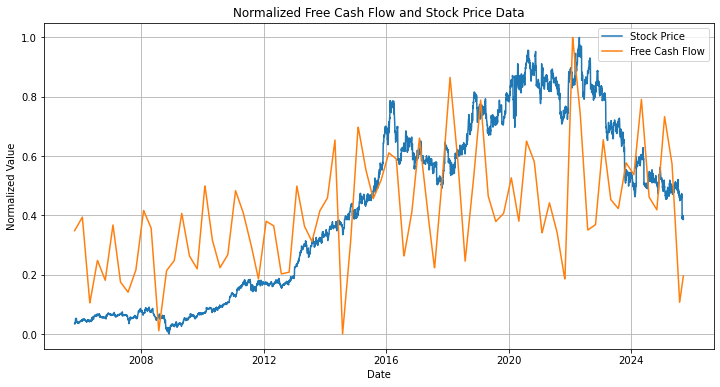


Fiscal Date Ending 2025-07-31
PV of future cash flows for HRL with i = 4.5%:
0.02691857628248039
with margin of safety of 20%:
0.021534861025984314
Current Market Capitalization:
0.013793949798038482
Market Cap => Safety
Today Price: 25.079999923706055
Fair Price: 39.15489588088989
56.12%




Fiscal Date Ending 2025-07-31


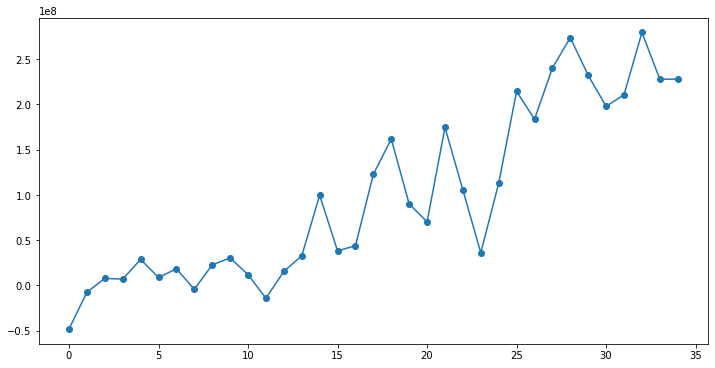

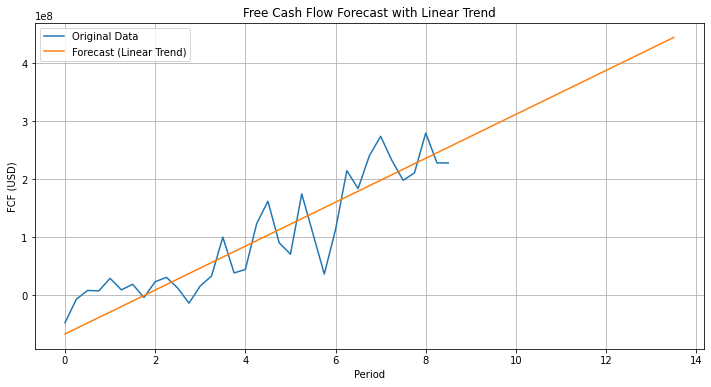

[*********************100%***********************]  1 of 1 completed


short Debt: $21,185,000.00
long Debt: $0.00
capital oblig Debt: $126,942,000.00
Total Debt: $148,127,000.00
Cost of Equity (Re): 10.12%
-0.012043719240921642
WACC for DOCU: 10.02%


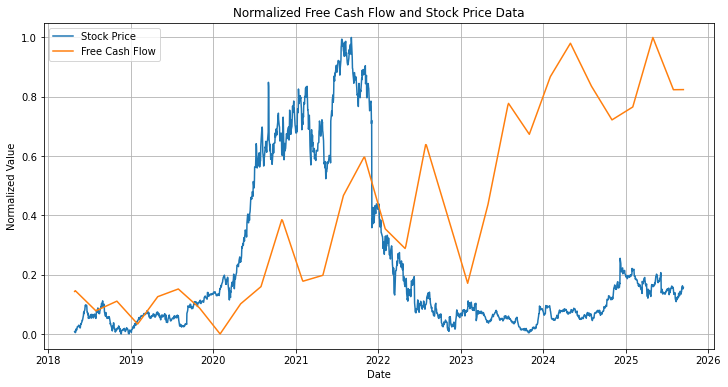


Fiscal Date Ending 2025-07-31
PV of future cash flows for DOCU with i = 4.5%:
0.02718117490151245
with margin of safety of 20%:
0.02174493992120996
Current Market Capitalization:
0.016126530250976562
Market Cap => Safety
Today Price: 80.19000244140625
Fair Price: 108.12819929199219
34.84%




Fiscal Date Ending 2025-06-30


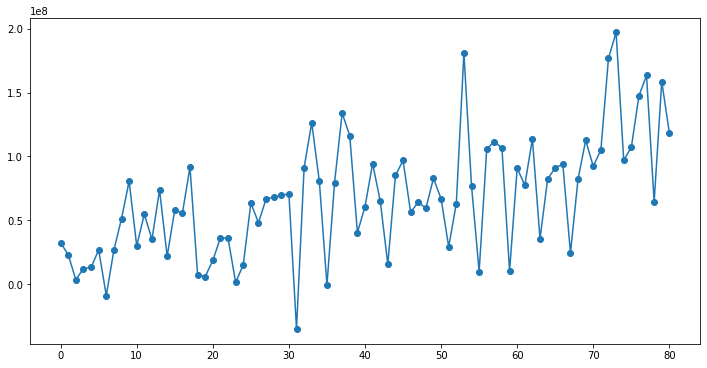

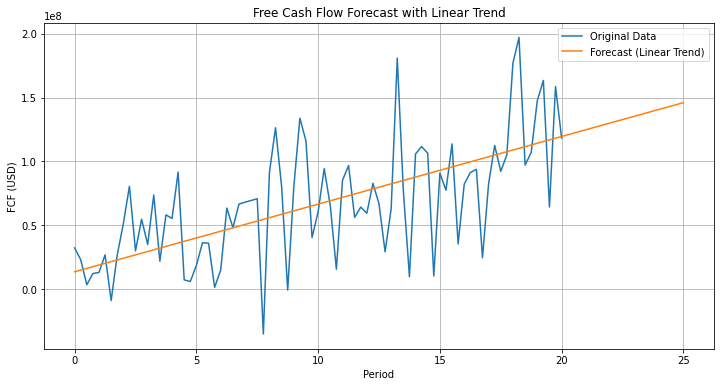

[*********************100%***********************]  1 of 1 completed


short Debt: $118,722,000.00
long Debt: $1,150,395,000.00
capital oblig Debt: $0.00
Total Debt: $1,269,117,000.00
Cost of Equity (Re): 11.25%
0.01179560276948461
WACC for LECO: 10.34%


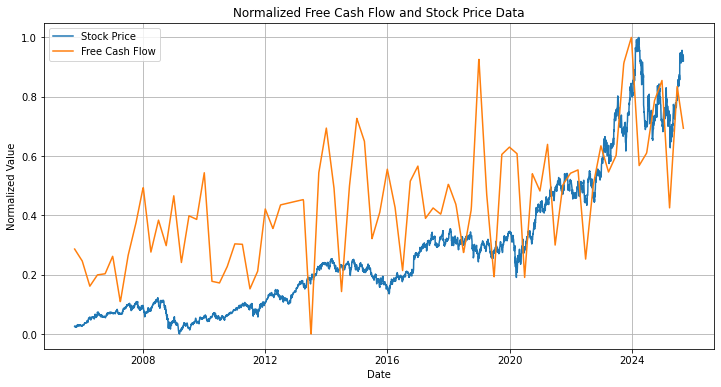


Fiscal Date Ending 2025-06-30
PV of future cash flows for LECO with i = 4.5%:
0.006989543832808232
with margin of safety of 20%:
0.005591635066246586
Current Market Capitalization:
0.01319662844946289
Market Cap => Safety
Today Price: 239.1300048828125
Fair Price: 101.31938306884764
-57.63%




Fiscal Date Ending 2025-06-30


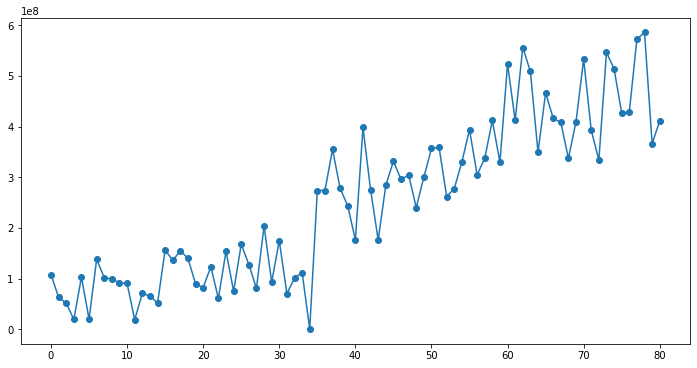

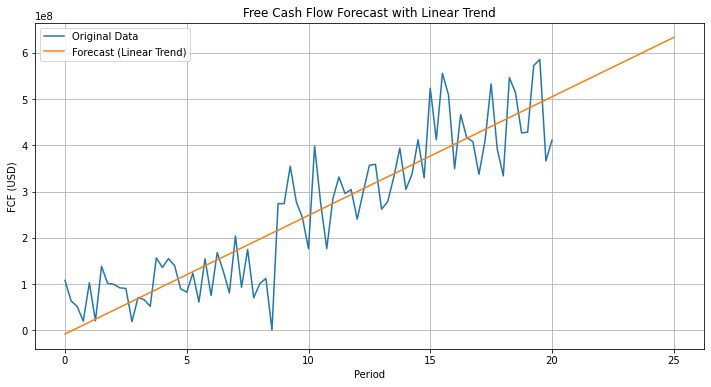

[*********************100%***********************]  1 of 1 completed


short Debt: $167,535,000.00
long Debt: $3,574,761,000.00
capital oblig Debt: $668,932,000.00
Total Debt: $4,411,228,000.00
Cost of Equity (Re): 7.76%
0.007622820674877835
WACC for GIB: 6.38%


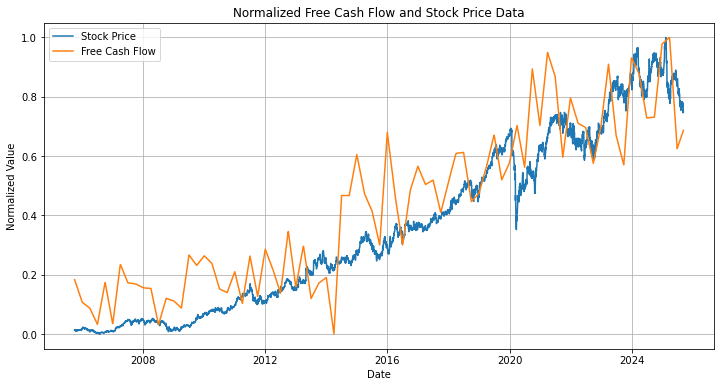


Fiscal Date Ending 2025-06-30
PV of future cash flows for GIB with i = 4.5%:
0.05917381160669743
with margin of safety of 20%:
0.04733904928535795
Current Market Capitalization:
0.01855154933933258
Market Cap => Safety
Today Price: 93.31999969482422
Fair Price: 238.13397522125246
155.18%




Fiscal Date Ending 2025-06-30


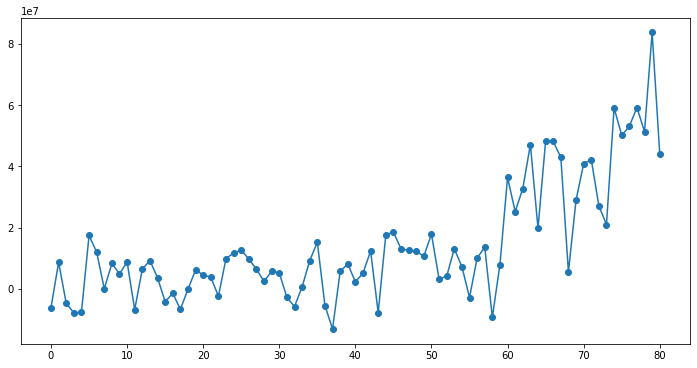

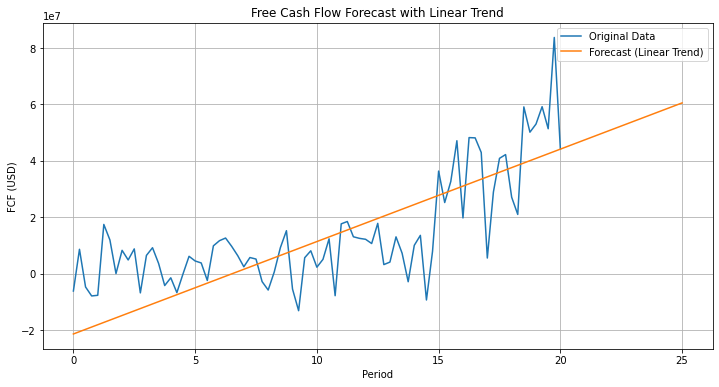

[*********************100%***********************]  1 of 1 completed


short Debt: $10,502,000.00
long Debt: $0.00
capital oblig Debt: $13,409,000.00
Total Debt: $23,911,000.00
Cost of Equity (Re): 13.16%
0.0
WACC for ONTO: 13.10%


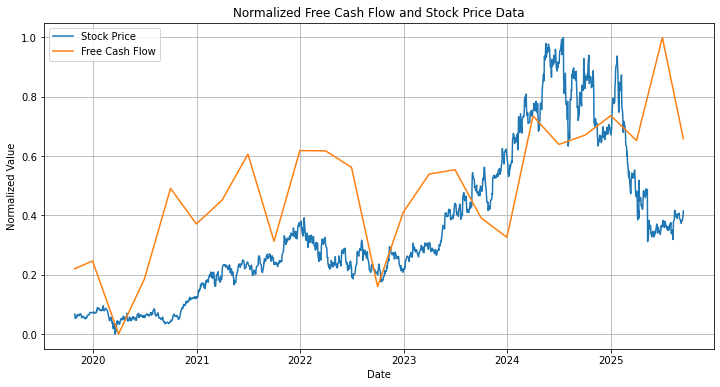


Fiscal Date Ending 2025-06-30
PV of future cash flows for ONTO with i = 4.5%:
0.002277737112735464
with margin of safety of 20%:
0.0018221896901883712
Current Market Capitalization:
0.005438419692501831
Market Cap => Safety
Today Price: 110.9800033569336
Fair Price: 37.189399124908455
-66.49%




Fiscal Date Ending 2025-06-30


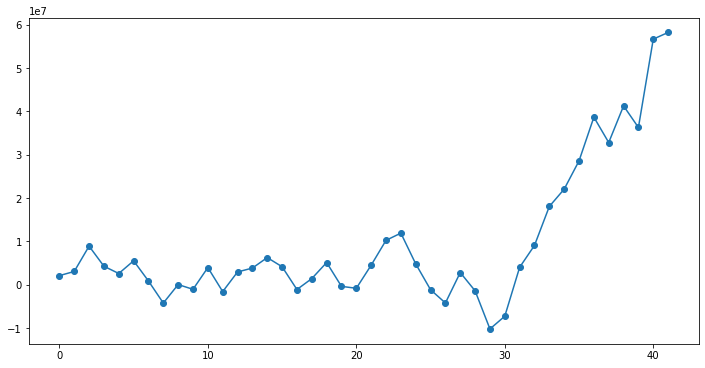

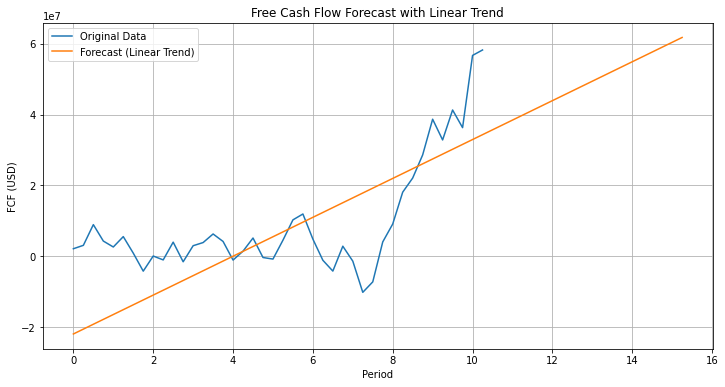

[*********************100%***********************]  1 of 1 completed


KeyError: 'Beta'

In [11]:
FCFAnalysisRecurrent(['VRSN','HRL', 'DOCU', 'LECO','GIB','ONTO','FRSH','IQV','AVGO','VRSN','HRL', 'DOCU', 'LECO'])



Fiscal Date Ending 2025-03-31


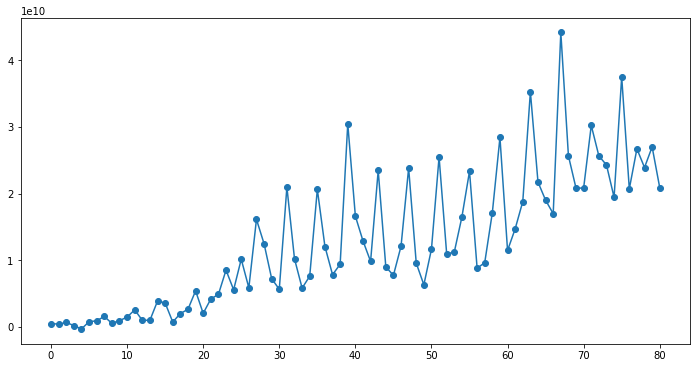

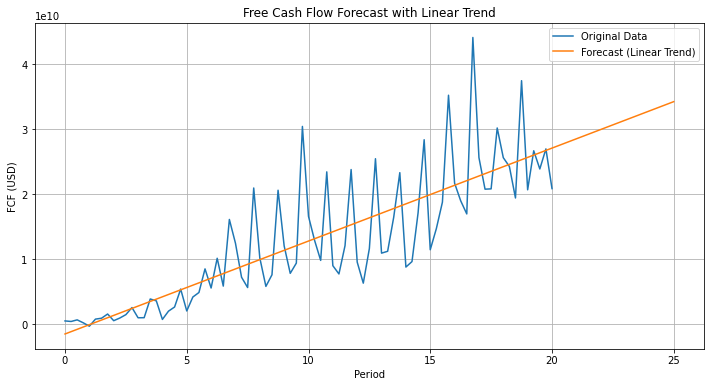

[*********************100%***********************]  1 of 1 completed


short Debt: $19,620,000,000.00
long Debt: $78,566,000,000.00
capital oblig Debt: $0.00
Total Debt: $98,186,000,000.00
Cost of Equity (Re): 11.16%
0.0
WACC for AAPL: 10.81%


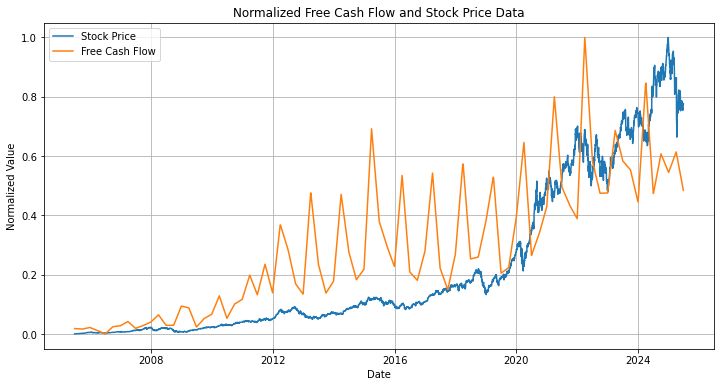


Fiscal Date Ending 2025-03-31
PV of future cash flows for AAPL with i = 4.5%:
1.5871365572739036
with margin of safety of 20%:
1.269709245819123
Current Market Capitalization:
3.0104598115356445
Market Cap => Safety
Today Price: 201.55999755859375
Fair Price: 85.01800697021483
-57.82%




Fiscal Date Ending 2025-03-31


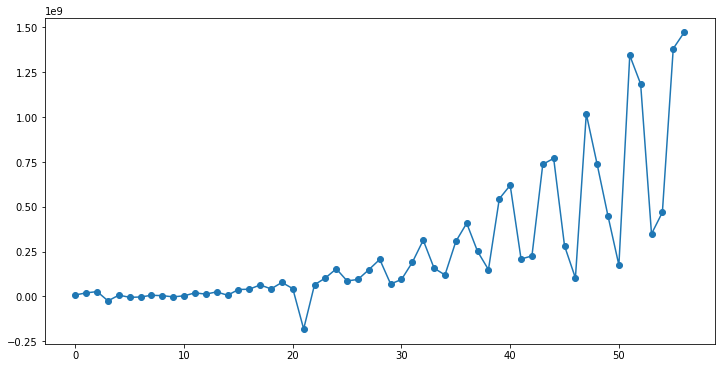

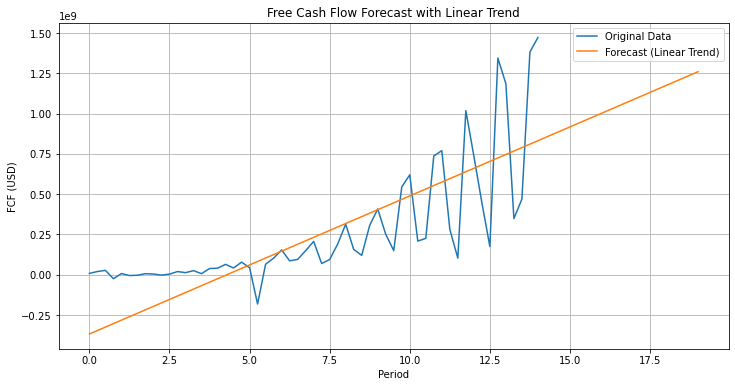

[*********************100%***********************]  1 of 1 completed


short Debt: $103,000,000.00
long Debt: $1,490,000,000.00
capital oblig Debt: $909,000,000.00
Total Debt: $2,502,000,000.00
Cost of Equity (Re): 9.76%
0.002398081534772182
WACC for NOW: 9.64%


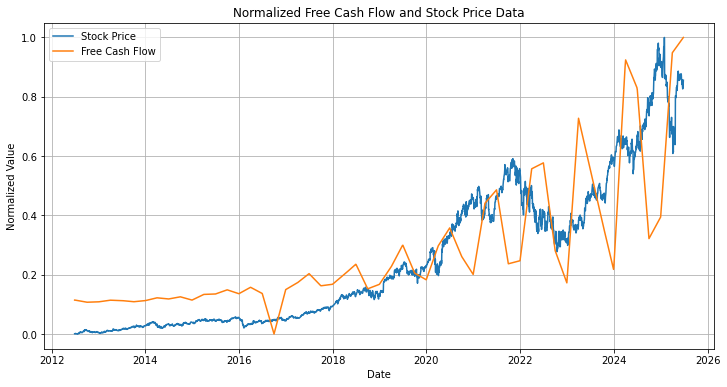


Fiscal Date Ending 2025-03-31
PV of future cash flows for NOW with i = 4.5%:
0.0761213162452588
with margin of safety of 20%:
0.06089705299620704
Current Market Capitalization:
0.20822089875683594
Market Cap => Safety
Today Price: 1005.1599731445312
Fair Price: 294.0092921447754
-70.75%




Fiscal Date Ending 2025-04-30


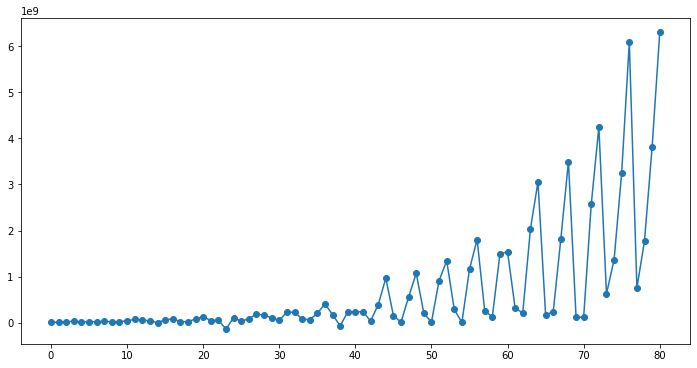

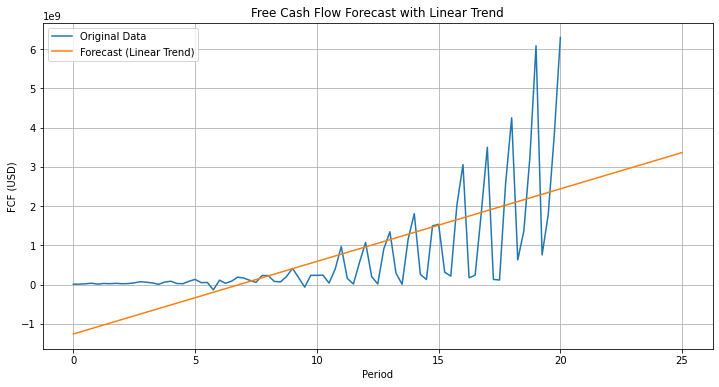

[*********************100%***********************]  1 of 1 completed


short Debt: $593,000,000.00
long Debt: $8,435,000,000.00
capital oblig Debt: $2,934,000,000.00
Total Debt: $11,962,000,000.00
Cost of Equity (Re): 12.07%
0.0
WACC for CRM: 11.53%


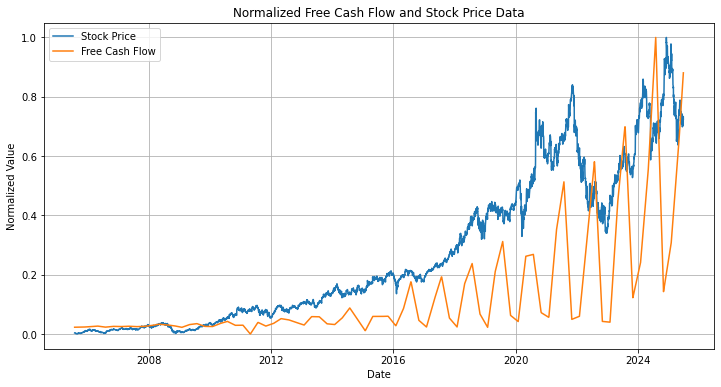


Fiscal Date Ending 2025-04-30
PV of future cash flows for CRM with i = 4.5%:
0.1502340828375968
with margin of safety of 20%:
0.12018726627007743
Current Market Capitalization:
0.2559785693359375
Market Cap => Safety
Today Price: 267.760009765625
Fair Price: 125.71332458496094
-53.05%




In [18]:
FCFAnalysisRecurrent(['AAPL','NOW','CRM' ])



Fiscal Date Ending 2025-06-30


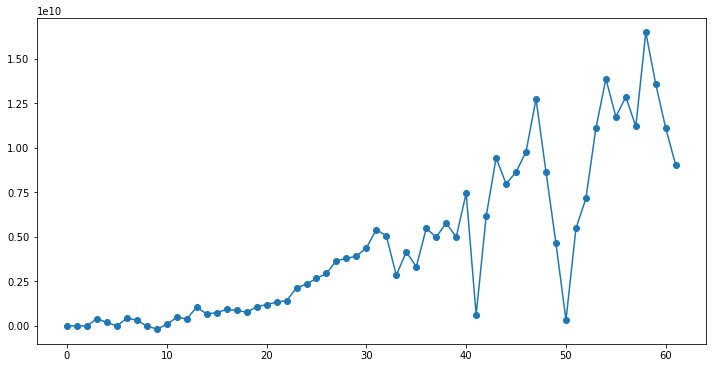

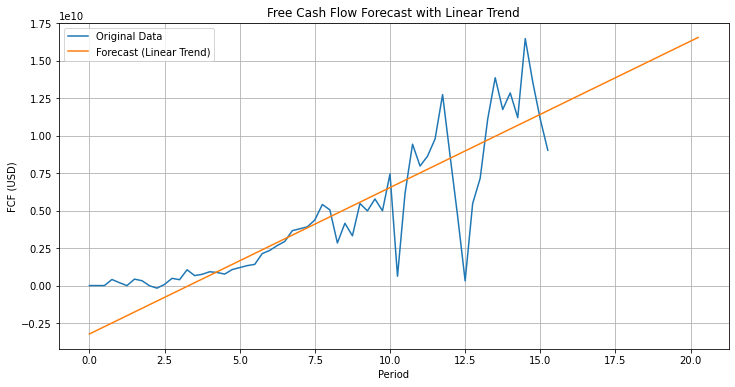

[*********************100%***********************]  1 of 1 completed


short Debt: $1,977,000,000.00
long Debt: $28,832,000,000.00
capital oblig Debt: $20,728,000,000.00
Total Debt: $51,537,000,000.00
Cost of Equity (Re): 11.33%
0.00467625201311679
WACC for META: 11.00%


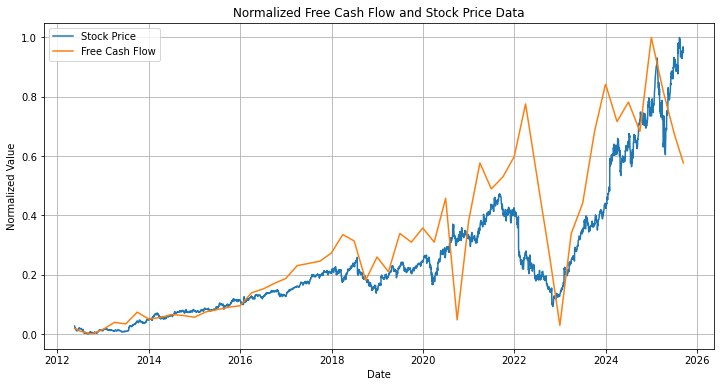


Fiscal Date Ending 2025-06-30
PV of future cash flows for META with i = 4.5%:
0.800087340569792
with margin of safety of 20%:
0.6400698724558337
Current Market Capitalization:
1.6388445446484374
Market Cap => Safety
Today Price: 755.5900268554688
Fair Price: 295.13346448974613
-60.94%




Fiscal Date Ending 2025-06-30


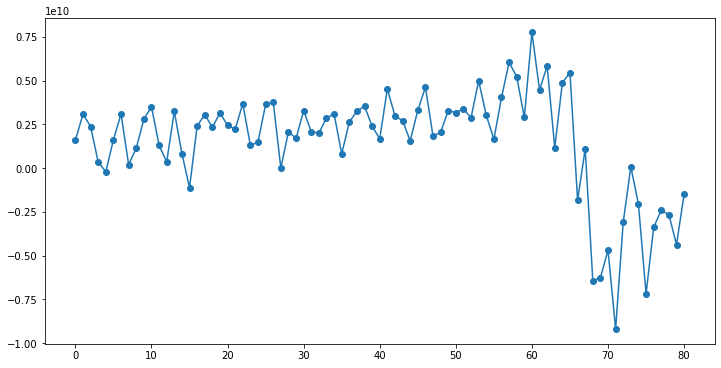

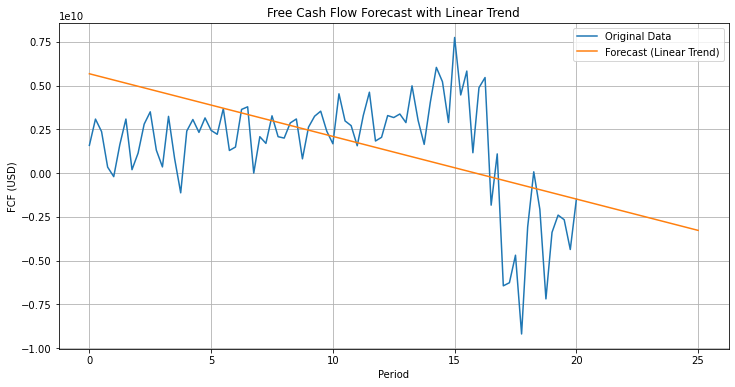

[*********************100%***********************]  1 of 1 completed


short Debt: $6,731,000,000.00
long Debt: $44,026,000,000.00
capital oblig Debt: $0.00
Total Debt: $50,757,000,000.00
Cost of Equity (Re): 11.27%
0.004472289536418622
WACC for INTC: 7.87%


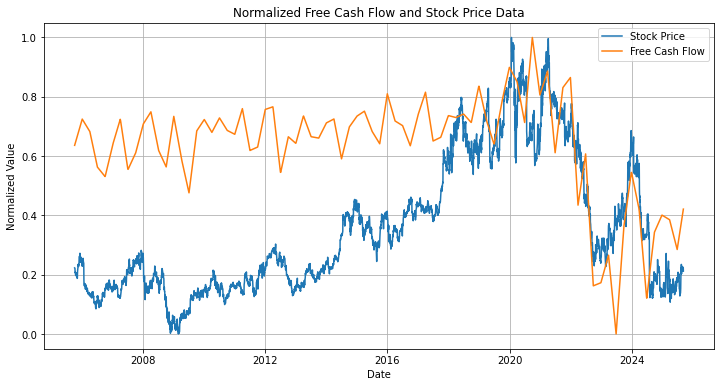


Fiscal Date Ending 2025-06-30
PV of future cash flows for INTC with i = 4.5%:
-0.32714862251806603
with margin of safety of 20%:
-0.26171889801445286
Current Market Capitalization:
0.11245986044368744
Market Cap => Safety
Today Price: 24.079999923706055
Fair Price: -56.03897582244874
-332.72%




Fiscal Date Ending 2025-06-30


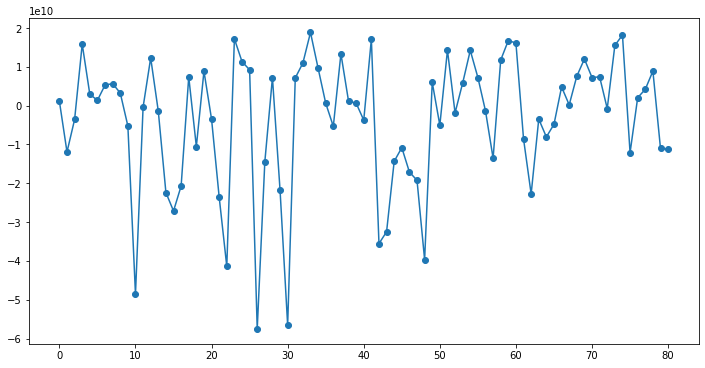

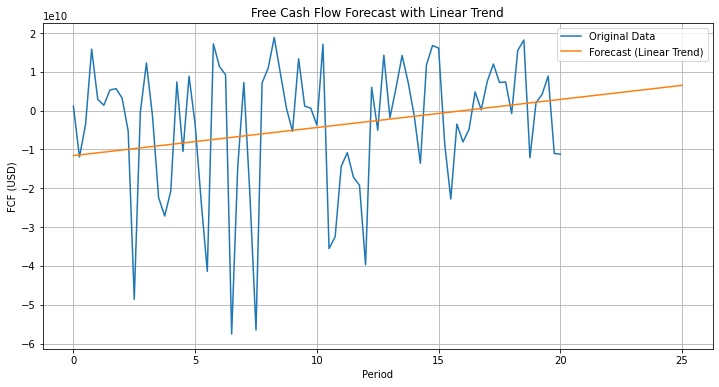

[*********************100%***********************]  1 of 1 completed


short Debt: $187,995,000,000.00
long Debt: $176,237,000,000.00
capital oblig Debt: $0.00
Total Debt: $364,232,000,000.00
Cost of Equity (Re): 11.33%
0.026389773550923586
WACC for WFC: 5.94%


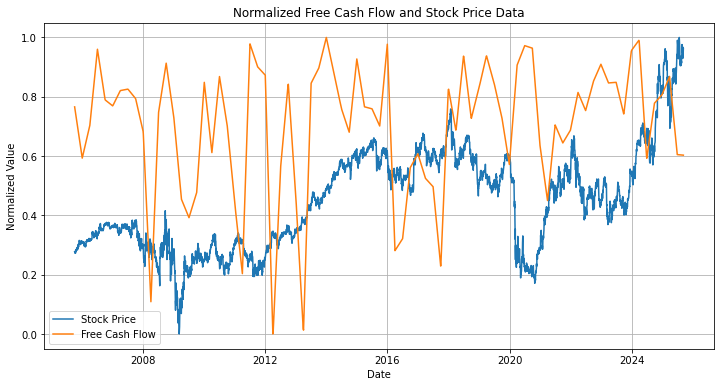


Fiscal Date Ending 2025-06-30
PV of future cash flows for WFC with i = 4.5%:
1.066696292626836
with margin of safety of 20%:
0.8533570341014688
Current Market Capitalization:
0.26095221946716307
Market Cap => Safety
Today Price: 81.45999908447266
Fair Price: 266.39048900604246
227.02%




Fiscal Date Ending 2025-06-30


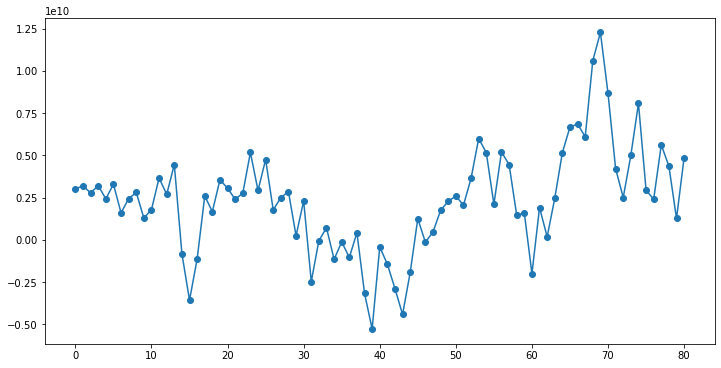

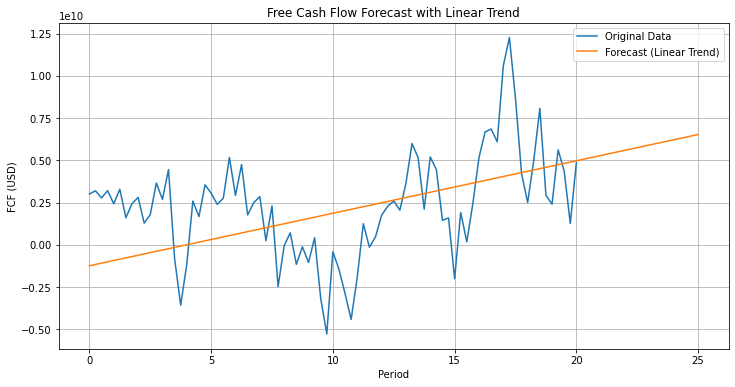

[*********************100%***********************]  1 of 1 completed


short Debt: $6,191,000,000.00
long Debt: $23,276,000,000.00
capital oblig Debt: $0.00
Total Debt: $29,467,000,000.00
Cost of Equity (Re): 9.31%
0.009298537346862592
WACC for CVX: 8.58%


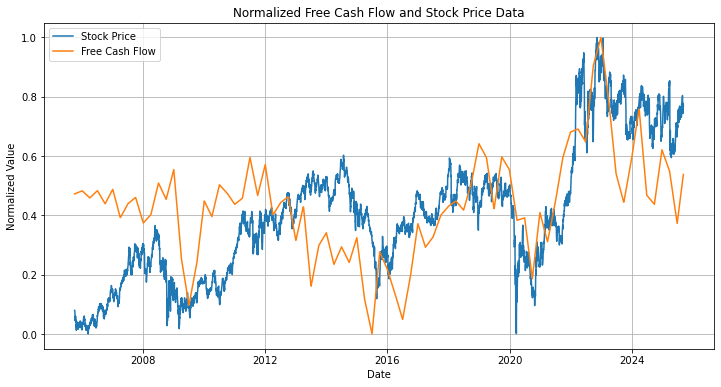


Fiscal Date Ending 2025-06-30
PV of future cash flows for CVX with i = 4.5%:
0.4227829057268953
with margin of safety of 20%:
0.33822632458151625
Current Market Capitalization:
0.3165483714297485
Market Cap => Safety
Today Price: 157.11000061035156
Fair Price: 167.87203565216063
6.85%




In [13]:
FCFAnalysisRecurrent(['META', 'INTC', 'WFC', 'CVX'])



Fiscal Date Ending 2025-05-31


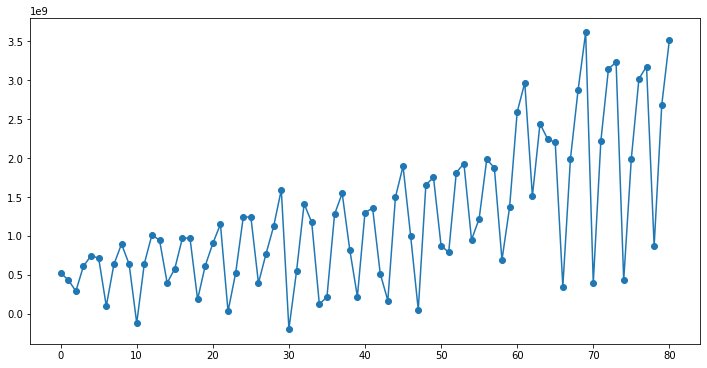

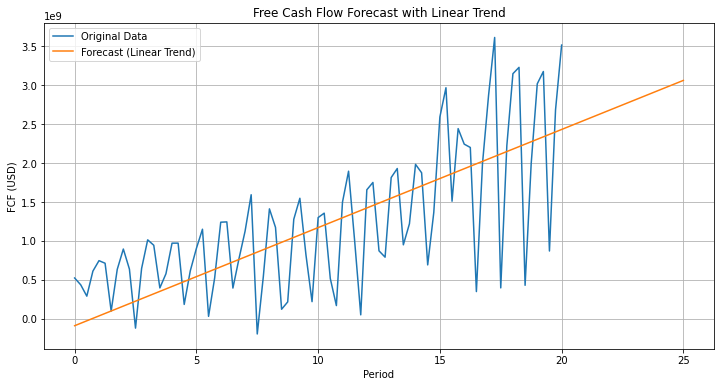

[*********************100%***********************]  1 of 1 completed


short Debt: $839,342,000.00
long Debt: $5,035,975,000.00
capital oblig Debt: $3,014,219,000.00
Total Debt: $8,889,536,000.00
Cost of Equity (Re): 11.62%
0.007604558888112945
WACC for ACN: 11.00%


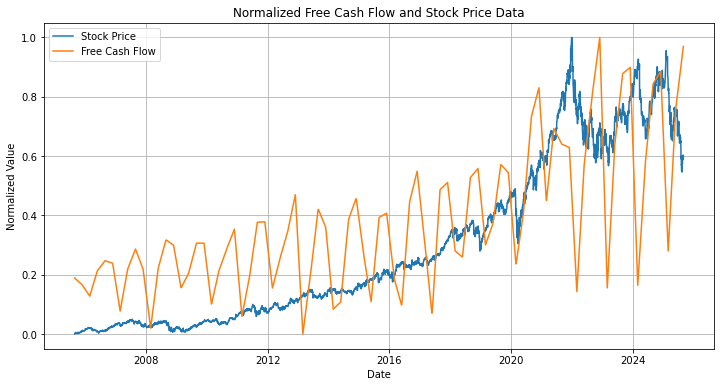


Fiscal Date Ending 2025-05-31
PV of future cash flows for ACN with i = 4.5%:
0.13834784409903456
with margin of safety of 20%:
0.11067827527922765
Current Market Capitalization:
0.14857535043824768
Market Cap => Safety
Today Price: 238.5399932861328
Fair Price: 177.68844099884032
-25.51%




Fiscal Date Ending 2025-06-30


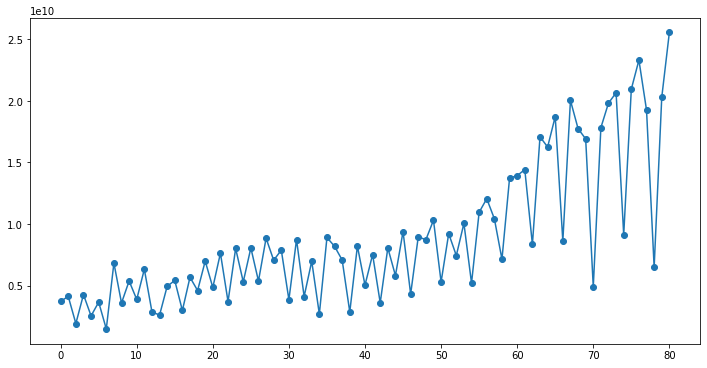

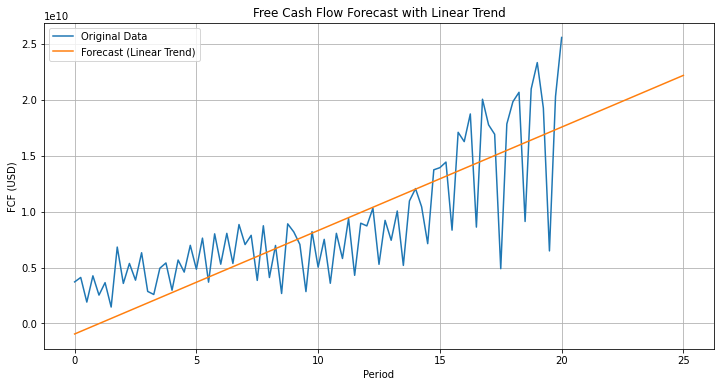

[*********************100%***********************]  1 of 1 completed


short Debt: $2,999,000,000.00
long Debt: $40,152,000,000.00
capital oblig Debt: $17,437,000,000.00
Total Debt: $60,588,000,000.00
Cost of Equity (Re): 10.22%
0.01015052485640721
WACC for MSFT: 10.07%


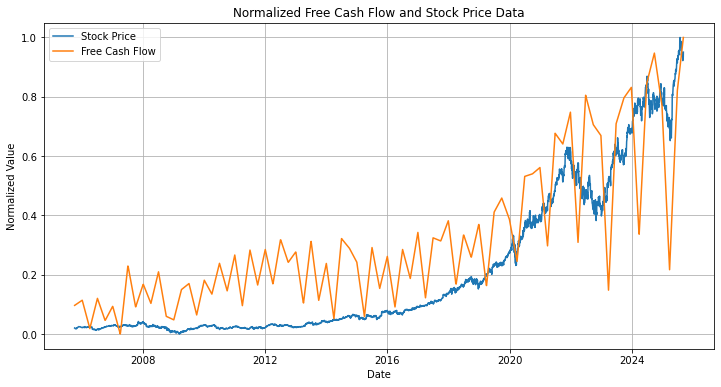


Fiscal Date Ending 2025-06-30
PV of future cash flows for MSFT with i = 4.5%:
1.1246294674664685
with margin of safety of 20%:
0.8997035739731749
Current Market Capitalization:
3.790173337631531
Market Cap => Safety
Today Price: 509.8999938964844
Fair Price: 121.05025855102537
-76.26%




Fiscal Date Ending 2025-06-30


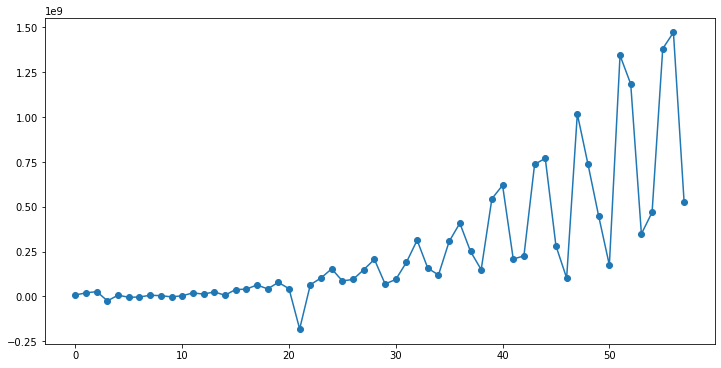

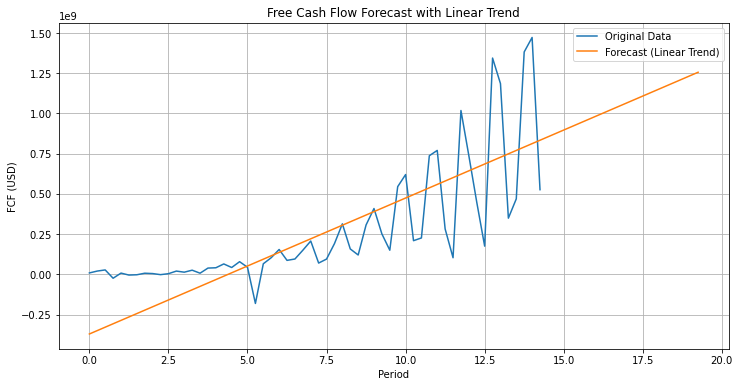

[*********************100%***********************]  1 of 1 completed


short Debt: $104,000,000.00
long Debt: $1,490,000,000.00
capital oblig Debt: $919,000,000.00
Total Debt: $2,513,000,000.00
Cost of Equity (Re): 9.52%
0.00238758456028651
WACC for NOW: 9.40%


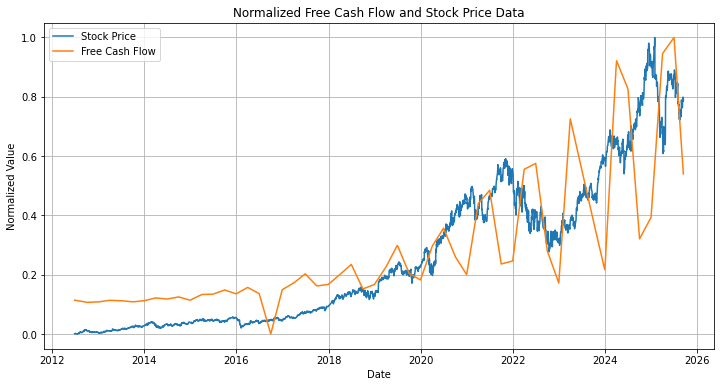


Fiscal Date Ending 2025-06-30
PV of future cash flows for NOW with i = 4.5%:
0.07854023624554463
with margin of safety of 20%:
0.06283218899643571
Current Market Capitalization:
0.19277685479974366
Market Cap => Safety
Today Price: 928.9600219726562
Fair Price: 302.74807116088874
-67.41%




Fiscal Date Ending 2025-05-31


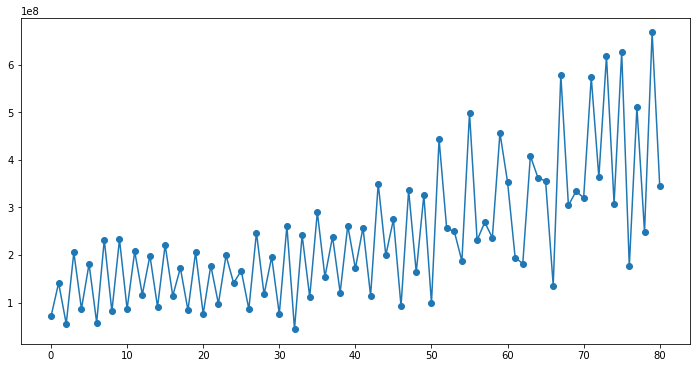

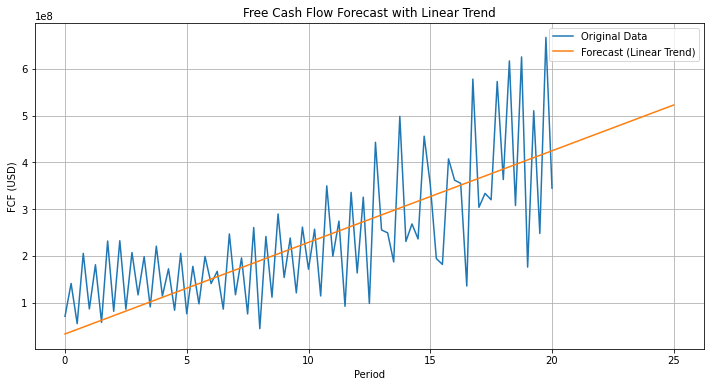

[*********************100%***********************]  1 of 1 completed


short Debt: $418,400,000.00
long Debt: $4,548,400,000.00
capital oblig Debt: $55,500,000.00
Total Debt: $5,022,300,000.00
Cost of Equity (Re): 9.47%
0.012683431893753858
WACC for PAYX: 8.68%


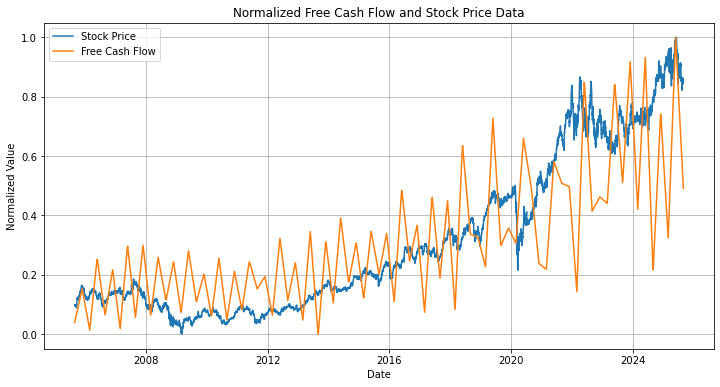


Fiscal Date Ending 2025-05-31
PV of future cash flows for PAYX with i = 4.5%:
0.031525971761092876
with margin of safety of 20%:
0.025220777408874302
Current Market Capitalization:
0.04858677220948791
Market Cap => Safety
Today Price: 135.11000061035156
Fair Price: 70.13560131683349
-48.09%




Fiscal Date Ending 2025-05-31


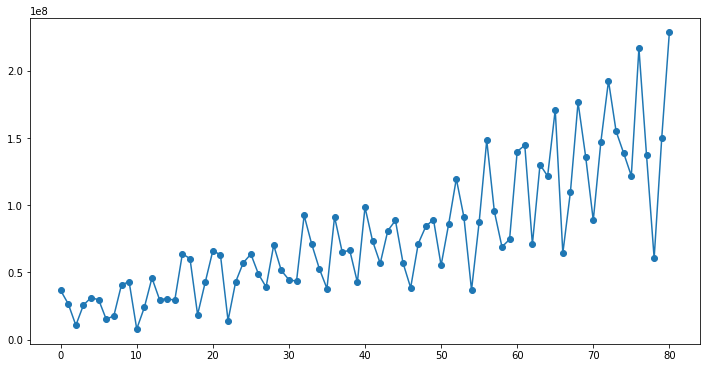

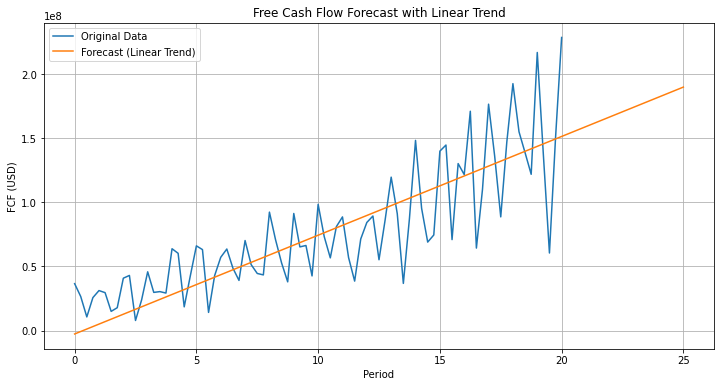

[*********************100%***********************]  1 of 1 completed


short Debt: $33,219,000.00
long Debt: $1,430,197,000.00
capital oblig Debt: $190,307,000.00
Total Debt: $1,653,723,000.00
Cost of Equity (Re): 9.10%
0.009144215808814414
WACC for FDS: 8.19%


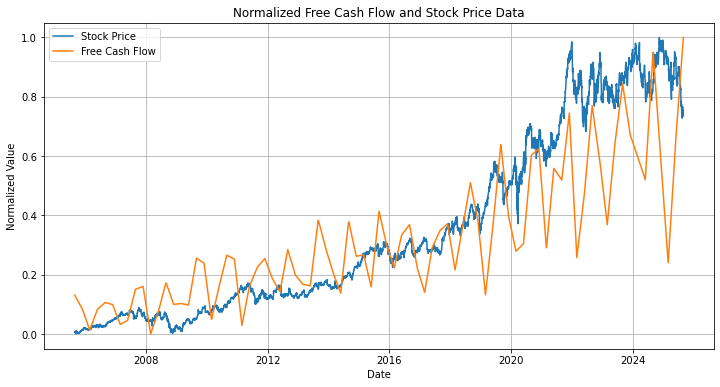


Fiscal Date Ending 2025-05-31
PV of future cash flows for FDS with i = 4.5%:
0.012578691621260529
with margin of safety of 20%:
0.010062953297008424
Current Market Capitalization:
0.013680012373547363
Market Cap => Safety
Today Price: 361.8399963378906
Fair Price: 266.16950130615237
-26.44%




Fiscal Date Ending 2025-06-30


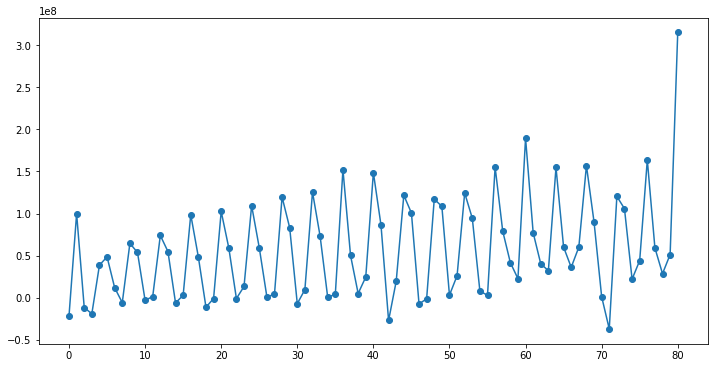

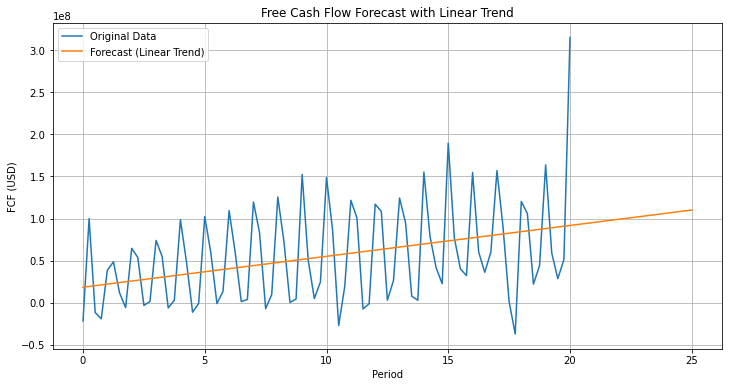

[*********************100%***********************]  1 of 1 completed


short Debt: $0.00
long Debt: $0.00
capital oblig Debt: $0.00
Total Debt: $0.00
Cost of Equity (Re): 8.85%


ZeroDivisionError: float division by zero

In [19]:
FCFAnalysisRecurrent(['ACN', 'MSFT', 'NOW', 'PAYX', 'FDS', 'JKHY'])


In [ ]:
url = f'https://www.alphavantage.co/query?function=INCOME_STATEMENT&symbol=IQV&apikey=YQVUCRXG19J8O9CY'
r = requests.get(url)
data1 = r.json()

In [ ]:
data1['quarterlyReports'][0]

In [ ]:
data1['annualReports']

In [ ]:
import yfinance as yf

ticker = yf.Ticker("7203.T")  # Toyota Motor Corp (Tokyo Exchange)

ticker


In [ ]:
import yfinance as yf

ticker = yf.Ticker("QLYS")  # Toyota Motor Corp (Tokyo Exchange)

ticker.cashflow



In [ ]:
import yfinance as yf

ticker = yf.Ticker("AAPL")
fcf_df = ticker.cashflow

# Get Free Cash Flow row
fcf = fcf_df.loc["Free Cash Flow"]
print(fcf)


In [22]:
import requests
import pandas as pd

def get_wacc_gurufocus_json(ticker):
    url = f"https://www.gurufocus.com/term/wacc/{ticker}/WACC/"
    headers = {
        "User-Agent": (
            "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
            "AppleWebKit/537.36 (KHTML, like Gecko) "
            "Chrome/114.0.0.0 Safari/537.36"
        ),
        "Accept-Language": "en-US,en;q=0.9",
        "Referer": "https://www.google.com/",
        "DNT": "1"
    }
    resp = requests.get(url, headers=headers)
    if resp.status_code != 200:
        print(f"Request failed with status code {resp.status_code}")
        return None

    # Parse all HTML tables from the page
    tables = pd.read_html(resp.text)
    for df in tables:
        # Look for WACC label and a percentage value
        if 'WACC %' in df.columns:
            val = df.loc[0, 'WACC %']
            try:
                return float(str(val).strip('%')) / 100
            except:
                pass

    print("WACC value not found in page tables.")
    return None

# Test it
wacc = get_wacc_gurufocus_json("IQV")
if wacc is not None:
    print(f"IQV WACC is {wacc*100:.2f}%")
else:
    print("Failed to retrieve WACC.")



Request failed with status code 403
Failed to retrieve WACC.


In [2]:
import yfinance as yf

data = yf.download("AAPL", start="2023-01-01")
print(data.head())


/var/folders/2_/9syg52ws3sn4p74x580pkp6r0000gn/T/ipykernel_25096/4222676344.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download("AAPL", start="2023-01-01")
[*********************100%***********************]  1 of 1 completed

Price            Close        High         Low        Open     Volume
Ticker            AAPL        AAPL        AAPL        AAPL       AAPL
Date                                                                 
2023-01-03  123.470604  129.226044  122.582112  128.613978  112117500
2023-01-04  124.744125  127.014716  123.480495  125.267347   89113600
2023-01-05  123.421249  126.136083  123.164580  125.504267   80962700
2023-01-06  127.962410  128.623840  123.292902  124.398582   87754700
2023-01-09  128.485657  131.703978  128.228987  128.801572   70790800
